In [24]:
library(repr) ; options(repr.plot.width=7, repr.plot.height= 6) # Change plot sizes (in cm) - this bit of code is only relevant if you are using a juyter notebook - ignore otherwise

# Data Management and Visualization

> *Clutter and confusion are failures of design, not attributes of information.* &ndash; Edward Tufte

> *Tidy datasets are all alike, but every messy dataset is messy in its own way.* &ndash; Hadley Wickham

```{admonition} Learning goals
**By the end of this chapter you should be able to:**
- Apply data wrangling principles to clean and reshape messy biological datasets
- Import, manipulate, and export data in R using base R and tidyverse approaches
- Convert between wide and long data formats for different analytical purposes
- Create effective data visualizations using ggplot2 (scatter plots, box plots, histograms, etc.)
- Understand and apply principles of good data management and metadata
- Recognize and handle common data quality issues (missing values, inconsistent formats)
- Design relational databases for efficient data storage and retrieval
```

```{admonition} Prerequisites
:class: tip
**Before starting this chapter, you should:**
- Have basic familiarity with R (installing packages, running commands, using scripts)
- Have completed the [R chapter](r) in the Computing section
- Understand basic statistical concepts (mean, median, variance)
- Be comfortable working with file paths and directories
```

## Introduction

This chapter aims at introducing you to key principles and methods for data processing, storage, exploration and visualization. 

In this modern world, massive amounts of data are being generated in biology due to rapid advances in technologies for collecting new, as well as for digitizing old data. Some prominent examples are *Genomic*, *Ecosystem respiration*, *Climatic*, and *Animal tracking* data. Ultimately, the goal of quantitative biology is to both, discover patterns in these data, and fit mathematical models to them. Reproducible data manipulation, analyses and visualization are particularly necessary when data are so large and complex, and few are more so than biological data, which are extremely heterogeneous in their structure and quality.  Furthermore, when these data are "big" (more below on what makes a dataset "big"), computationally-efficient data handling, manipulation and analysis techniques are needed.

## Data wrangling

You are likely to spend far more time than you think dredging through data files manually &ndash; checking them, editing them, and reformatting them to make them useful for data exploration and analysis. It is often the case that you'll have to deal with messy or incomplete data, either because of sampling challenges (e.g., "field" data), or because you got given data that was poorly recorded and maintained. The data we obtain from different data sources is often unusable at the beginning; for example you may need to:
* Identify the variables vs observations within the data&mdash;somebody else might have recorded the data, or you youself might have collected the data some time back!
* Fill in zeros (true measured or observed absences) 
* Identify and add a value (e.g., `-999999`) to denote missing observations	
* Derive or calculate new variables from the raw observations (e.g., convert measurements to SI units; kilograms, meters, seconds, etc.)
* Reshape/reformat your data into a layout that works best for analysis (e.g., for R itself);e.g., from wide to long data format for replicated (across plates, chambers, plots, sites, etc.) data
* Merge multiple datasets together into a single data sheet

This is not an exhaustive list. Doing so many different things to your raw data is both time-consuming and risky. Why risky? Because  to err is very human, and every new, tired mouse-click and/or keyboard-stab has a high probability of inducing an erroneous data point!


![image](./graphics/Wrangling2.jpg)
<small> <center>(A (metaphorical) datum being wrangled into submission <br> Source: [https://pathanruet.files.wordpress.com/2012/05/unix-tree.png](https://pathanruet.files.wordpress.com/2012/05/unix-tree.png))</center></small>



### Some data wrangling principles

So you would like a record of the data wrangling process (so that it  is repeatable and even reversible), and automate it to the extent  possible. To this end, here are some guidelines:

* Store data in universally (machine)-readable, non-proprietary formats; basically, use plain ASCII text for your file names, variable/field/column names, and data values. And make sure the data file's "text encoding" is correct and standard  (e.g., `UTF-8`). 

* Keep a metadata file for each unique dataset (again, in  non-proprietary format).

* Minimize modifying raw data by hand&mdash;use scripts  instead&mdash;keep a copy of the data as they were recorded.

* Use meaningful names for your data and files and field (column) names

* When you add data, try not to add columns (widening the format); rather, design your tables/data-sheets so that you add only rows (lengthening the format)&mdash;and convert "wide format data" to "long format data" using  scripts, not by hand,

* All cells within a data column should contain only one type of information (i.e., either text (character), numeric, etc.). 

* Ultimately, consider creating a relational database for your data (More on this below).

This is not an exhaustive list either&mdash; see the [Readings & Resources Section](#Readings-&-Resources).

We will use the Pound Hill dataset collected by students in a past Silwood Field Course for understanding some of these  principles. 

To start with, we need to import the *raw* data file, for which, follow these steps:

&#9733; Copy the file `PoundHillData.csv` and `PoundHillMetaData.csv` files from TheMulQuaBio's `data` directory into your own R week's `data` directory. Then load the data in R: 

In [25]:
setwd("../code/")

In [26]:
MyData <- as.matrix(read.csv("../data/PoundHillData.csv",header = FALSE))
class(MyData)

[1] "matrix" "array"

* Loading the data `as.matrix()`, and setting `header=FALSE` guarantees that the data are imported "as is" so that you can wrangle them. Otherwise `read.csv` will convert the first row to column headers.
* All the data will be converted to the character class in the resulting matrix called `MyData` because at least one of the entries is already character class.

```{note}
As of R version 4.0.0 of R released in April 2020, the default for
`stringsAsFactors` [was changed to false](https://cran.r-project.org/doc/manuals/r-devel/NEWS.html) If you are using R version 3.x.x, you will need to add `stringsAsFactors = FALSE` to the above command to prevent R from converting all columns of character type (strings) to the `factor` data type (this will create problems with subsequent data wrangling).
```

&#9733; Now load the Metadata:

In [27]:
MyMetaData <- read.csv("../data/PoundHillMetaData.csv",header = TRUE,  sep=";")
class(MyMetaData)

[1] "data.frame"

* Here, `header =TRUE` because we do have metadata headers (`FieldName` and`Description`), and 
* We have used semicolon (`;`) as delimiter because there are commas in one of the field descriptions.
* We have avoided spaces in the columns headers (so "FieldName" instead of "Field Name") — please avoid spaces in field or column names because R will replace each space in a column header with a dot, which may be confusing.

```{tip}
**The text encoding of your data file:** If you have a string (`character` data type) stored as a variable in your R workspace, or a file containing strings, the computer has to know what [character  encoding](https://en.wikipedia.org/wiki/Character_encoding) it is in or it cannot interpret or display it to you correctly. Usually, the encoding will be UTF-8 or ASCII, which is easily handled by most computer languages. Sometimes you may run into (unexpected) bugs when importing and running scripts in `R` because your file has a non-standard text encoding. You will need to specify the encoding in that case, using the `encoding` argument of `read.csv()` and `read.table()`. You can check the encoding of a file by using `file` in Linux/Mac. Try in your UNIX terminal: 

`file -i ../data/PoundHillData.csv`

or, check encoding of all files in the `Data` directory: 

`file -i ../data/*.csv` 

Use `file -I` instead of `file -i` in a Mac terminal.
```

Let's see what the metadata look like:

In [28]:
MyMetaData

FieldName   
1 Cultivation 
2 Block       
3 Plot        
4 Quadrat     
5 SpeciesCount
  Description                                                         
1  Cultivation treatments applied in three months: october, may, march
2  Treatment blocks ids: a-d                                          
3  Plot ids under each treatment : 1-12                               
4  Sampling quadrats (25x50 cm each) per plot: Q1--Q6                 
5  Number of individuals of species (count) per quadrat

Now check out what the data look like:

In [29]:
head(MyData)

V1                   V2      V3      V4      V5      V6      V7  V8  V9 
[1,] Cultivation          october october october october october may may may
[2,] Block                a       a       a       a       a       a   a   a  
[3,] Plot                 1       1       1       1       1       2   2   2  
[4,] Quadrat              Q1      Q2      Q3      Q4      Q5      Q1  Q2  Q3 
[5,] Achillea millefolium 4       8       3       20      6       4          
[6,] Agrostis gigantea                                    15                 
     V10 ⋯ V51   V52   V53 V54 V55 V56     V57     V58     V59     V60    
[1,] may ⋯ march march may may may october october october october october
[2,] a   ⋯ d     d     d   d   d   d       d       d       d       d      
[3,] 2   ⋯ 10    10    12  12  12  11      11      11      11      11     
[4,] Q4  ⋯ Q5    Q6    Q1  Q2  Q4  Q1      Q2      Q3      Q4      Q5     
[5,]     ⋯ 4     10                                12      6       5      
[6,]     ⋯ 19    80    33  145 45  62      25      57      113     12

Note that column names V1-V60 were generated automatically by R when you imported the data

In RStudio you can also do `view(MyData)` at the R prompt or any other code editor, `fix(MyData)`. We won't do anything with the metadata file in this session except inspect the information it contains. 

Now let's implement some of the key data wrangling principles listed above on this dataset. You should keep a record of what you are doing to the data using a R script file. This is illustrated in the `DataWrang.R` script file.

&#9733; Copy the script `DataWrang.R` into your own R training directory's `code` directory and open it. 

Go through the script carefully line by line, and make sure you understand what's going on. Read the comments — add to them if you want. 

OK, so onward with our data wrangling.

#### Keep a metadata file for each unique dataset

Data wrangling really begins immediately after data collection. You may collect data of different kinds (e.g., diversity, biomass, tree girth), etc. Keep the original spreadsheet well documented using a "metadata" file that describes the data (you would hopefully have written the first version of this even before you started collecting the data!). The minimum information needed to make a metadata file useful is a description of each of the *fields* — the column or row headers under which the information is stored in your data/spreadsheet.

Have a look at the metadata file for the Pound Hill dataset:

```{tip} 
**Boolean arguments in R**: In `R`, you can use `F` and `T` for boolean `FALSE` and `TRUE` respectively. To see this, type 
```r
a <- T
``` 
in the R commandline, and then see what R returns when you type `a`. Using `F` and `T` for boolean `FALSE` and `TRUE` respectively is not necessarily good practice, but be aware that this option exists. 
```

In [30]:
MyMetaData

FieldName   
1 Cultivation 
2 Block       
3 Plot        
4 Quadrat     
5 SpeciesCount
  Description                                                         
1  Cultivation treatments applied in three months: october, may, march
2  Treatment blocks ids: a-d                                          
3  Plot ids under each treatment : 1-12                               
4  Sampling quadrats (25x50 cm each) per plot: Q1--Q6                 
5  Number of individuals of species (count) per quadrat

Ideally, you would also like to add more information about the data, such as the measurement units of each type of observation. These data include just one type of observation: Number of individuals of species per sample (plot), which is a count (integer, or `int` data class).

#### Minimize modifying raw data by hand

When the dataset is large (e.g., 1000's of rows), cleaning and exploring it can get tricky, and you are very likely to make many mistakes. You should record all the steps you used to process it with an R script rather than risking a manual and basically *irreproducible* processing. Most importantly, *avoid or minimize editing your raw data
file*&mdash;make a copy (with a meaningful tag in the file name to indicate the date and author) before making hand edits.

All blank cells in the data are *true absences*, in the sense that species was actually not present in that quadrat. So we can replace those blanks with zeros:  

In [31]:
MyData[MyData == ""] = 0

#### Convert wide format data to long format using scripts

One typically records data in the field or experiments using a "wide" format, where a subject's (e.g., habitat, plot, treatment, species etc) repeated responses or observations (e.g., species count, biomass, etc) will be in a single row, and each response in a separate column. The raw Pound Hill data were recorded in this way. However, the wide format is not ideal for data analysis — instead you need the data in a "long" format, where each row is one observation point per subject. So each subject will have data in multiple rows. Any measures/variables/observations that don't change across the subjects will have the same value in all the rows. For humans, the wide format is generally more intuitive for recording (e.g., in field data sheets) data. However, for data inspection and analysis, the long format is preferable for two main reasons: 

* If you have many response and/or treatment variables, it is hard to inspect the data values in a wide-form version of the dataset. In the case of the pound hill dataset, the response variable is species, and treatment variable is cultivation month (with sequentially nested replicates&mdash;block, plot, quadrat&mdash; within it), and the data values are the number (count) of individuals of each species per quadrat. As you can see, there are a a large number of columns (60 to be exact), with columns V2-V60 containing different treatment combinations. This makes it hard to visually see problems with the data values. You would have to look across all these columns to see any issues, or if you wanted to run a single command on all the data values (e.g., `is.integer()` to check if they are all integers, as you would expect), it would be harder to do so or interpret the output if all the species counts were in a single column.

* Long-form datasets are typically required for statistical analysis and visualization packages or commands in R (or Python, for that matter). For example, if you wanted to fit a linear model using R's `lm()` command, with treatment (cultivation month) as the independent variable, you would need to structure your data in long form. Similarly, and if you wanted to plot histograms of species numbers by treatment using ggplot (coming up), you would also need these data in long format.

*OK, so let's go from wide to long format already!*

You can switch between wide and long formats using `melt()` and `dcast()` from the `reshape2` package, as illustrated in the script `DataWrang.R` available at [MQB repository](https://github.com/MulQuaBio/MQB/tree/main/content/code). But first, let's transpose the data, because for a long format, the (nested) treatments variables should be in rows:

In [32]:
MyData <- t(MyData) 
head(MyData)

[,1]        [,2]  [,3] [,4]    [,5]                 [,6]             
V1 Cultivation Block Plot Quadrat Achillea millefolium Agrostis gigantea
V2 october     a     1    Q1      4                    0                
V3 october     a     1    Q2      8                    0                
V4 october     a     1    Q3      3                    0                
V5 october     a     1    Q4      20                   0                
V6 october     a     1    Q5      6                    15               
   [,7]               [,8]             [,9]               [,10]            
V1 Anagallis arvensis Anchusa arvensis Anisantha sterilis Aphanes australis
V2 0                  0                0                  0                
V3 0                  3                0                  0                
V4 0                  1                0                  0                
V5 0                  1                0                  0                
V6 0                  0                5                  0                
   [,11] [,12]            [,13]         [,14]             [,15]             
V1 ⋯     Semecio jacobaea Sonchus asper Spergula arvensis Stellaria graminea
V2 ⋯     0                0             0                 8                 
V3 ⋯     0                0             0                 4                 
V4 ⋯     0                0             0                 1                 
V5 ⋯     0                0             0                 0                 
V6 ⋯     0                0             0                 1                 
   [,16]                [,17]                      [,18]            
V1 Taraxacum officinale Tripleurospermum inodorum  Veronica arvensis
V2 0                    11                         0                
V3 0                    1                          0                
V4 0                    0                          0                
V5 0                    0                          0                
V6 10                   0                          0                
   [,19]            [,20]          [,21]         
V1 Veronica persica Viola arvensis Vulpia myuros 
V2 1                0              0             
V3 0                3              0             
V4 0                1              0             
V5 0                1              0             
V6 0                0              7

At this point, you should note that the first row in the data `matrix` actually contains the column headers, but these are not encoded by R as being column headers. As far as R is concerned, the first row is just another data row. You can check this:

In [33]:
colnames(MyData)

NULL

We need to fix this. Also, we would like to create a dataframe now, as this is needed by the R commands we will be using, and ultimately, any visualization and analysis we will be doing. To this end, let's first create a temporary dataframe with just the data, without the column names:

In [34]:
TempData <- as.data.frame(MyData[-1,],stringsAsFactors = F)
head(TempData)

V1      V2 V3 V4 V5 V6 V7 V8 V9 V10 ⋯ V36 V37 V38 V39 V40 V41 V42 V43 V44
V2 october a  1  Q1 4  0  0  0  0  0   ⋯ 0   0   0   8   0   11  0   1   0  
V3 october a  1  Q2 8  0  0  3  0  0   ⋯ 0   0   0   4   0   1   0   0   3  
V4 october a  1  Q3 3  0  0  1  0  0   ⋯ 0   0   0   1   0   0   0   0   1  
V5 october a  1  Q4 20 0  0  1  0  0   ⋯ 0   0   0   0   0   0   0   0   1  
V6 october a  1  Q5 6  15 0  0  5  0   ⋯ 0   0   0   1   10  0   0   0   0  
V7 may     a  2  Q1 4  0  0  1  0  0   ⋯ 0   0   2   0   0   0   0   2   0  
   V45
V2 0  
V3 0  
V4 0  
V5 0  
V6 7  
V7 0

Note that `stringsAsFactors = F` is important here because we don't want R to convert columns to the factor class without supervision. This might be a good idea in may cases, but let's just do it manually later. This will also force you to think carefully about what data each of you columns contains. 

Now let's assign the original column names to the temporary dataset: 

In [35]:
colnames(TempData) <- MyData[1,] # assign column names from original data
head(TempData)

Cultivation Block Plot Quadrat Achillea millefolium Agrostis gigantea
V2 october     a     1    Q1      4                    0                
V3 october     a     1    Q2      8                    0                
V4 october     a     1    Q3      3                    0                
V5 october     a     1    Q4      20                   0                
V6 october     a     1    Q5      6                    15               
V7 may         a     2    Q1      4                    0                
   Anagallis arvensis Anchusa arvensis Anisantha sterilis Aphanes australis ⋯
V2 0                  0                0                  0                 ⋯
V3 0                  3                0                  0                 ⋯
V4 0                  1                0                  0                 ⋯
V5 0                  1                0                  0                 ⋯
V6 0                  0                5                  0                 ⋯
V7 0                  1                0                  0                 ⋯
   Semecio jacobaea Sonchus asper Spergula arvensis Stellaria graminea
V2 0                0             0                 8                 
V3 0                0             0                 4                 
V4 0                0             0                 1                 
V5 0                0             0                 0                 
V6 0                0             0                 1                 
V7 0                0             2                 0                 
   Taraxacum officinale Tripleurospermum inodorum  Veronica arvensis
V2 0                    11                         0                
V3 0                    1                          0                
V4 0                    0                          0                
V5 0                    0                          0                
V6 10                   0                          0                
V7 0                    0                          0                
   Veronica persica Viola arvensis Vulpia myuros 
V2 1                0              0             
V3 0                3              0             
V4 0                1              0             
V5 0                1              0             
V6 0                0              7             
V7 2                0              0

The row names still remain, but they are not really bothering us, so we can ignore them. But if you do want to get rid of them, you can:

In [36]:
rownames(TempData) <- NULL
head(TempData)

Cultivation Block Plot Quadrat Achillea millefolium Agrostis gigantea
1 october     a     1    Q1      4                    0                
2 october     a     1    Q2      8                    0                
3 october     a     1    Q3      3                    0                
4 october     a     1    Q4      20                   0                
5 october     a     1    Q5      6                    15               
6 may         a     2    Q1      4                    0                
  Anagallis arvensis Anchusa arvensis Anisantha sterilis Aphanes australis ⋯
1 0                  0                0                  0                 ⋯
2 0                  3                0                  0                 ⋯
3 0                  1                0                  0                 ⋯
4 0                  1                0                  0                 ⋯
5 0                  0                5                  0                 ⋯
6 0                  1                0                  0                 ⋯
  Semecio jacobaea Sonchus asper Spergula arvensis Stellaria graminea
1 0                0             0                 8                 
2 0                0             0                 4                 
3 0                0             0                 1                 
4 0                0             0                 0                 
5 0                0             0                 1                 
6 0                0             2                 0                 
  Taraxacum officinale Tripleurospermum inodorum  Veronica arvensis
1 0                    11                         0                
2 0                    1                          0                
3 0                    0                          0                
4 0                    0                          0                
5 10                   0                          0                
6 0                    0                          0                
  Veronica persica Viola arvensis Vulpia myuros 
1 1                0              0             
2 0                3              0             
3 0                1              0             
4 0                1              0             
5 0                0              7             
6 2                0              0

Finally, let's convert the data to long format. For this, we need the `reshape2` package:

```{note}
Both `library()` and `require()` are commands/functions to load packages. The difference is that `require()` is designed for use inside other functions, so it returns `FALSE` and gives a warning, whereas`library()` returns an error by default if the package does not exist.
```

In [37]:
require(reshape2)# load the reshape2 package

Loading required package: reshape2


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




Check out the help for the `melt` command of `reshape2`: `?melt`. 

OK finally, let's wrangle this dataset into submission!

In [38]:
MyWrangledData <- melt(TempData, id=c("Cultivation", "Block", "Plot", "Quadrat"), variable.name = "Species", value.name = "Count")
head(MyWrangledData); tail(MyWrangledData)

Cultivation Block Plot Quadrat Species              Count
1 october     a     1    Q1      Achillea millefolium 4    
2 october     a     1    Q2      Achillea millefolium 8    
3 october     a     1    Q3      Achillea millefolium 3    
4 october     a     1    Q4      Achillea millefolium 20   
5 october     a     1    Q5      Achillea millefolium 6    
6 may         a     2    Q1      Achillea millefolium 4

Cultivation Block Plot Quadrat Species        Count
2414 may         d     12   Q4      Vulpia myuros  0    
2415 october     d     11   Q1      Vulpia myuros  0    
2416 october     d     11   Q2      Vulpia myuros  0    
2417 october     d     11   Q3      Vulpia myuros  0    
2418 october     d     11   Q4      Vulpia myuros  0    
2419 october     d     11   Q5      Vulpia myuros  0

This is the long format we have been extolling! It looks much simpler, with all the count data in a single, long column with each count value associated with some "attributes". It is now clear that the fundamental unit of analysis is a species' count in a quadrat, each nested within a plot, each in turn nested within a block, and finally, each of which is nested within a cultivation month (the main treatment). 

We can also now assign the correct data types to each column:  

In [39]:
MyWrangledData[, "Cultivation"] <- as.factor(MyWrangledData[, "Cultivation"])
MyWrangledData[, "Block"] <- as.factor(MyWrangledData[, "Block"])
MyWrangledData[, "Plot"] <- as.factor(MyWrangledData[, "Plot"])
MyWrangledData[, "Quadrat"] <- as.factor(MyWrangledData[, "Quadrat"])
MyWrangledData[, "Count"] <- as.integer(MyWrangledData[, "Count"])
str(MyWrangledData)

'data.frame':	2419 obs. of  6 variables:
 $ Cultivation: Factor w/ 3 levels "march","may",..: 3 3 3 3 3 2 2 2 2 2 ...
 $ Block      : Factor w/ 4 levels "a","b","c","d": 1 1 1 1 1 1 1 1 1 1 ...
 $ Plot       : Factor w/ 12 levels "1","10","11",..: 1 1 1 1 1 5 5 5 5 5 ...
 $ Quadrat    : Factor w/ 6 levels "Q1","Q2","Q3",..: 1 2 3 4 5 1 2 3 4 5 ...
 $ Species    : Factor w/ 41 levels "Achillea millefolium",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Count      : int  4 8 3 20 6 4 0 0 0 0 ...


## On to data exploration

Once you have wrangled the Pound Hill data to its long format, you are ready to go! You may want to start by examining and visualizing the basic properties of the data, such as the number of tree species (41) in the dataset, number of quadrats (replicates) per plot and cultivation treatment, etc.

We will learn about visualization next. After that, you can return to this dataset and try out some visual data exploration. For example, a useful visualization would be to make a histogram of abundances of species, grouped by different factors. For example, you can look at distributions of species' abundances grouped by the fundamental treatment, `Cultivation`. 

### And then came `tidyverse`

So if you think this is the end of the options you have for data wrangling in R, think again. There is a whole data science "ecosystem" you can use in R through the `tidyverse` package.  This meta-package includes `dplyr`, the next iteration of `plyr` that addresses the speed issues in the latter, and `tidyr`, essentially a nicer wrapper to the ` reshape2` package with additional functions, and `ggplot2` (coming up later).

Assuming you have installed `tidyverse` (see the end of the [R Chapter](R.ipynb)), load it:

In [40]:
require(tidyverse)

This loads a number of packages at one go (and you might get some name-conflict-masking messages; see the note below). You can list these packages: 

In [41]:
tidyverse_packages(include_self = TRUE) # the include_self = TRUE means list "tidyverse" as well 

[1] "broom"         "conflicted"    "cli"           "dbplyr"       
 [5] "dplyr"         "dtplyr"        "forcats"       "ggplot2"      
 [9] "googledrive"   "googlesheets4" "haven"         "hms"          
[13] "httr"          "jsonlite"      "lubridate"     "magrittr"     
[17] "modelr"        "pillar"        "purrr"         "ragg"         
[21] "readr"         "readxl"        "reprex"        "rlang"        
[25] "rstudioapi"    "rvest"         "stringr"       "tibble"       
[29] "tidyr"         "xml2"          "tidyverse"

That's a lot of packages!

The first time you load tidyverse, you will get some feedback from R, including something like the following:
```
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
```
Depending on which package you are loading, you might get such a warning message, that "so and so" function is being "masked" from another one. Basically, any additional packages you load may have one or more functions with the same names(s) as existing function(s) (which will typically do something completely different) in base R's packages. This creates name conflicts. Therefore, R will prevent you from using the new function(s) that you have enabled by using the same name of an pre-existing function. It gives priority to the pre-existing one. So, for example, if you call just `filter()`, the command that will be used is the one from `stats`, and not the one from `dplyr`. In this scenario, you can use the new function by using the double colon notation `::` like so: `dplyr::filter()`. 

```{note}
The `::` notation is like the dot notation in Python — it allows you to access a particular function (like a Python module) from a package. So you can also use the command at the end of the `::` (try just `as_tibble(MyWrangledData)`, for example), but it's just safer to use the `::` because then you can rest assured that you are actually using the function you intended to.
```

OK, let's try data exploration in tidyverse.

First, let's convert the dataframe to a "tibble":

In [42]:
MyWrangledData <- dplyr::as_tibble(MyWrangledData) 
MyWrangledData

Cultivation Block Plot Quadrat Species              Count
1    october     a     1    Q1      Achillea millefolium  4   
2    october     a     1    Q2      Achillea millefolium  8   
3    october     a     1    Q3      Achillea millefolium  3   
4    october     a     1    Q4      Achillea millefolium 20   
5    october     a     1    Q5      Achillea millefolium  6   
6    may         a     2    Q1      Achillea millefolium  4   
7    may         a     2    Q2      Achillea millefolium  0   
8    may         a     2    Q3      Achillea millefolium  0   
9    may         a     2    Q4      Achillea millefolium  0   
10   may         a     2    Q5      Achillea millefolium  0   
11   march       a     3    Q1      Achillea millefolium  1   
12   march       a     3    Q2      Achillea millefolium  2   
13   march       a     3    Q3      Achillea millefolium  5   
14   march       a     3    Q4      Achillea millefolium 12   
15   march       a     3    Q5      Achillea millefolium  2   
16   march       a     3    Q6      Achillea millefolium  0   
17   may         b     4    Q1      Achillea millefolium  0   
18   may         b     4    Q2      Achillea millefolium  0   
19   may         b     4    Q3      Achillea millefolium  0   
20   may         b     4    Q4      Achillea millefolium  0   
21   may         b     4    Q5      Achillea millefolium  0   
22   march       b     5    Q1      Achillea millefolium  3   
23   march       b     5    Q2      Achillea millefolium  8   
24   march       b     5    Q3      Achillea millefolium  3   
25   march       b     5    Q4      Achillea millefolium  7   
26   march       b     5    Q5      Achillea millefolium 20   
27   october     b     6    Q1      Achillea millefolium  1   
28   october     b     6    Q2      Achillea millefolium  0   
29   october     b     6    Q3      Achillea millefolium  3   
30   october     b     6    Q4      Achillea millefolium  1   
⋮    ⋮           ⋮     ⋮    ⋮       ⋮                    ⋮    
2390 october     b     6    Q4      Vulpia myuros         0   
2391 march       c     7    Q1      Vulpia myuros         0   
2392 march       c     7    Q2      Vulpia myuros         0   
2393 march       c     7    Q3      Vulpia myuros         1   
2394 march       c     7    Q4      Vulpia myuros         0   
2395 march       c     7    Q5      Vulpia myuros         0   
2396 october     c     8    Q1      Vulpia myuros         0   
2397 october     c     8    Q2      Vulpia myuros         0   
2398 october     c     8    Q3      Vulpia myuros         0   
2399 october     c     8    Q4      Vulpia myuros         0   
2400 october     c     8    Q5      Vulpia myuros         0   
2401 may         c     9    Q1      Vulpia myuros         0   
2402 may         c     9    Q2      Vulpia myuros         0   
2403 may         c     9    Q3      Vulpia myuros         0   
2404 may         c     9    Q4      Vulpia myuros         0   
2405 may         c     9    Q5      Vulpia myuros         0   
2406 march       d     10   Q1      Vulpia myuros         0   
2407 march       d     10   Q2      Vulpia myuros         0   
2408 march       d     10   Q3      Vulpia myuros         0   
2409 march       d     10   Q4      Vulpia myuros         0   
2410 march       d     10   Q5      Vulpia myuros        25   
2411 march       d     10   Q6      Vulpia myuros         0   
2412 may         d     12   Q1      Vulpia myuros         0   
2413 may         d     12   Q2      Vulpia myuros         0   
2414 may         d     12   Q4      Vulpia myuros         0   
2415 october     d     11   Q1      Vulpia myuros         0   
2416 october     d     11   Q2      Vulpia myuros         0   
2417 october     d     11   Q3      Vulpia myuros         0   
2418 october     d     11   Q4      Vulpia myuros         0   
2419 october     d     11   Q5      Vulpia myuros         0

This is the same as:

In [43]:
MyWrangledData <- as_tibble(MyWrangledData) 

In [44]:
class(MyWrangledData)

[1] "tbl_df"     "tbl"        "data.frame"

```{note}
A "tibble" in tidyverse is equivalent to R's traditional `data.frame`. Tibbles *are* modified data frames that make data exploration more robust. As such, you do not need to convert a data frame to tibble to use the tidyverse functions, but its a good idea to do so. Read more about why, [here](https://tibble.tidyverse.org/).   
```

Let's continue, but without using `::`: 

In [45]:
glimpse(MyWrangledData) #like str(), but nicer!

Rows: 2,419
Columns: 6
$ Cultivation <fct> october, october, october, october, october, may, may, may…
$ Block       <fct> a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, b, b, b, b…
$ Plot        <fct> 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4…
$ Quadrat     <fct> Q1, Q2, Q3, Q4, Q5, Q1, Q2, Q3, Q4, Q5, Q1, Q2, Q3, Q4, Q5…
$ Species     <fct> Achillea millefolium, Achillea millefolium, Achillea mille…
$ Count       <int> 4, 8, 3, 20, 6, 4, 0, 0, 0, 0, 1, 2, 5, 12, 2, 0, 0, 0, 0,…


Or this:

`utils::View(MyWrangledData) #same as fix()`

In [46]:
filter(MyWrangledData, Count>100) #like subset(), but nicer!

Cultivation Block Plot Quadrat Species            Count
1  october     b     6    Q1      Agrostis gigantea  143  
2  october     c     8    Q1      Agrostis gigantea  198  
3  october     c     8    Q5      Agrostis gigantea  351  
4  march       d     10   Q1      Agrostis gigantea  259  
5  march       d     10   Q4      Agrostis gigantea  291  
6  may         d     12   Q2      Agrostis gigantea  145  
7  october     d     11   Q4      Agrostis gigantea  113  
8  may         c     9    Q2      Anisantha sterilis 120  
9  october     a     1    Q1      Holcus mollis      159  
10 october     a     1    Q3      Holcus mollis      144  
11 october     a     1    Q4      Holcus mollis      124  
12 october     a     1    Q5      Holcus mollis      115  
13 may         a     2    Q1      Holcus mollis      120  
14 october     b     6    Q2      Holcus mollis      129  
15 october     b     6    Q3      Holcus mollis      123  
16 october     c     8    Q2      Holcus mollis      256  
17 october     c     8    Q3      Holcus mollis      147  
18 october     c     8    Q4      Holcus mollis      128  
19 october     d     11   Q1      Holcus mollis      104  
20 october     d     11   Q2      Holcus mollis      131  
21 march       d     10   Q3      Medicago lupulina  114

In [47]:
slice(MyWrangledData, 10:15) # Look at a particular range of data rows

Cultivation Block Plot Quadrat Species              Count
1 may         a     2    Q5      Achillea millefolium  0   
2 march       a     3    Q1      Achillea millefolium  1   
3 march       a     3    Q2      Achillea millefolium  2   
4 march       a     3    Q3      Achillea millefolium  5   
5 march       a     3    Q4      Achillea millefolium 12   
6 march       a     3    Q5      Achillea millefolium  2

One handy thing that you can do using `tidyverse` is using the "pipe" `%>%` operator to create a compact sequence of manipulations of your dataset with dplyr:   

In [48]:
MyWrangledData %>%
    group_by(Species) %>%
        summarise(avg = mean(Count))

Species                    avg        
1  Achillea millefolium        6.93220339
2  Agrostis gigantea          57.40677966
3  Anagallis arvensis          1.64406780
4  Anchusa arvensis            0.62711864
5  Anisantha sterilis         10.05084746
6  Aphanes australis           0.01694915
7  Artemesia vulgaris          5.10169492
8  Bromus hordaceus            1.37288136
9  Cerastium glomeratun        0.06779661
10 Chenopodium album           0.25423729
11 Cirsium arvense             0.27118644
12 Conyza canadensis           0.06779661
13 Crepis capillaris           0.18644068
14 Crepis paludos              0.08474576
15 Elytrigia repens            2.23728814
16 Epilobium ciliatum          0.18644068
17 Erodium cicutarium          0.88135593
18 Fallopia convolvulus        1.38983051
19 Festuca rubra               0.03389831
20 Geranium molle              0.79661017
21 Holcus mollis              54.64406780
22 Hypochaeris radicata        0.01694915
23 Lactuca serriola            0.01694915
24 Medicago lupulina           7.59322034
25 Myosotis arvensis           0.20338983
26 Plantago lanceolata         0.16949153
27 Polpaver dubium             0.03389831
28 Raphanus raphanistrum       0.15254237
29 Rumex acetosella            3.44067797
30 Rumex crispus               0.45762712
31 Rumex obtusifolia           0.71186441
32 Semecio jacobaea            0.01694915
33 Sonchus asper               0.74576271
34 Spergula arvensis           3.54237288
35 Stellaria graminea          0.71186441
36 Taraxacum officinale        0.37288136
37 Tripleurospermum inodorum   0.28813559
38 Veronica arvensis           0.25423729
39 Veronica persica            0.88135593
40 Viola arvensis              0.50847458
41 Vulpia myuros               0.59322034

This is the same as the following command using base R (not using `dplyr` at all): 

In [49]:
aggregate(MyWrangledData$Count, list(MyWrangledData$Species), FUN=mean) 

Group.1                    x          
1  Achillea millefolium        6.93220339
2  Agrostis gigantea          57.40677966
3  Anagallis arvensis          1.64406780
4  Anchusa arvensis            0.62711864
5  Anisantha sterilis         10.05084746
6  Aphanes australis           0.01694915
7  Artemesia vulgaris          5.10169492
8  Bromus hordaceus            1.37288136
9  Cerastium glomeratun        0.06779661
10 Chenopodium album           0.25423729
11 Cirsium arvense             0.27118644
12 Conyza canadensis           0.06779661
13 Crepis capillaris           0.18644068
14 Crepis paludos              0.08474576
15 Elytrigia repens            2.23728814
16 Epilobium ciliatum          0.18644068
17 Erodium cicutarium          0.88135593
18 Fallopia convolvulus        1.38983051
19 Festuca rubra               0.03389831
20 Geranium molle              0.79661017
21 Holcus mollis              54.64406780
22 Hypochaeris radicata        0.01694915
23 Lactuca serriola            0.01694915
24 Medicago lupulina           7.59322034
25 Myosotis arvensis           0.20338983
26 Plantago lanceolata         0.16949153
27 Polpaver dubium             0.03389831
28 Raphanus raphanistrum       0.15254237
29 Rumex acetosella            3.44067797
30 Rumex crispus               0.45762712
31 Rumex obtusifolia           0.71186441
32 Semecio jacobaea            0.01694915
33 Sonchus asper               0.74576271
34 Spergula arvensis           3.54237288
35 Stellaria graminea          0.71186441
36 Taraxacum officinale        0.37288136
37 Tripleurospermum inodorum   0.28813559
38 Veronica arvensis           0.25423729
39 Veronica persica            0.88135593
40 Viola arvensis              0.50847458
41 Vulpia myuros               0.59322034

Clearly, the latter is also compact, but arguably less intuitive compared to the piped sequence of `dplyr` commands.

Learning to use `tidyverse` involves learning some new syntax and a lot of new commands, but if you plan to do a lot of data wrangling and exploration, you will benefit from getting to know them well. 

Have a look at some tidyverse-related [cheatsheets](https://rstudio.com/resources/cheatsheets/) to explore further. 

## Practicals

### Data wrangling with `tidyverse`

We used `reshape2` in `DataWrang.R` for wrangling that dataset. Write a new script called `DataWrangTidy.R` that uses `tidyverse` (and specifically, `dplyr` and `tidyr`) for the same data wrangling steps. The best way to do this is to copy `DataWrang.R` and rename it `DataWrangTidy.R`. Then systematically redo the script from start to end, looking for a function in `dplyr` and ` tidyr` that does the same thing in each wrangling step.

For example, to convert from wide to long format, instead of using ` melt()` (or `dcast()`) from the `reshape2` package, you can use `gather()` from `tidyr`.

Don't forget the [cheatsheets](https://rstudio.com/resources/cheatsheets/), an particular the [Data Transformation Cheatsheet](https://github.com/rstudio/cheatsheets/blob/main/data-transformation.pdf).

## Handling Big Data in R

The buzzword 'Big Data' basically refers to datasets that have the following properties:

1.  A dataset that does not fit into available RAM on one system (say, 2 gigabytes).

2.  A dataset that has so many rows (when in it's long format — see above sections) that it *significantly* slows down your analysis or simulation without vectorization (that is, when looping).

Both these criteria are programming language-, and computer hardware-dependent, of course. For example, a 32-bit OS can only handle ~2 GB of RAM, so this computer will struggle every time you try to handle a dataset in that size range.

R reads data into RAM all at once when you using the `read.table` (or its wrapper, `read.csv()` — maybe
you have realized by now that `read.csv()` is basically calling `read.table()` with a particular set of options. That is, objects in R live in memory entirely, and big-ish data in RAM will cause R to choke. Python has similar problems, but you can circumvent these to an extent by using `numpy` arrays (see the [second Python Chapter](Python.ipynb)).

There are a few options (which you can combine, of course) if you are actually using datasets that are so large:

* Import large files smartly; e.g., using `scan()` in R, and then create subsets of the data that you need. Also, use the `reshape` or `tidyr` packages to covert your data in the most "square" (so neither too long or too wide) format as possible. Of course, you will need subsets of data in long format for analysis (see sections above).

* Use the `bigmemory` package to load data in the gb range (e.g., use `read.big.matrix()` instead of `read.table()`. This package also has other useful functions, such as `foreach()` instead of `for()` for better memory management.

* Use a 64 bit version of R with enough memory and preferably on UNIX/Linux!

* Vectorize your analyses/simulations to the extent possible (See Python and R chapters).

* Use databases (more on this below).

* Use distributed computing (distribute the analysis/simulation across multiple CPU's).

The next subsection superficially covers databases. We will cover memory management in the advanced Python, HPC and C weeks.

### Databases and R

R can be used to link to and extract data from online databases such as PubMed and GenBank, or to manipulate and access your own. Computational Biology datasets are often quite large, and it makes sense to access their data by querying the databases instead of manually downloading them. So also, your own data may be complex and large, in which case you may want to organize and manage those data in a proper relational database.

Practically all the data wrangling principles in the previous sections are a part and parcel of relational databases.

There are many R packages that provide an interface to databases (SQLite, MySQL, Oracle, etc). Check out R packages [DBI](http://cran.r-project.org/web/packages/DBI/index.html) and [RMySQL](https://cran.r-project.org/web/packages/RMySQL/index.html) .

R can also also be used to access, update and manage databases. In particular `SQLite` allows you to build, manipulate, and access databases easily. Try the script called `SQLinR.R` available in the `code` directory of TheMUlQuaBio. Also have a look at [this Appendix](Appendix-Databases.ipynb).

## Data visualization 

Now that you have learned how to wrangle data, let's learn some key principles of graphics and visualization, and how to implement them in R. You can use R to build a complete, reproducible workflow for data visualization for both  exploratory and publication purposes. We will start with some basic plotting and data exploration. You will then learn to generate publication-quality visualizations using the `ggplot2` package. 

### Data exploration with basic plotting

Before you do any statistical analyses with data, you must clean, explore, and visualize it. And eventually, you want to produce a finished product that presents visualizations of your data and your results clearly and concisely. 

Ultimately, at both, the data exploration and the finished product stages, the goal of graphics is to present information such that it provides intuitive ideas. As Edward Tufte says:
 *"Graphical excellence is that which gives to the viewer the greatest number of ideas in the shortest time with the least ink in the smallest space."*

R can produce beautiful graphics without the time-consuming and fiddly methods that you might have used in Excel or equivalent. You should also make it a habit to quickly plot the data for exploratory analysis. So we are going to learn some basic plotting first.

#### Basic plotting commands in R

Here is a menu of basic R plotting commands (use `?commandname` to learn more about it):

|  Command  | What it does |
|:-|:-|
|`plot(x,y)`|        Scatterplot|
|`plot(y~x)`|       Scatterplot with `y` as a response variable|
|  `hist(mydata)`|     Histogram|
|`barplot(mydata)`|      Bar plot|
|`points(y1$\sim$x1)`|   Add another series of points|
|  `boxplot(y$\sim$x)`|    Boxplot|

```{tip}
**R graphics devices**: In all that follows, you may often end up plotting multiple plots on the same graphics window without intending to do so, because R by default keeps plotting in the most recent plotting window that was opened. You can close a particular graphics window or "device" by using `dev.off()`, and all open devices/windows with `graphics.off()`. By default, `dev.off()` will close the most recent figure device that was opened.
```
Note that there are invisible devices as well! For example, if you are printing to pdf (coming up below), the device or graphics window will not be visible on your computer screen.

Now let's try some simple plotting for data exploration. As a case study, we will use a dataset on Consumer-Resource (e.g., Predator-Prey) body mass ratios taken from the Ecological Archives of the ESA (Barnes *et al.* 2008, Ecology 89:881).

$\star$ Copy `EcolArchives-E089-51-D1.csv` from the TheMulQuaBio `data` to your own data directory. Then, launch R and read in these data to a data frame (note the relative path):

In [50]:
MyDF <- read.csv("../data/EcolArchives-E089-51-D1.csv")
dim(MyDF) #check the size of the data frame you loaded

[1] 34931    15

Let's look at what the data contain. Type `MyDF` and hit the TAB key twice in the R commandline.

```{tip}
**Remember Tabbing**: In your smart code editor or IDE such as vscode or RStudio, you will see a drop-down list of all the column headers in a dataframe when you hit TAB once after `MyDF$`
```

You can also use `str()` and `head()`:

In [51]:
str(MyDF)

'data.frame':	34931 obs. of  15 variables:
 $ Record.number              : int  1 2 3 4 5 6 7 8 9 10 ...
 $ In.refID                   : chr  "ATSH063" "ATSH080" "ATSH089" "ATSH143" ...
 $ IndividualID               : chr  "1" "2" "3" "4" ...
 $ Predator                   : chr  "Rhizoprionodon terraenovae" "Rhizoprionodon terraenovae" "Rhizoprionodon terraenovae" "Rhizoprionodon terraenovae" ...
 $ Predator.common.name       : chr  "Atlantic sharpnose shark" "Atlantic sharpnose shark" "Atlantic sharpnose shark" "Atlantic sharpnose shark" ...
 $ Predator.taxon             : chr  "ectotherm vertebrate" "ectotherm vertebrate" "ectotherm vertebrate" "ectotherm vertebrate" ...
 $ Predator.lifestage         : chr  "adult" "adult" "adult" "adult" ...
 $ Type.of.feeding.interaction: chr  "predacious/piscivorous" "predacious/piscivorous" "predacious/piscivorous" "predacious/piscivorous" ...
 $ Predator.mass              : num  1540 1600 1840 87.6 63.9 79.2 71.2 92.1 79.2 79.2 ...
 $ Prey      

In [52]:
head(MyDF)

Record.number In.refID IndividualID Predator                  
1 1             ATSH063  1            Rhizoprionodon terraenovae
2 2             ATSH080  2            Rhizoprionodon terraenovae
3 3             ATSH089  3            Rhizoprionodon terraenovae
4 4             ATSH143  4            Rhizoprionodon terraenovae
5 5             ATSH161  5            Rhizoprionodon terraenovae
6 6             ATSH166  6            Rhizoprionodon terraenovae
  Predator.common.name     Predator.taxon       Predator.lifestage
1 Atlantic sharpnose shark ectotherm vertebrate adult             
2 Atlantic sharpnose shark ectotherm vertebrate adult             
3 Atlantic sharpnose shark ectotherm vertebrate adult             
4 Atlantic sharpnose shark ectotherm vertebrate adult             
5 Atlantic sharpnose shark ectotherm vertebrate adult             
6 Atlantic sharpnose shark ectotherm vertebrate adult             
  Type.of.feeding.interaction Predator.mass Prey                         
1 predacious/piscivorous      1540.0        teleosts/molluscs/crustaceans
2 predacious/piscivorous      1600.0        teleosts/molluscs/crustaceans
3 predacious/piscivorous      1840.0        teleosts/molluscs/crustaceans
4 predacious/piscivorous        87.6        teleosts/molluscs/crustaceans
5 predacious/piscivorous        63.9        teleosts/molluscs/crustaceans
6 predacious/piscivorous        79.2        teleosts/molluscs/crustaceans
  Prey.common.name              Prey.taxon Prey.mass Prey.mass.unit
1 teleosts/molluscs/crustaceans mixed      14.30     g             
2 teleosts/molluscs/crustaceans mixed       6.02     g             
3 teleosts/molluscs/crustaceans mixed      11.90     g             
4 teleosts/molluscs/crustaceans mixed       8.12     g             
5 teleosts/molluscs/crustaceans mixed       6.56     g             
6 teleosts/molluscs/crustaceans mixed       5.41     g             
  Location                 
1 Apalachicola Bay, Florida
2 Apalachicola Bay, Florida
3 Apalachicola Bay, Florida
4 Apalachicola Bay, Florida
5 Apalachicola Bay, Florida
6 Apalachicola Bay, Florida

You might want to try the `dplyr` way to do this data inspection/exploration as well, as you did above. 

In [53]:
require(tidyverse)
glimpse(MyDF)

Rows: 34,931
Columns: 15
$ Record.number               <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…
$ In.refID                    <chr> "ATSH063", "ATSH080", "ATSH089", "ATSH143"…
$ IndividualID                <chr> "1", "2", "3", "4", "5", "6", "7", "8", "9…
$ Predator                    <chr> "Rhizoprionodon terraenovae", "Rhizopriono…
$ Predator.common.name        <chr> "Atlantic sharpnose shark", "Atlantic shar…
$ Predator.taxon              <chr> "ectotherm vertebrate", "ectotherm vertebr…
$ Predator.lifestage          <chr> "adult", "adult", "adult", "adult", "adult…
$ Type.of.feeding.interaction <chr> "predacious/piscivorous", "predacious/pisc…
$ Predator.mass               <dbl> 1540.0, 1600.0, 1840.0, 87.6, 63.9, 79.2, …
$ Prey                        <chr> "teleosts/molluscs/crustaceans", "teleosts…
$ Prey.common.name            <chr> "teleosts/molluscs/crustaceans", "teleosts…
$ Prey.taxon                  <chr> "mixed", "mixed", "mixed", "mixed", "mixed…
$ Prey.mass    

As you can see, these data contain predator-prey body size information. This is an interesting dataset because it is huge, and covers a wide range of body sizes of aquatic species involved in consumer-resource interactions — from unicells to whales. Analyzing this dataset should tell us a lot about what sizes of prey predators like to eat.

```{image} ./graphics/SeaLion.png
:alt: A consumer-resource (predator-prey) interaction waiting to happen
:width: 500px
```

Let's change the type of certain columns to `factor` because we will want to use them as grouping variables: 

In [54]:
MyDF$Type.of.feeding.interaction <- as.factor(MyDF$Type.of.feeding.interaction)
MyDF$Location <- as.factor(MyDF$Location)
str(MyDF)

'data.frame':	34931 obs. of  15 variables:
 $ Record.number              : int  1 2 3 4 5 6 7 8 9 10 ...
 $ In.refID                   : chr  "ATSH063" "ATSH080" "ATSH089" "ATSH143" ...
 $ IndividualID               : chr  "1" "2" "3" "4" ...
 $ Predator                   : chr  "Rhizoprionodon terraenovae" "Rhizoprionodon terraenovae" "Rhizoprionodon terraenovae" "Rhizoprionodon terraenovae" ...
 $ Predator.common.name       : chr  "Atlantic sharpnose shark" "Atlantic sharpnose shark" "Atlantic sharpnose shark" "Atlantic sharpnose shark" ...
 $ Predator.taxon             : chr  "ectotherm vertebrate" "ectotherm vertebrate" "ectotherm vertebrate" "ectotherm vertebrate" ...
 $ Predator.lifestage         : chr  "adult" "adult" "adult" "adult" ...
 $ Type.of.feeding.interaction: Factor w/ 5 levels "insectivorous",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Predator.mass              : num  1540 1600 1840 87.6 63.9 79.2 71.2 92.1 79.2 79.2 ...
 $ Prey                       : chr  "teleosts/molluscs/cru

The dataset includes a column named Prey.mass.unit. Before analysis, we should verify that all Prey.mass values are expressed in the same units:

In [55]:
unique(MyDF$Prey.mass.unit)


[1] "g"  "mg"

Since this column contains values in two different units, we’ll convert all measurements from milligrams to grams and update the units column so that all entries read 'g' for grams.

In [56]:
# Convert mg to g and adjust mass values
MyDF$Prey.mass[MyDF$Prey.mass.unit == "mg"] <- MyDF$Prey.mass[MyDF$Prey.mass.unit == "mg"] / 1000
MyDF$Prey.mass.unit[MyDF$Prey.mass.unit == "mg"] <- "g"

### Scatter Plots

Let's start by plotting Predator mass vs. Prey mass. 

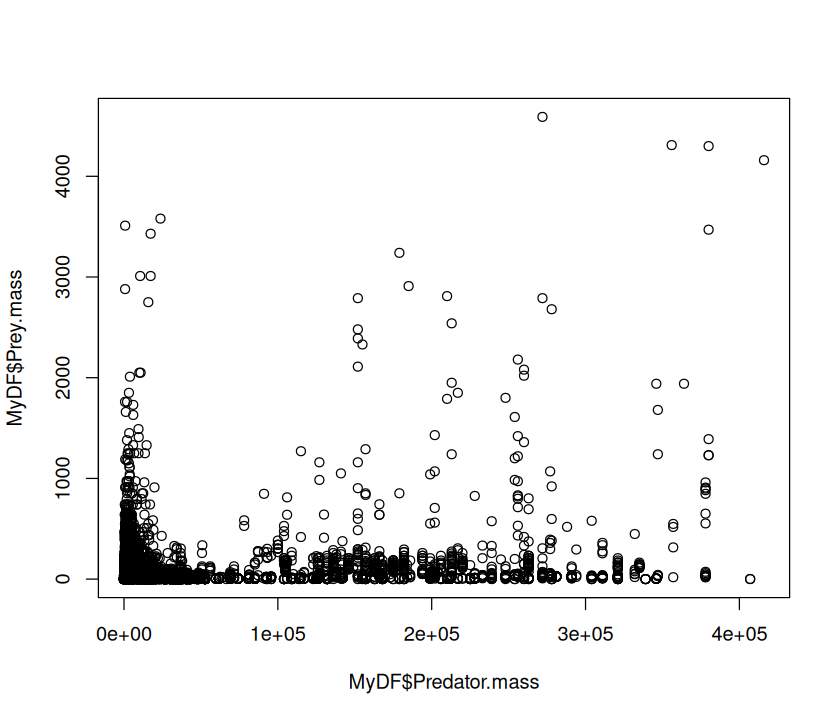

In [57]:
plot(MyDF$Predator.mass,MyDF$Prey.mass)

That doesn't look very meaningful! Let's try taking logarithms. *Why?* - Because body sizes across species tend to be log-normally distributed, with a lot of small species and a few large ones. Taking a log allows you to inspect the body size range in a meaningful (logarithmic) scale and reveals the true relationship. This also illustrates a important point. Just like statistical analyses, the effectiveness of data visualization too depends on the type of distribution of the data.

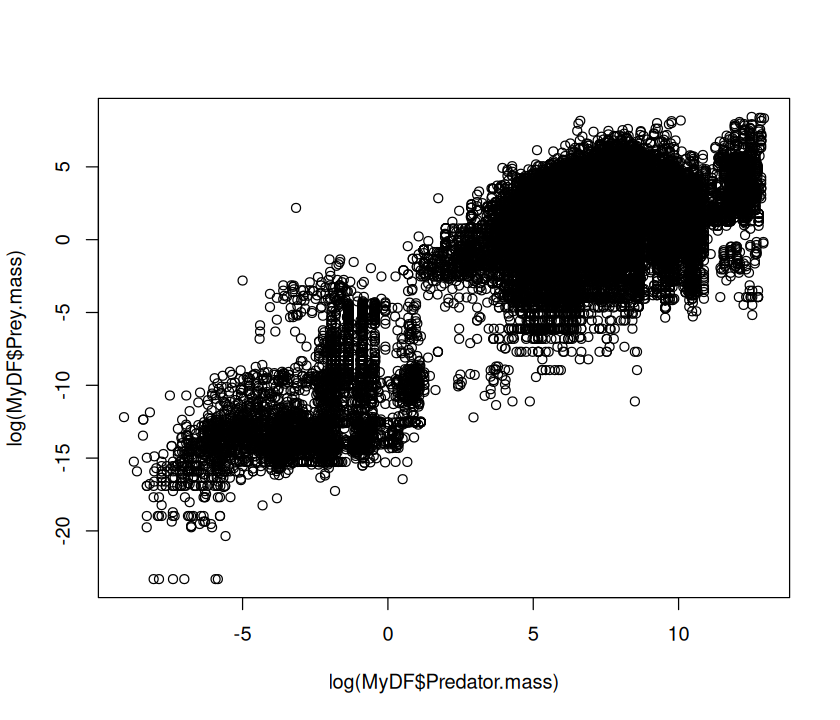

In [58]:
plot(log(MyDF$Predator.mass),log(MyDF$Prey.mass))

Let's look at the same using a base-10 log transform: 

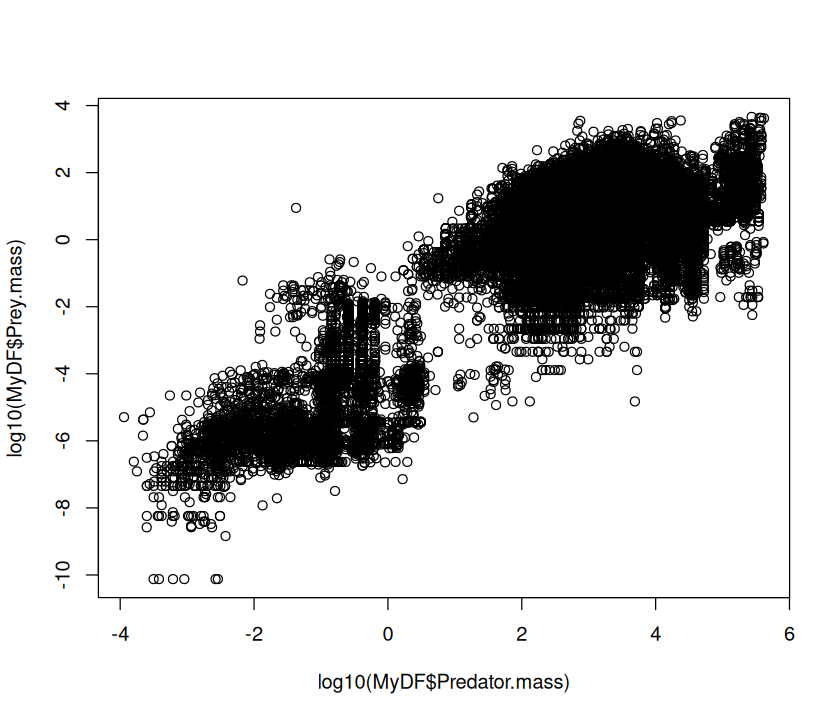

In [59]:
plot(log10(MyDF$Predator.mass),log10(MyDF$Prey.mass))

Using a `log10` transform is often a good idea because then you can see things in terms of "orders of magnitude", ($10^1$, $10^2$, $10^3$, etc), which makes it easier to determine  what the actual values in the original scale are.

We can change almost any aspect of the resulting graph; let's change the symbols by specifying the `p`lot `ch`aracters using `pch`:

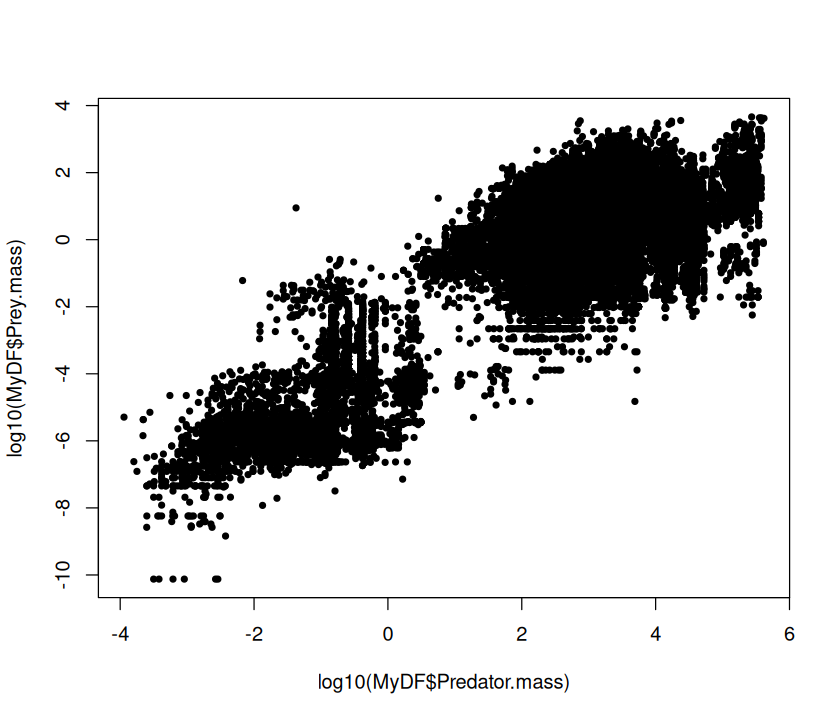

In [60]:
plot(log10(MyDF$Predator.mass),log10(MyDF$Prey.mass),pch=20) # Change marker

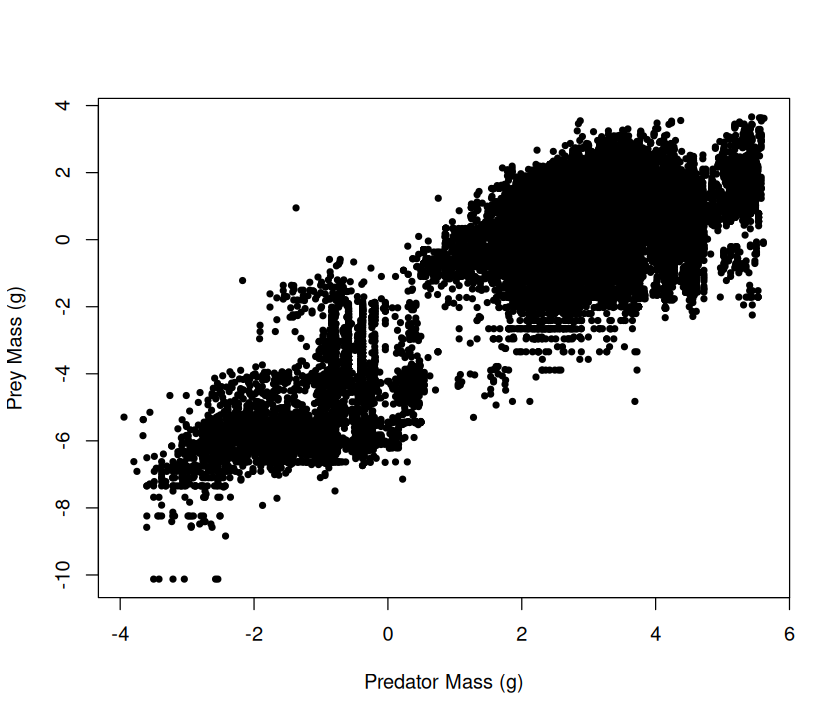

In [61]:
plot(log10(MyDF$Predator.mass),log10(MyDF$Prey.mass),pch=20, xlab = "Predator Mass (g)", ylab = "Prey Mass (g)") # Add labels

A really great summary of basic R graphical parameters can be [found here](https://www.statmethods.net/advgraphs/parameters.html).

### Histograms

Why did we have to take a logarithm to see the relationship between
predator and prey size? Plotting histograms of the two classes
(predator, prey) should be insightful, as we can then see the "marginal"
distributions of the two variables.

Let's first plot a histogram of predator body masses:

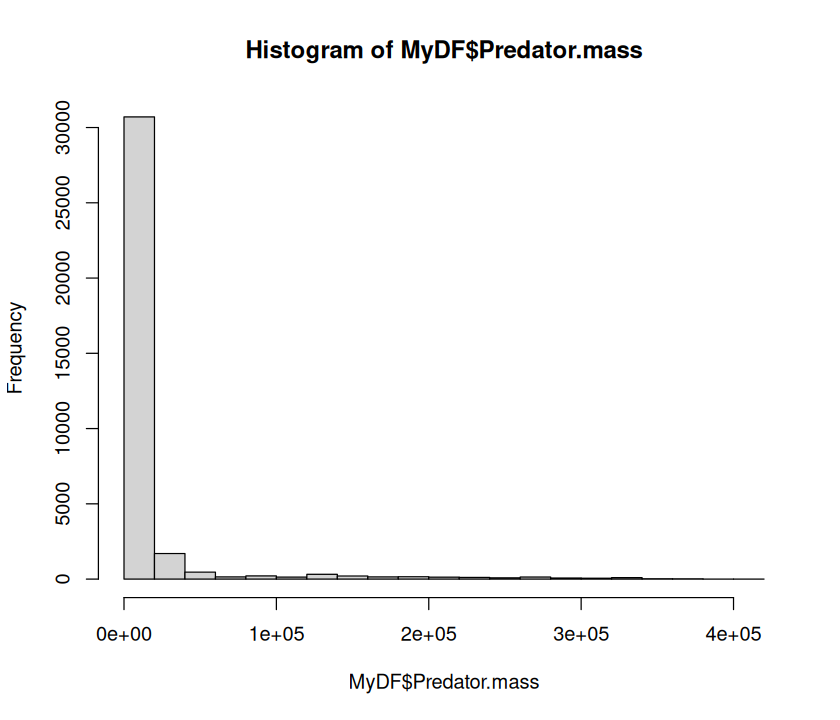

In [62]:
hist(MyDF$Predator.mass)

Clearly, the data are heavily right skewed, with small body sized organisms dominating (that's a general pattern, as mentioned above). Let's now take a logarithm and see if we can get a better idea of what the distribution of predator sizes looks like:

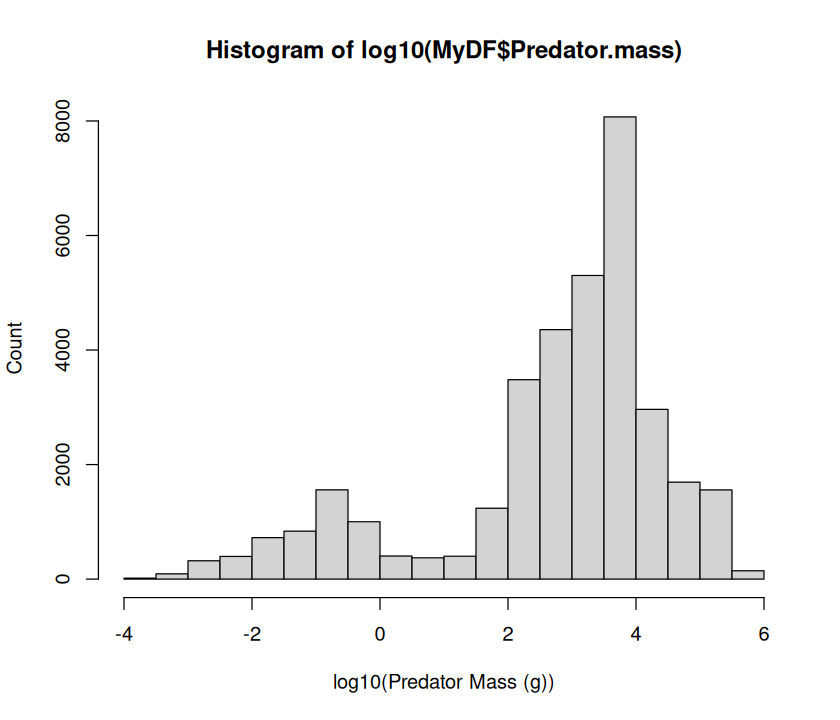

In [63]:
hist(log10(MyDF$Predator.mass), xlab = "log10(Predator Mass (g))", ylab = "Count") # include labels

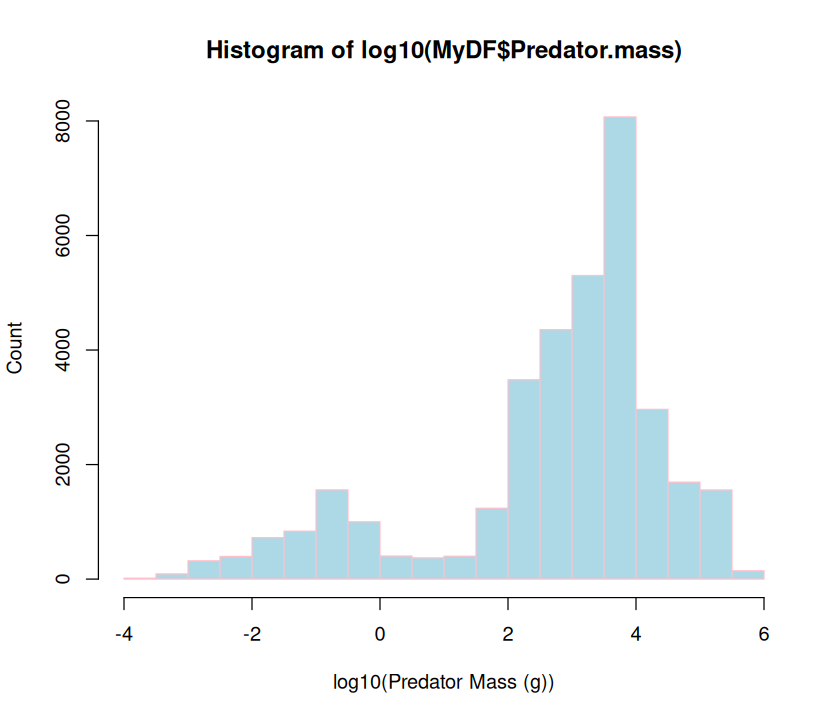

In [64]:
hist(log10(MyDF$Predator.mass),xlab="log10(Predator Mass (g))",ylab="Count", 
    col = "lightblue", border = "pink") # Change bar and borders colors 

So, taking a log really makes clearer what the distribution of body predator sizes looks like. *Try the same with prey body masses.*

$\star$ You can do a lot of beautification and fine-tuning of your R plots! As an exercise, try adjusting the histogram bin widths to make them same for the predator and prey, and making the x and y labels larger and in boldface. To get started, look at the help documentation of `hist`.

### Subplots

We can also plot both predator and prey body masses in different sub-plots using `par` so that we can compare them visually.

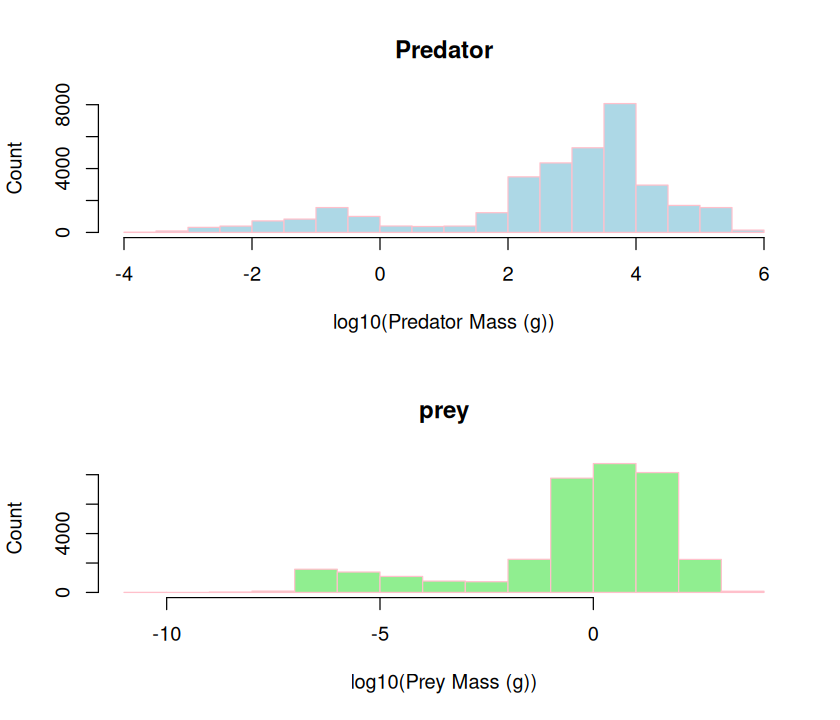

In [65]:
par(mfcol=c(2,1)) #initialize multi-paneled plot
par(mfg = c(1,1)) # specify which sub-plot to use first 
hist(log10(MyDF$Predator.mass),
    xlab = "log10(Predator Mass (g))", ylab = "Count", col = "lightblue", border = "pink", 
    main = 'Predator') # Add title
par(mfg = c(2,1)) # Second sub-plot
hist(log10(MyDF$Prey.mass), xlab="log10(Prey Mass (g))",ylab="Count", col = "lightgreen", border = "pink", main = 'prey')

The `par()` function can set multiple graphics parameters (not just multi-panel plots), including figure margins, axis labels, and more. Check out the [help for this function](https://www.rdocumentation.org/packages/graphics/versions/3.5.1/topics/par).

Another option for making multi-panel plots is the `layout` function.

### Overlaying plots

Better still, we would like to see if the predator mass and prey mass distributions are similar by overlaying them.

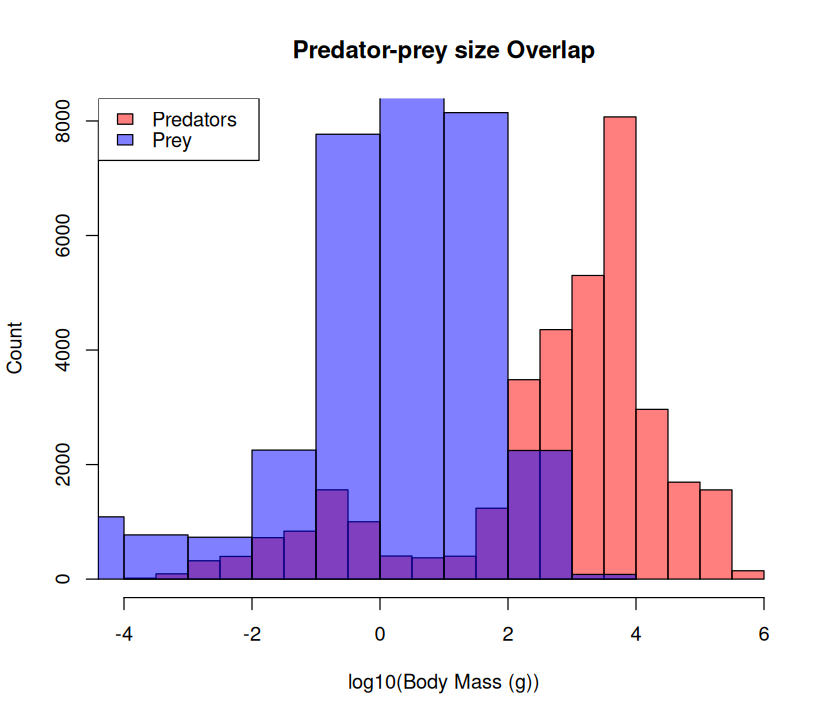

In [66]:
hist(log10(MyDF$Predator.mass), # Predator histogram
    xlab="log10(Body Mass (g))", ylab="Count", 
    col = rgb(1, 0, 0, 0.5), # Note 'rgb', fourth value is transparency
    main = "Predator-prey size Overlap") 
hist(log10(MyDF$Prey.mass), col = rgb(0, 0, 1, 0.5), add = T) # Plot prey
legend('topleft',c('Predators','Prey'),   # Add legend
    fill=c(rgb(1, 0, 0, 0.5), rgb(0, 0, 1, 0.5))) # Define legend colors

Plot annotation with text can be done with either single or double quotes, i.e., 'Plot Title' or "Plot Title", respectively. But it is  generally a good idea to use double quotes because sometimes you would like to use an apostrophe in your title or axis label strings.

&#9733; It would be nicer to have both the plots with the same bin sizes – try to do it

### Boxplots

Box plots are another way to show the distribution of data.  
They display the **median** as a solid horizontal line, and the **interquartile range (IQR)** as the box, which contains the middle 50% of the data.  
The **whiskers** typically extend to 1.5× the IQR on either side, and **outliers** beyond this range are shown as individual points. This provides a compact summary of how values are spread and centered.

![Boxplot](graphics/Boxplot.svg)

Although box plots may seem more *primitive* than histograms or kernel density estimates (KDEs), they are a very useful method of visualising data.  
While they show less detail than a full distribution plot (since they hide the shape of the data), they offer several advantages:

- Because box plots are small and simple, they allow for quick visual comparison between multiple datasets.  
- They are not influenced by the choice of bin width (as histograms are) or bandwidth (as Kernal density estimations are).  
- They provide a quick visual summary of variability and potential outliers.


<p align="center">
  ```{image} ./graphics/Boxplot_vs_PDF.svg
:width: 500px
```
</p>


Now, let’s try plotting box plots instead of histograms to explore how they summarise data differently.

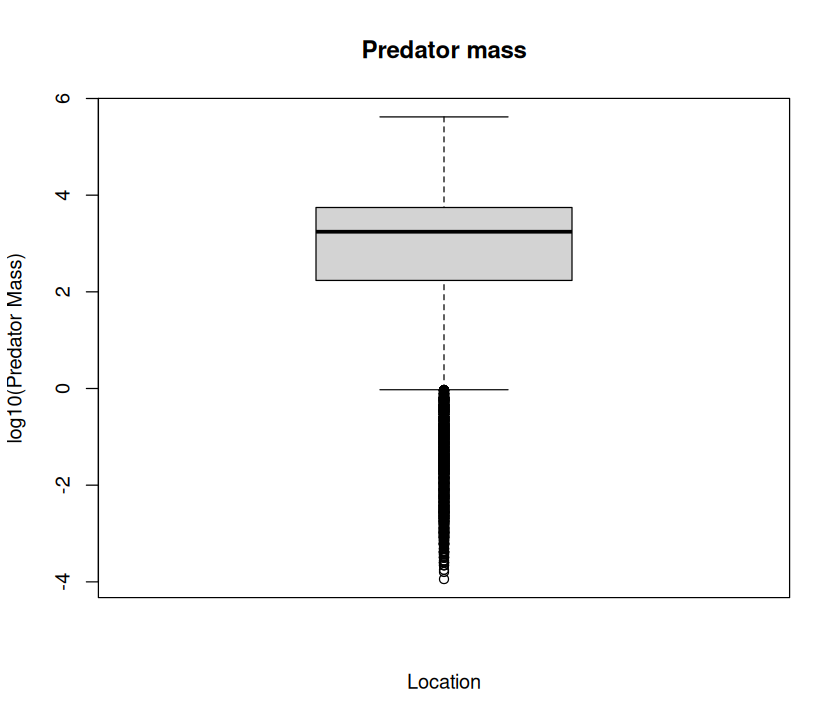

In [67]:
boxplot(log10(MyDF$Predator.mass), xlab = "Location", ylab = "log10(Predator Mass)", main = "Predator mass")

Now let's see how many locations the data are from:

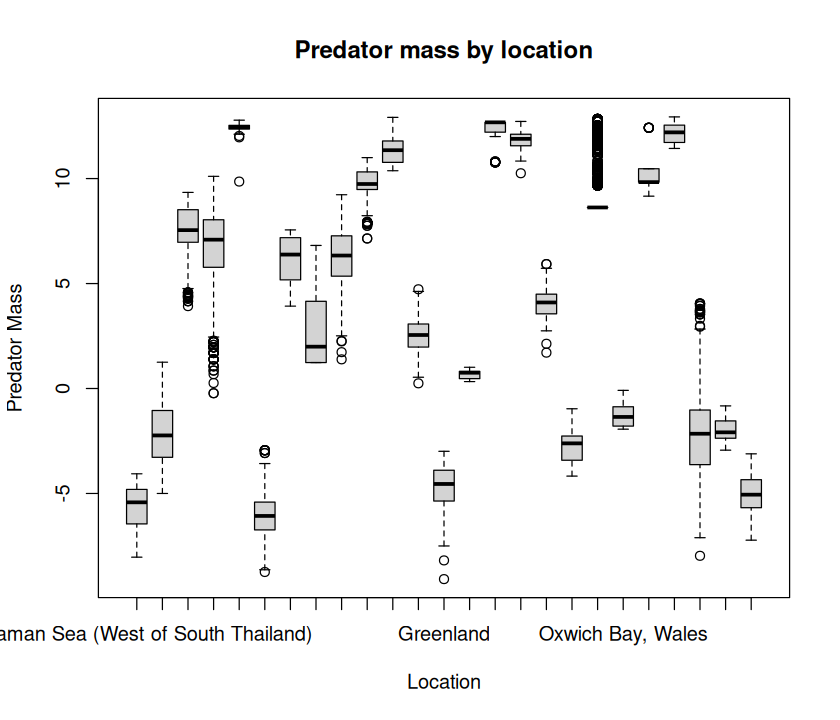

In [68]:
boxplot(log(MyDF$Predator.mass) ~ MyDF$Location, # Why the tilde?
    xlab = "Location", ylab = "Predator Mass",
    main = "Predator mass by location")

Note the tilde (`~`). This is to tell R to subdivide or categorize your analysis and plot by the "Factor" location. More on this later.

That's a lot of locations! You will need an appropriately wide plot to see all the boxplots adequately. Now let's try boxplots by feeding interaction type:

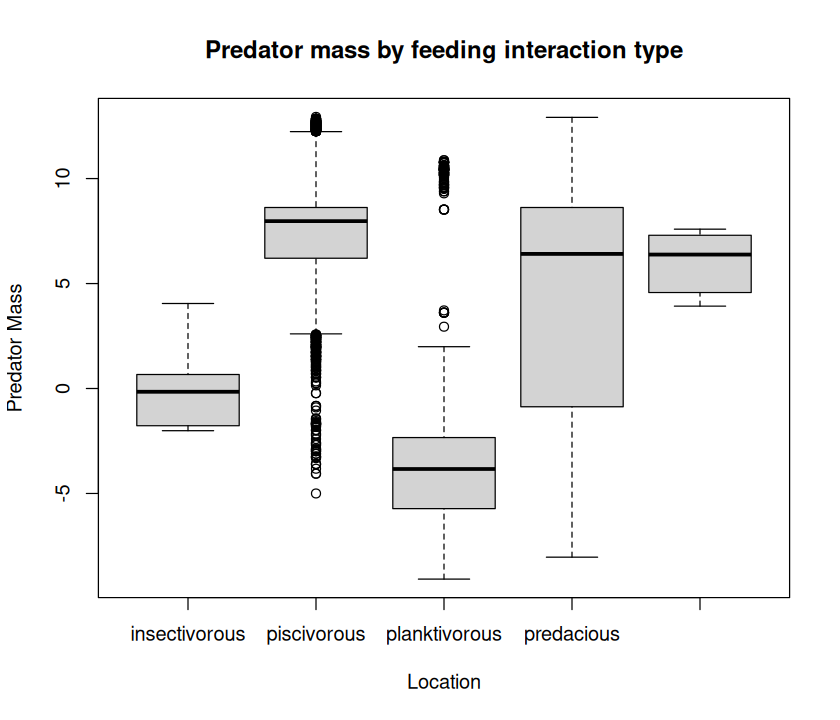

In [69]:
boxplot(log(MyDF$Predator.mass) ~ MyDF$Type.of.feeding.interaction,
    xlab = "Location", ylab = "Predator Mass",
    main = "Predator mass by feeding interaction type")

### Combining plot types

It would be nice to see both the predator and prey (marginal) distributions as well as the scatterplot for an exploratory analysis. We can do this by adding boxplots of the marginal variables to the scatterplot.

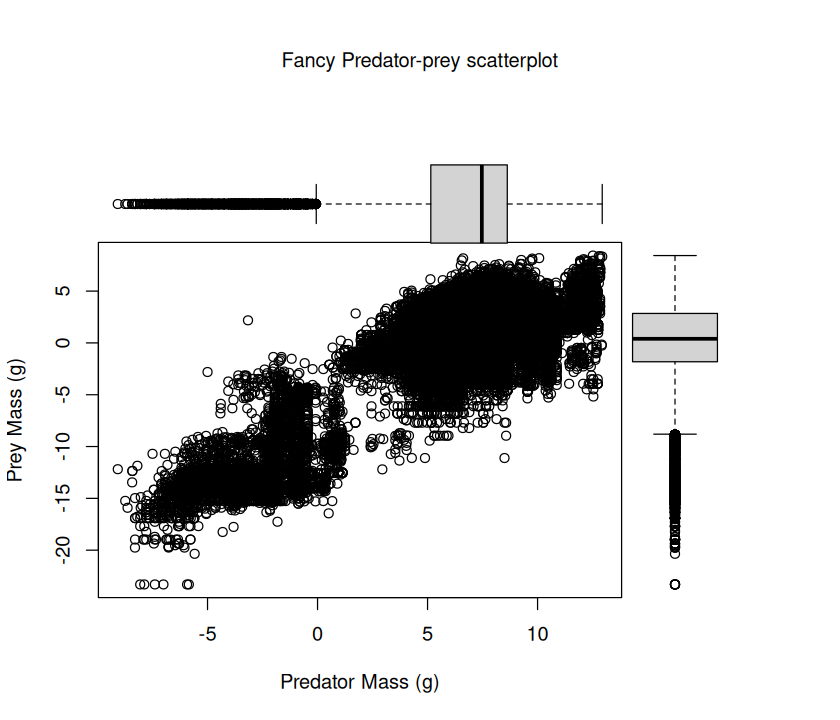

In [70]:
 par(fig=c(0,0.8,0,0.8)) # specify figure size as proportion
 plot(log(MyDF$Predator.mass),log(MyDF$Prey.mass), xlab = "Predator Mass (g)", ylab = "Prey Mass (g)") # Add labels
 par(fig=c(0,0.8,0.4,1), new=TRUE)
 boxplot(log(MyDF$Predator.mass), horizontal=TRUE, axes=FALSE)
 par(fig=c(0.55,1,0,0.8),new=TRUE)
 boxplot(log(MyDF$Prey.mass), axes=FALSE)
 mtext("Fancy Predator-prey scatterplot", side=3, outer=TRUE, line=-3)

To understand this plotting method, think of the full graph area as going from (0,0) in the lower left corner to (1,1) in the upper right corner. The format of the `fig=` parameter is a numerical vector of the form `c(x1, x2, y1, y2)`, corresponding to `c(bottom, left, top, right)`. First, ` par(fig=c(0,0.8,0,0.8))` sets up the scatterplot going from 0 to 0.8 on the x axis and 0 to 0.8 on the y axis, leaving some area for the boxplots at the top and right. The top boxplot goes from 0 to 0.8 on the x axis and 0.4 to 1 on the y axis. The right hand boxplot goes from 0.55 to 1 on the x axis and 0 to 0.8 on the y axis. You can experiment with these proportions to change the spacings between plots.

This plot is useful, because it shows you what the marginal distributions of the two variables (Predator mass and Prey mass) are. 


Below you will learn to use `ggplot` to produce a much more elegant, pretty multi-panel plots. 


### Saving your graphics

And you can also save the figure in a vector graphics format like a pdf. It is important to learn to do this, because you want to be able to save your plots in good resolution, and want to avoid the manual steps of
clicking on the figure, doing "save as", etc. So let's save the figure as a PDF:

In [71]:
pdf("../results/Pred_Prey_Overlay.pdf", # Open blank pdf page using a relative path
    11.7, 8.3) # These numbers are page dimensions in inches
hist(log(MyDF$Predator.mass), # Plot predator histogram (note 'rgb')
    xlab="Body Mass (g)", ylab="Count", col = rgb(1, 0, 0, 0.5), main = "Predator-Prey Size Overlap") 
hist(log(MyDF$Prey.mass), # Plot prey weights
    col = rgb(0, 0, 1, 0.5), 
    add = T)  # Add to same plot = TRUE
legend('topleft',c('Predators','Prey'), # Add legend
    fill=c(rgb(1, 0, 0, 0.5), rgb(0, 0, 1, 0.5))) 
graphics.off(); #you can also use dev.off() 

Always try to save results in a vector format, which can be scaled up to any size. For more on vector vs raster images/graphics, [see this](https://en.wikipedia.org/wiki/Vector_graphics).

Note that you are saving to the `results` directory now. This is a recommended project organization and workflow: store and retrieve data from a `
Data` directory, keep your code and work from a `Code` directory, and save outputs to a `results` directory.

You can also try other graphic output formats. For example, `png()` (a raster format) instead of `pdf()`. As always, look at the help documentation of each of these commands!

## Practicals

### Body mass distributions

Write a script that draws and saves three figures, each containing subplots of distributions of predator mass, prey mass, and the size ratio of prey mass over predator mass *by feeding interaction type*. Use logarithms of masses (or size ratios)for all three plots. In addition, the script should calculate the (log) mean and median predator mass, prey mass and predator-prey size-ratios to a csv file.

Call the script `PP_Dists.R` and save it in the `Code` directory — sourcing or running this script should result in three files called `Pred_Subplots.pdf`, ` Prey_Subplots.pdf`, and `SizeRatio_Subplots.pdf` (the names should be self-explanatory), and a single csv file `PP_Results.csv` containing the mean and median log predator mass, prey mass, and predator-prey size ratio, by feeding type. The csv file should have appropriate headers (e.g., Feeding type, Mean, Median). (Hint: you will have to initialize a new dataframe or matrix in the script to first store the calculations)

The script should be self-sufficient and not need any external inputs. It should import the above predator-prey dataset from the appropriate directory, and save the graphic plots to the appropriate directory (Hint: use relative paths!).

Use the `par()` function to create the subplots. For calculating the body size statistics by feeding type, you can either use the "loopy" way — first obtaining a list of feeding types (look up the `unique` or `levels` functions) and then loop over them, using `subset` to extract the dataset by feeding type at each iteration, or the R-savvy way, by using `tapply` or `ddply` and avoiding looping altogether. You can also use tidyverse and `dplyr` for the data manipulations.

## Beautiful graphics in R

R can produce beautiful visualizations, but it typically takes a lot of work to obtain the desired result. This is because the starting point is pretty much a "bare" plot, and adding features commonly required for publication-grade figures (legends, statistics, regressions, sub-plotting etc.) can require a lot of small and painful additional arguments to the plotting commands *at the same time*, or even additional steps (such as the [fancy predator-prey scatterplot](#Combining-plot-types) above).

Moreover, it is very difficult to switch from one representation of the data to another (i.e., from boxplots to scatterplots), or to plot several datasets together. The R package `ggplot2` overcomes these issues, and produces truly high-quality, publication-ready graphics suitable for papers, theses and reports.

```{note}
**3D plots:** *Currently, `ggplot2` cannot be used to create 3D graphs or mosaic plots (but [see this](https://www.tylermw.com/3d-ggplots-with-rayshader)). In any case, most of you won't be needing 3D plots. If you do, there are many ways to do 3D plots using other plotting packages in R. In particular, look up the `scatterplot3d` and `plot3D` packages.*
```

`ggplot2` differs from other approaches as it attempts to provide a "grammar" for graphics in which each layer is the equivalent of a verb, subject etc. and a plot is the equivalent of a sentence. All graphs start with a layer showing the data, other layers and attributes/styles are added to modify the plot. Specifically, according to this grammar, a statistical graphic is a "mapping" from data to geometric objects (points, lines, bars; set using `geom`) with aesthetic attributes (colour, shape, size; set using `aes`).

For more on the ideas underlying ggplot, see the book "ggplot2: Elegant Graphics for Data Analysis", by H. Wickham (in your Reading directory). Also, the [ggplot2 website](http://ggplot2.tidyverse.org/) is an excellent resource.

If `ggplot2` is not available on your computer, look up the section on installing packages in the [R Chapter](R.ipynb).

ggplot can be used in two ways: with `qplot` (for `q`uick ` plot`ting) and `ggplot` for fully customized plotting.

*Note that `ggplot2` only accepts data in data frames.*

### Quick plotting with `qplot`

`qplot` can be used to quickly produce graphics for exploratory data analysis, and as a base for more complex graphics. It uses syntax that is closer to the standard R plotting commands.

We will use the same predator-prey body size dataset again – you will soon see how much nice the same types of plots you made above look when done with ggplot!

First, load the package:

In [72]:
require(ggplot2)

#### Scatterplots

Let's start plotting the `Predator.mass` vs `Prey.mass`:

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


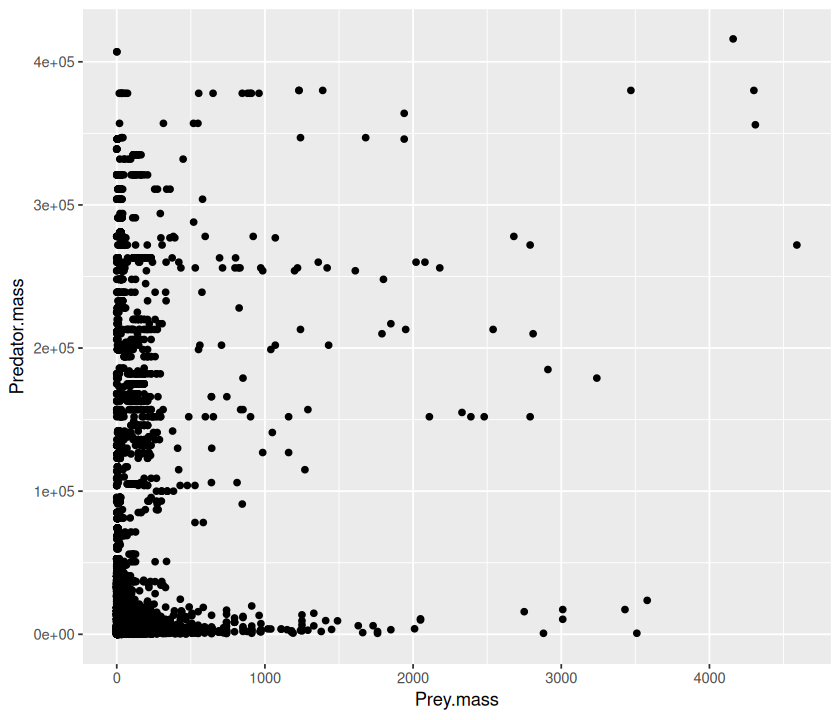

In [73]:
qplot(Prey.mass, Predator.mass, data = MyDF)

As before, let's take logarithms and plot:

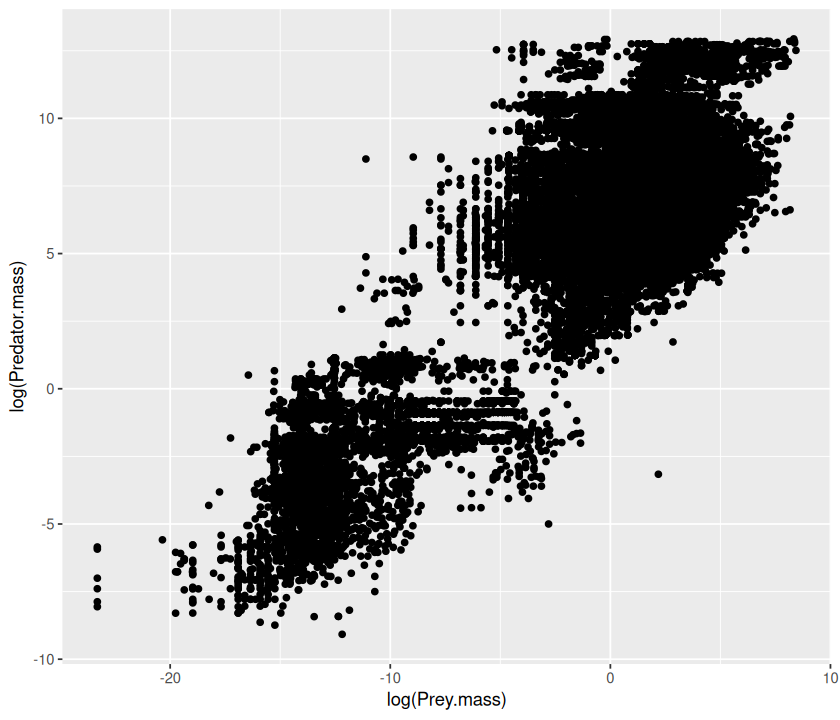

In [74]:
qplot(log(Prey.mass), log(Predator.mass), data = MyDF)

Now, color the points according to the type of feeding interaction:

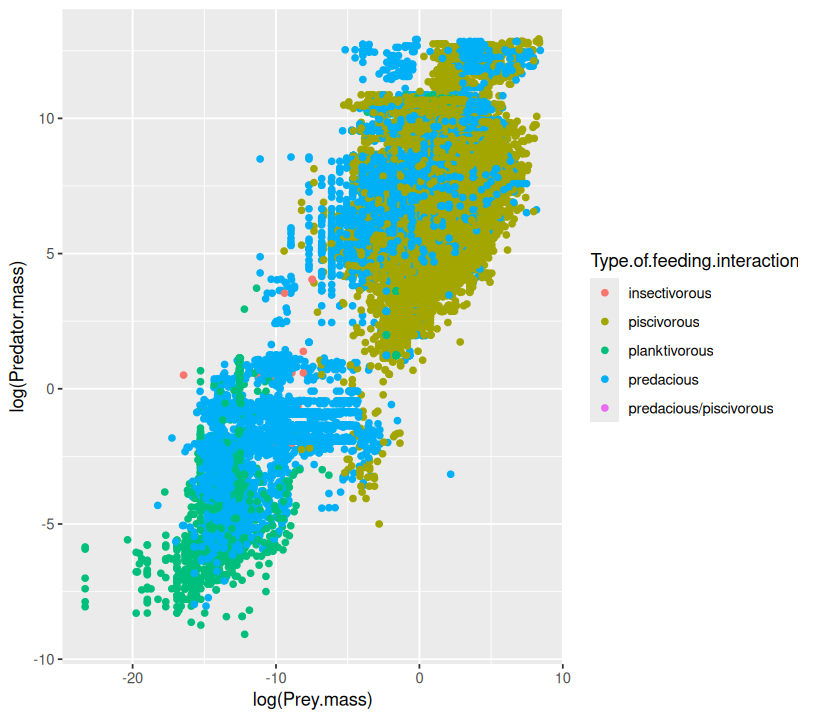

In [75]:
qplot(log(Prey.mass), log(Predator.mass), data = MyDF, colour = Type.of.feeding.interaction)

But the figure's aspect ratio is not very nice. Let's change it using the `asp` option:

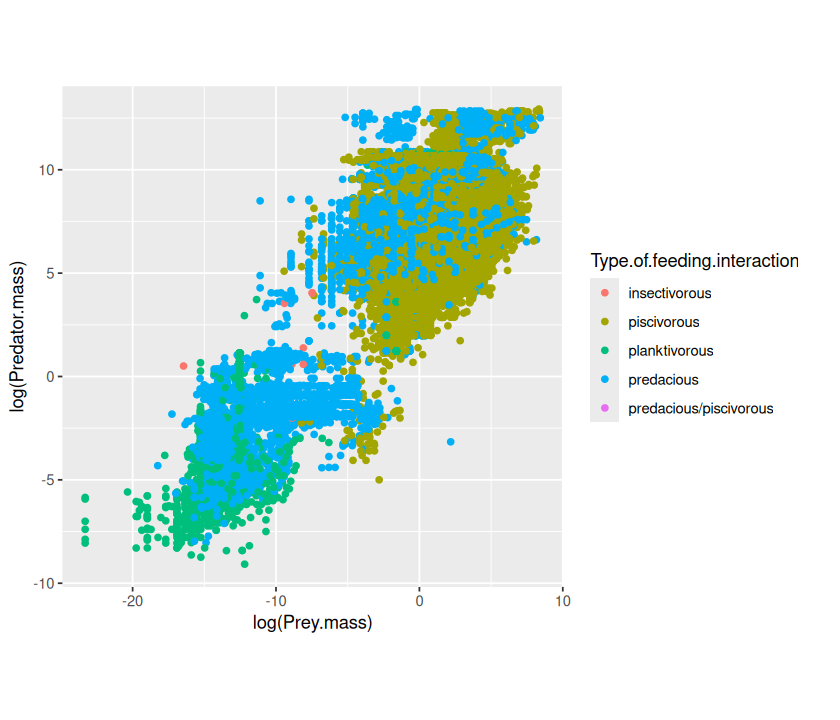

In [76]:
qplot(log(Prey.mass), log(Predator.mass), data = MyDF, colour = Type.of.feeding.interaction, asp = 1)

The same as above, but changing the shape:

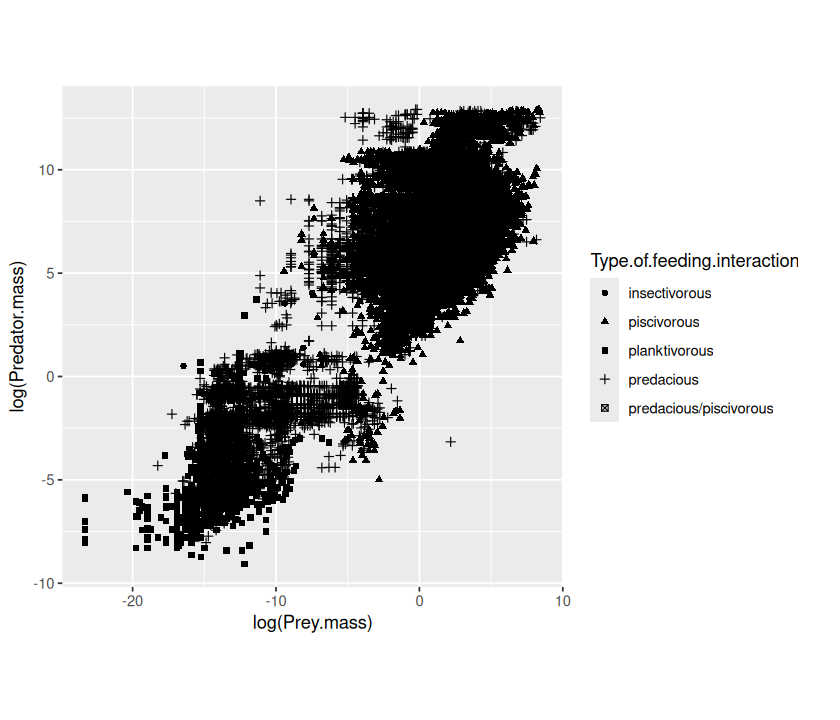

In [77]:
qplot(log(Prey.mass), log(Predator.mass), data = MyDF, shape = Type.of.feeding.interaction, asp = 1)

#### Aesthetic mappings

These examples demonstrate a key difference between `qplot` (and indeed, ggplot2's approach) and the standard `plot` command: When you want to assign colours, sizes or shapes to the points on your plot, using the `plot` command, it's your responsibility to convert (i.e., "map") a categorical variable in your data (e.g., type of feeding interaction in the above case) onto colors (or shapes) that `plot` knows how to use (e.g., by specifying "red", "blue", "green", etc).

ggplot does this mapping for you automatically, and also provides a legend! This makes it really easy to quickly include additional data (e.g., if a new feeding interaction type was added to the data) on the plot.

Instead of using ggplot's automatic mapping, if you want to manually set a color or a shape, you have to use `I()` (meaning "Identity"). To see this in practice, try the following:

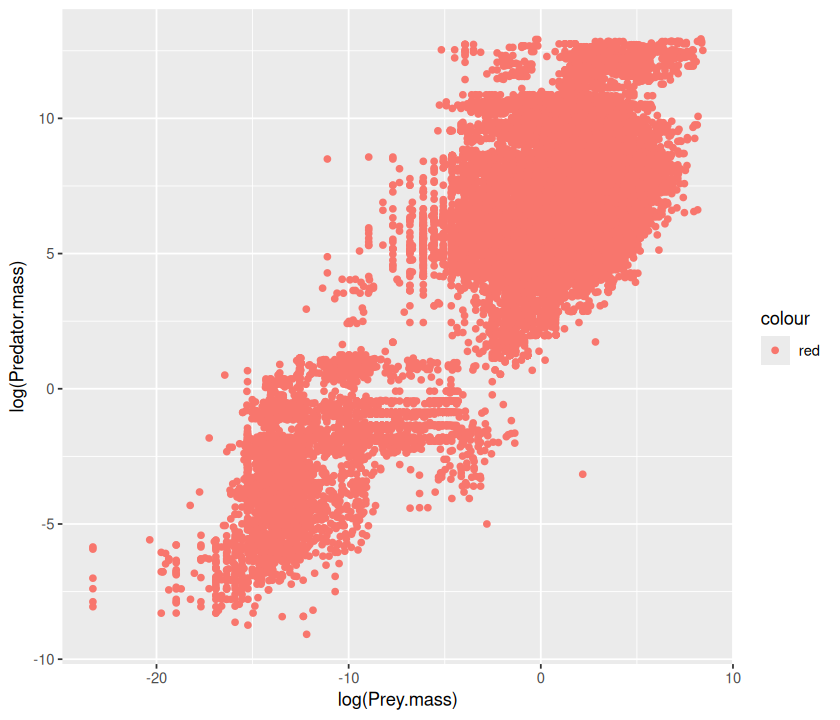

In [78]:
qplot(log(Prey.mass), log(Predator.mass), 
    data = MyDF, colour = "red")

You chose red, but ggplot used mapping to convert it to a particular
shade of red. To set it manually to the real red, do this:

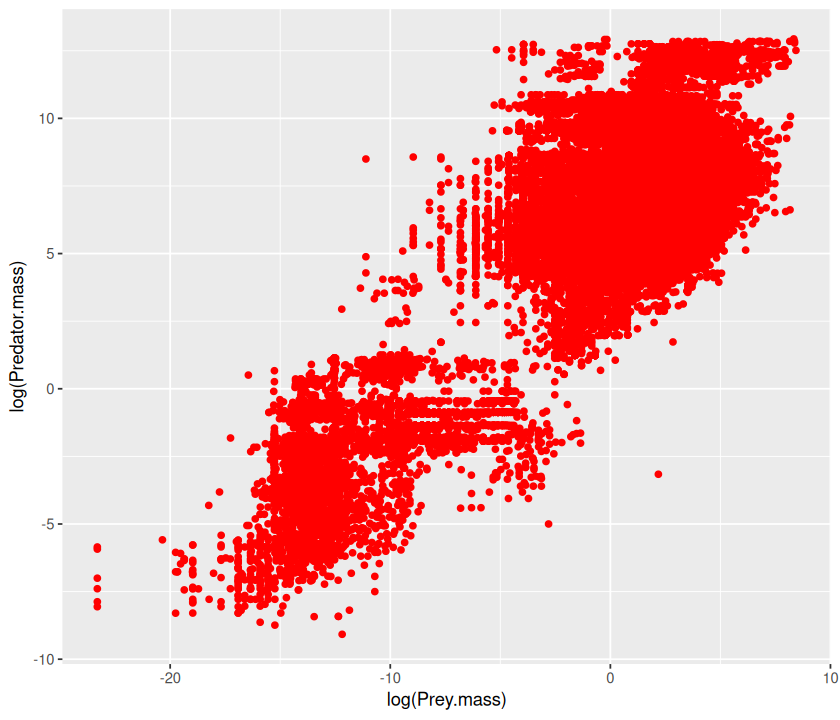

In [79]:
qplot(log(Prey.mass), log(Predator.mass), data = MyDF, colour = I("red"))

Similarly, for point size, compare these two:

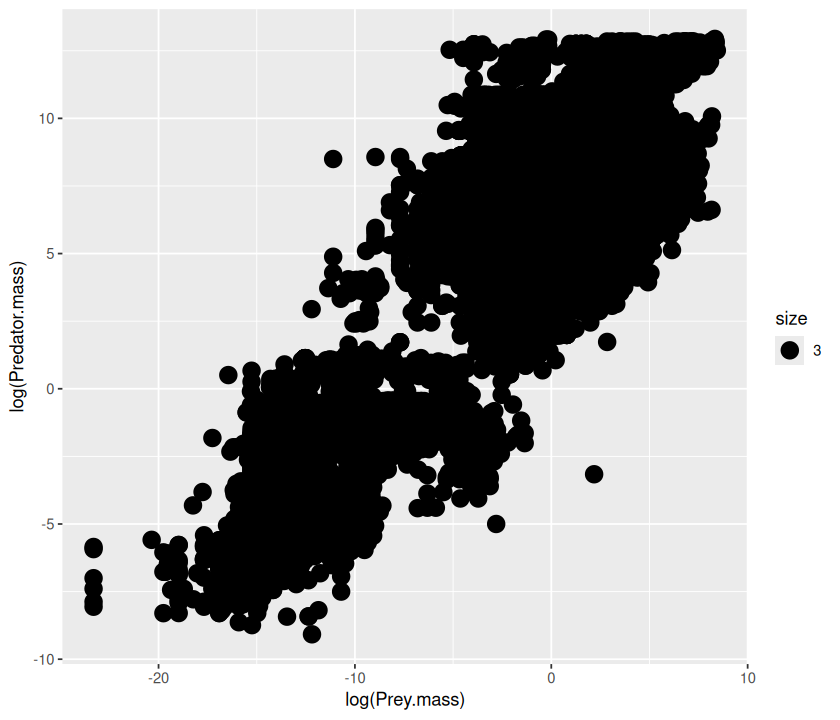

In [80]:
qplot(log(Prey.mass), log(Predator.mass), data = MyDF, size = 3) #with ggplot size mapping

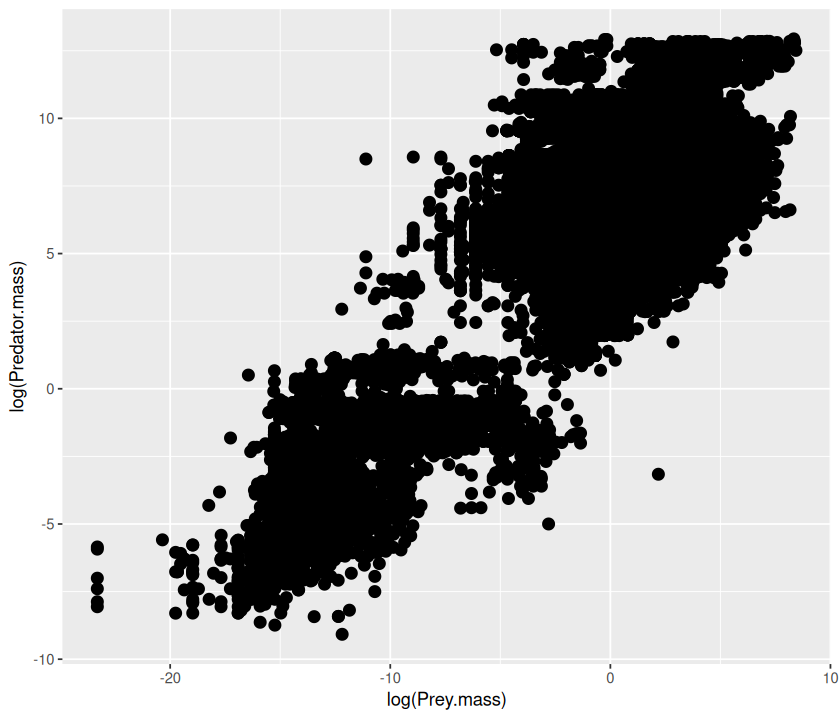

In [81]:
qplot(log(Prey.mass), log(Predator.mass),  data = MyDF, size = I(3)) #no mapping

But for shape, ggplot doesn't have a continuous mapping because shapes are a discrete variable.So

```r
qplot(log(Prey.mass), log(Predator.mass), data = MyDF, shape = 3)
```
will give an error.

Instead, try this: 

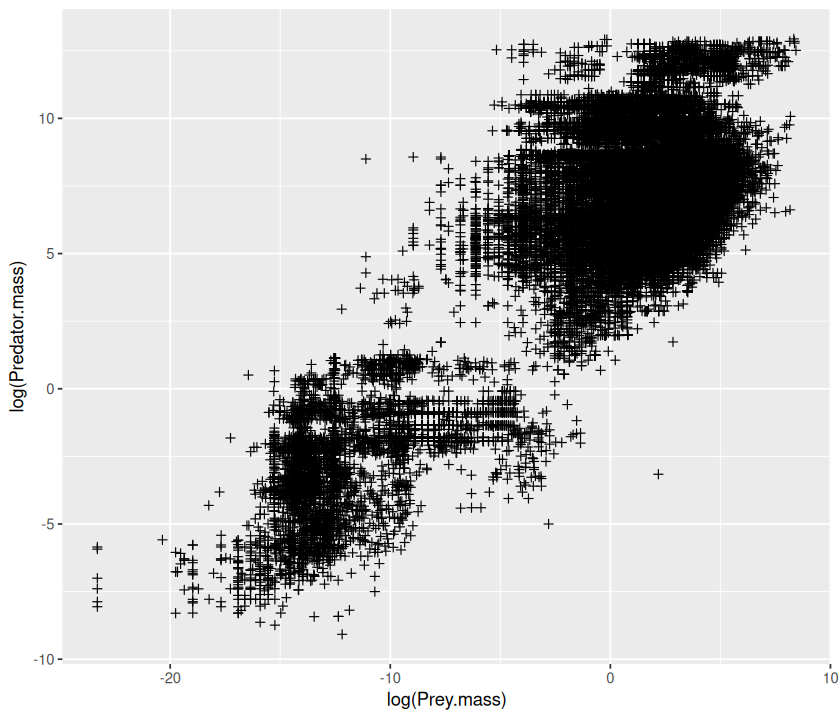

In [82]:
qplot(log(Prey.mass), log(Predator.mass), data = MyDF, shape= I(3))

#### Setting transparency

Because there are so many points, we can make them semi-transparent using `alpha` so that the overlaps can be seen:

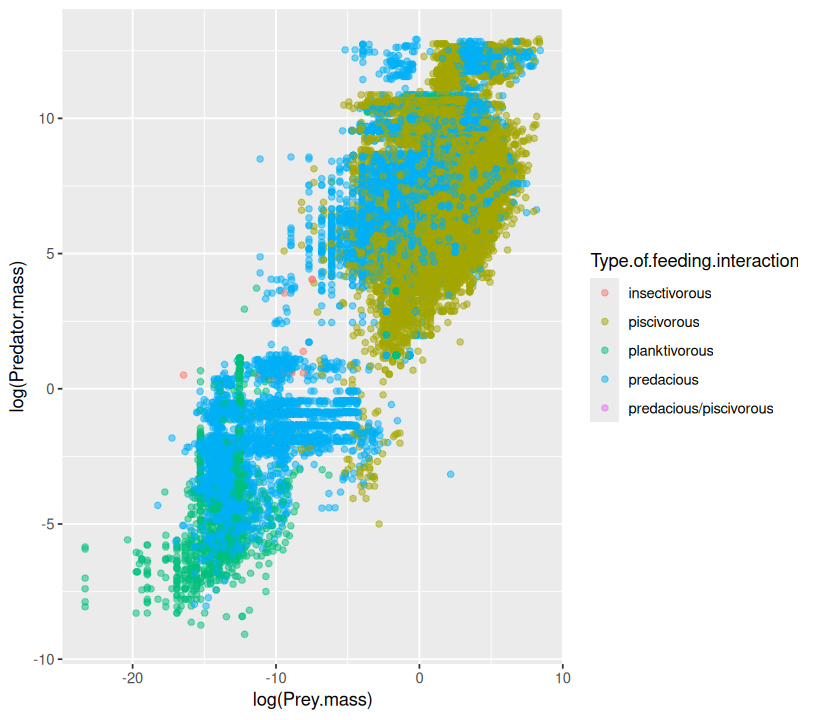

In [83]:
qplot(log(Prey.mass), log(Predator.mass), data = MyDF, colour = Type.of.feeding.interaction, alpha = I(.5))

Here, try using `alpha = .5` instead of `alpha = I(.5)` and see what happens.

#### Adding smoothers and regression lines

Now add a smoother to the points:

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


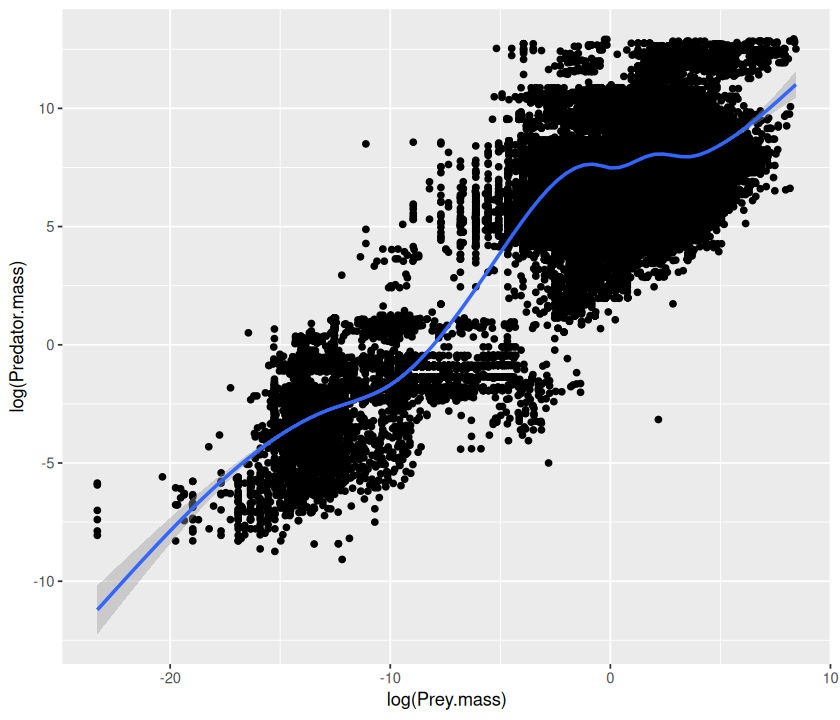

In [84]:
qplot(log(Prey.mass), log(Predator.mass), data = MyDF, geom = c("point", "smooth"))

If we want to have a linear regression, we need to specify the method as
being `lm`:

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using formula = 'y ~ x'


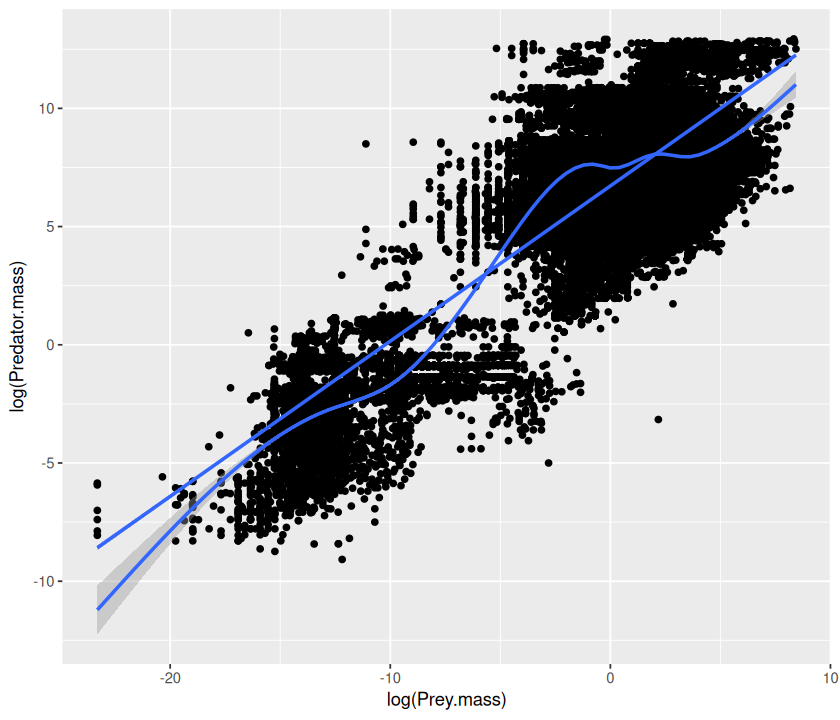

In [85]:
qplot(log(Prey.mass), log(Predator.mass), data = MyDF, geom = c("point", "smooth")) + geom_smooth(method = "lm")

`lm` stands for `l`inear `m`odels. Linear regression is a type of linear model. More on this in the [BASIC DATA ANALYSES AND STATISTICS](../Stats-Intro.md) section of these notes.  

We can also add a "smoother" for each type of interaction:

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using formula = 'y ~ x'


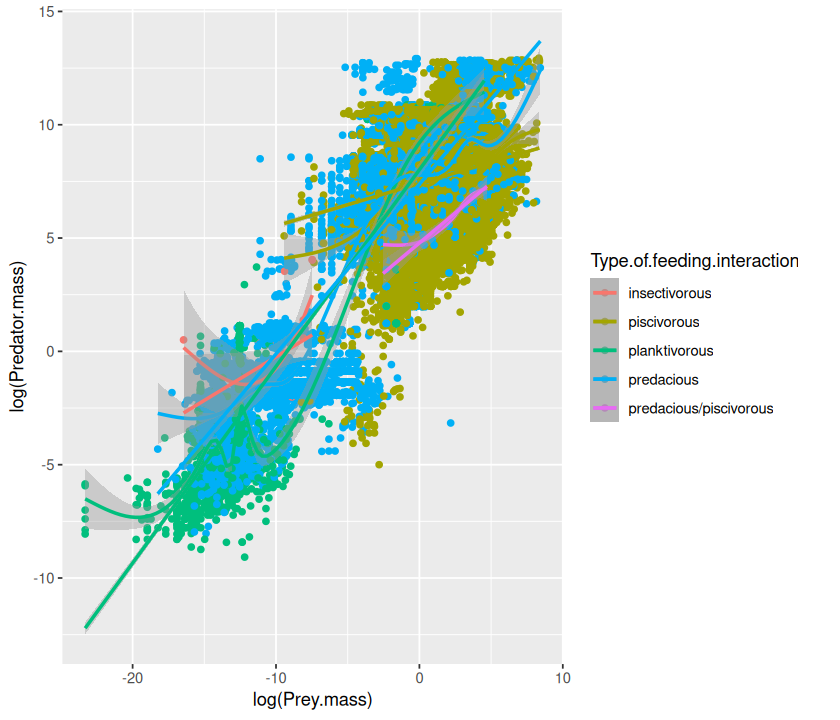

In [86]:
qplot(log(Prey.mass), log(Predator.mass), data = MyDF, geom = c("point", "smooth"), 
      colour = Type.of.feeding.interaction) + geom_smooth(method = "lm")

To extend the lines to the full range, use `fullrange = TRUE`:

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using formula = 'y ~ x'


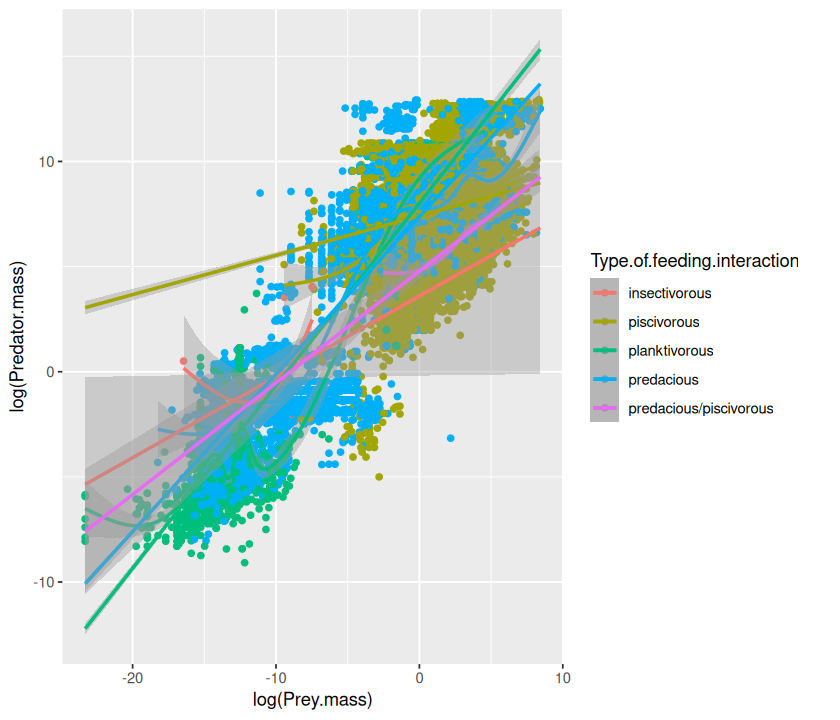

In [87]:
qplot(log(Prey.mass), log(Predator.mass), data = MyDF, geom = c("point", "smooth"),
      colour = Type.of.feeding.interaction) + geom_smooth(method = "lm",fullrange = TRUE)

Now let's see how the ratio between prey and predator mass changes according to the type of interaction:

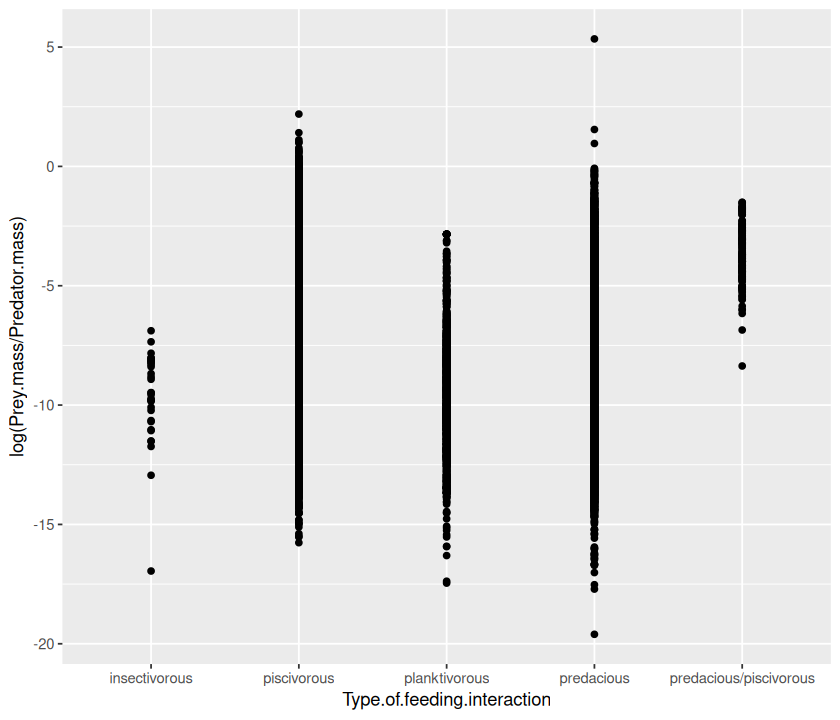

In [88]:
qplot(Type.of.feeding.interaction, log(Prey.mass/Predator.mass), data = MyDF)

Because there are so many points, we can "jitter" them to get a better
idea of the spread:

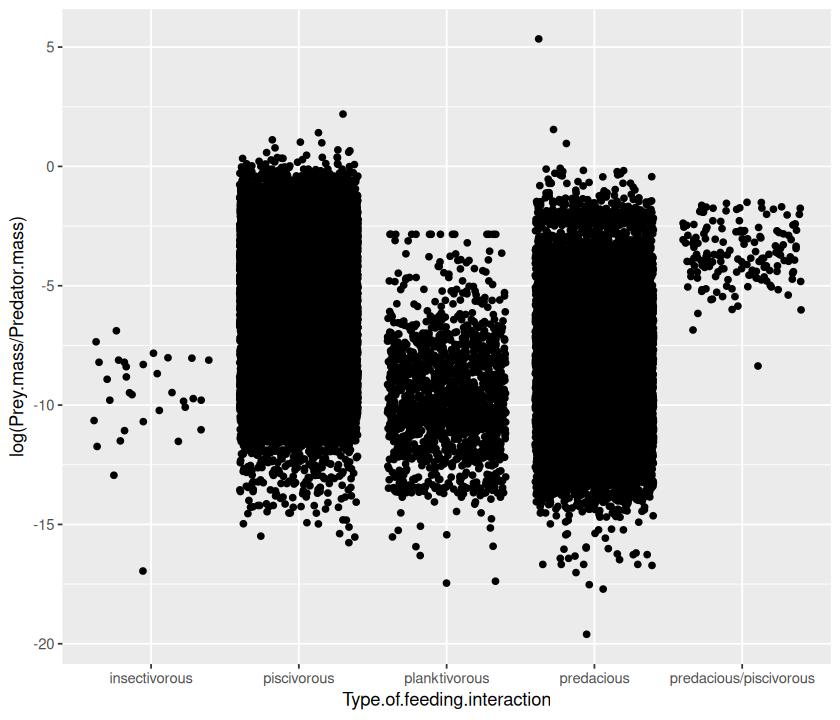

In [89]:
qplot(Type.of.feeding.interaction, log(Prey.mass/Predator.mass), data = MyDF, geom = "jitter")

#### Boxplots

Or we can draw a boxplot of the data (note the `geom` argument, which stands for `geom`etry):

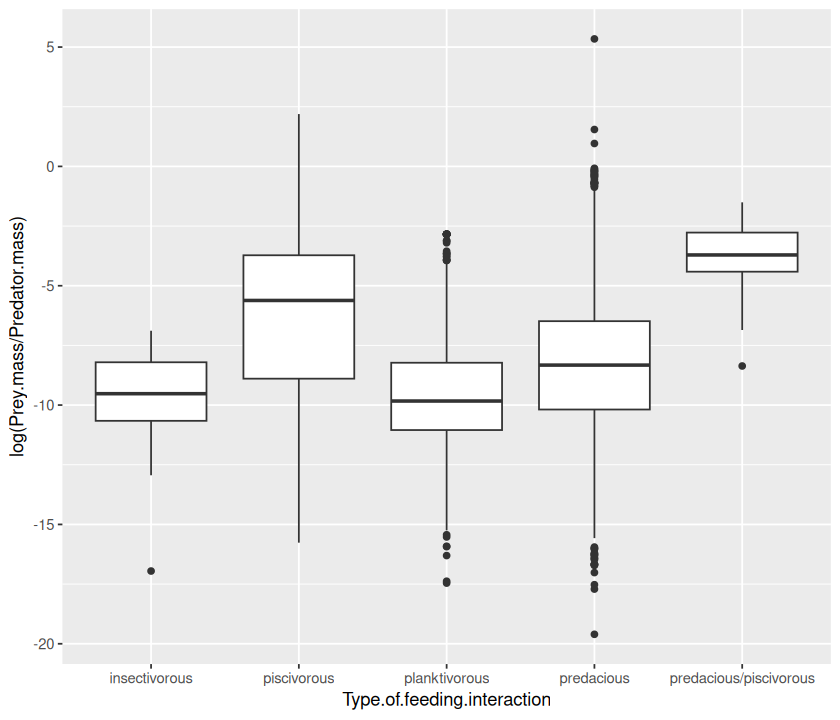

In [90]:
qplot(Type.of.feeding.interaction, log(Prey.mass/Predator.mass), data = MyDF, geom = "boxplot")

#### Histograms and density plots

Now let's draw an histogram of predator-prey mass ratios:

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


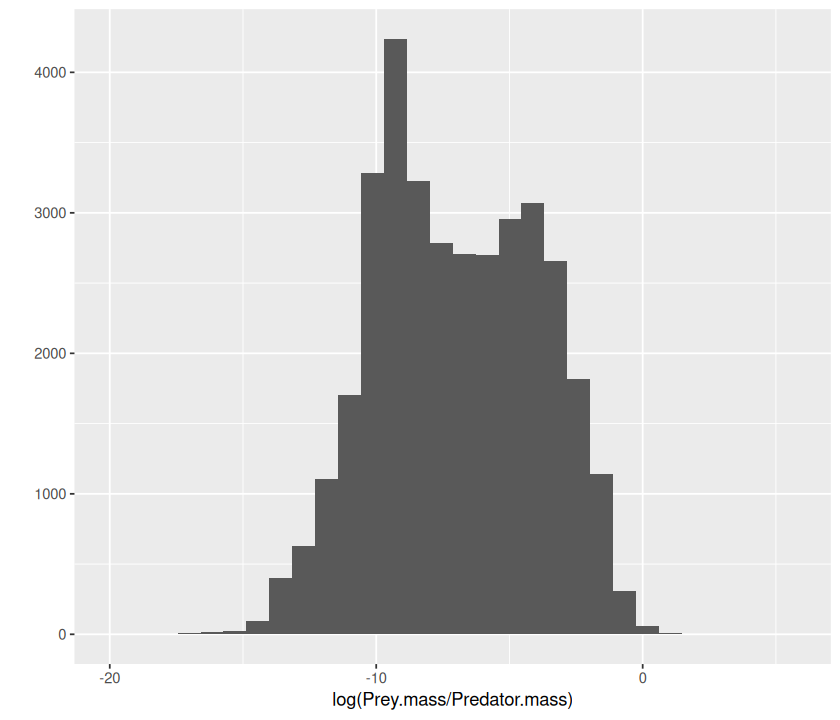

In [91]:
qplot(log(Prey.mass/Predator.mass), data = MyDF, geom =  "histogram")

Color the histogram according to the interaction type:

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


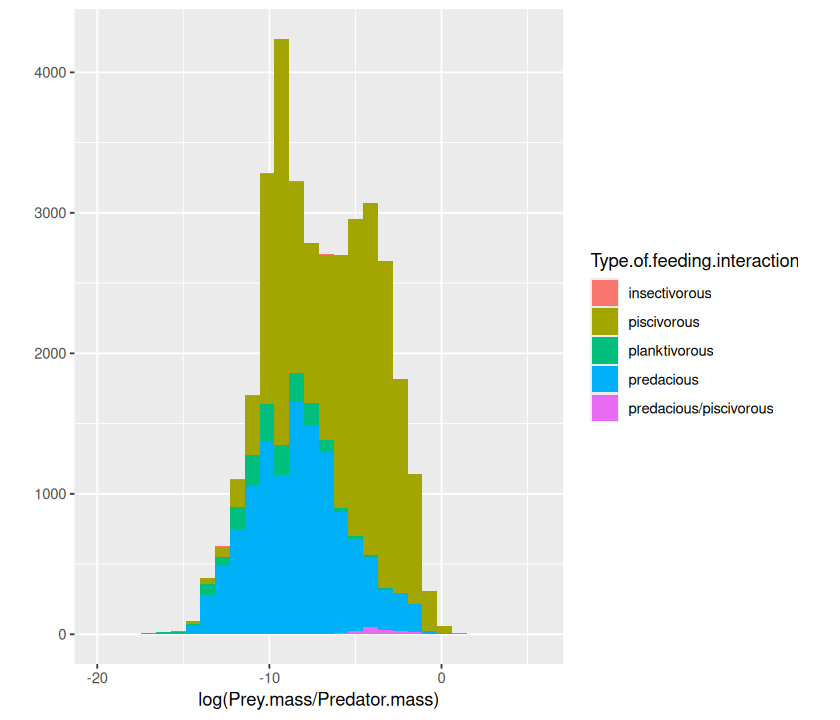

In [92]:
qplot(log(Prey.mass/Predator.mass), data = MyDF, geom =  "histogram", 
      fill = Type.of.feeding.interaction)

You can also define your own  bin widths (in units of the x axis):

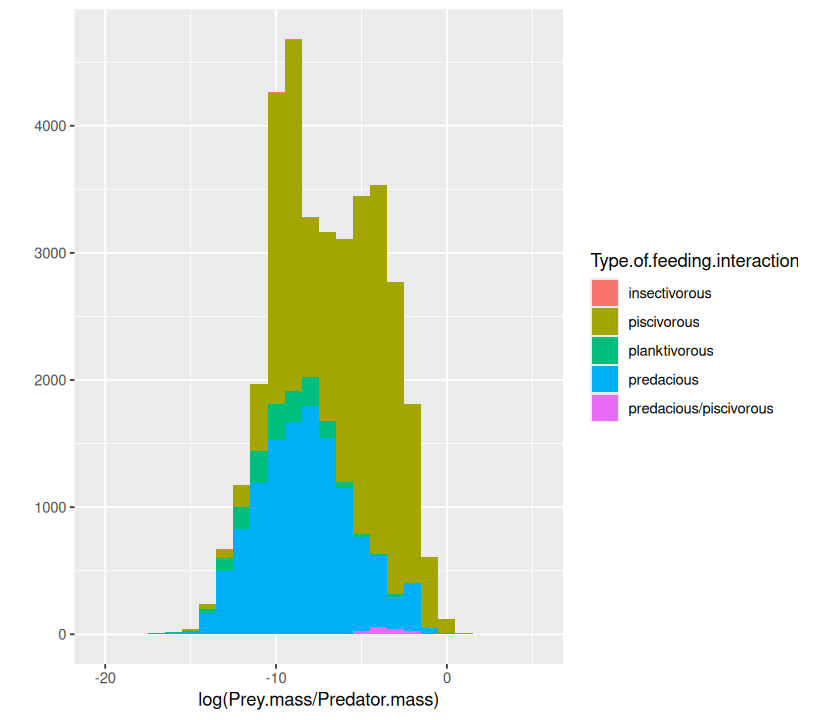

In [93]:
qplot(log(Prey.mass/Predator.mass), data = MyDF, geom =  "histogram", 
      fill = Type.of.feeding.interaction, binwidth = 1)

To make it easier to read, we can plot the smoothed density of the data:

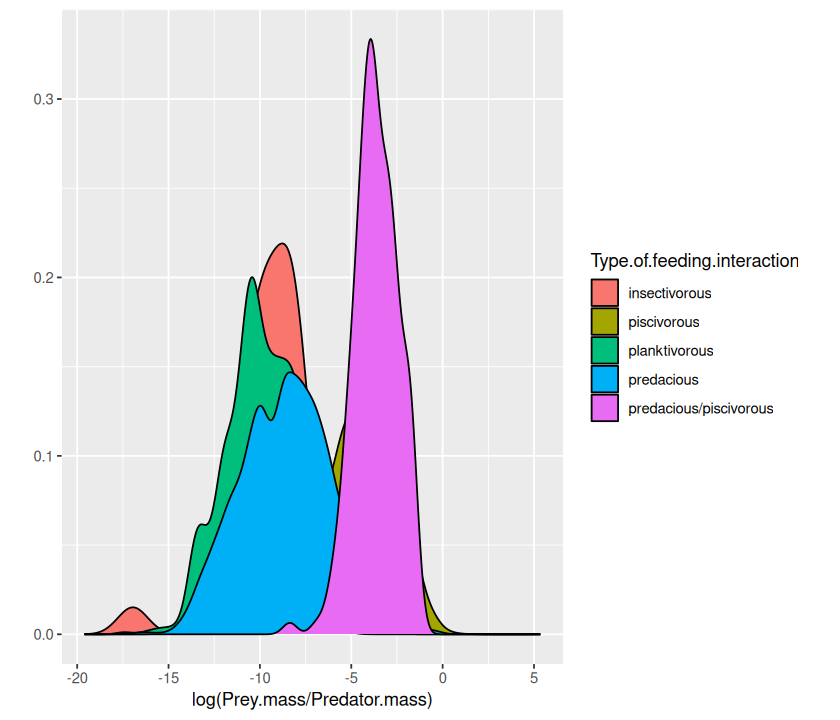

In [94]:
qplot(log(Prey.mass/Predator.mass), data = MyDF, geom =  "density", 
      fill = Type.of.feeding.interaction)

And you can make the densities transparent so that the overlaps are visible:

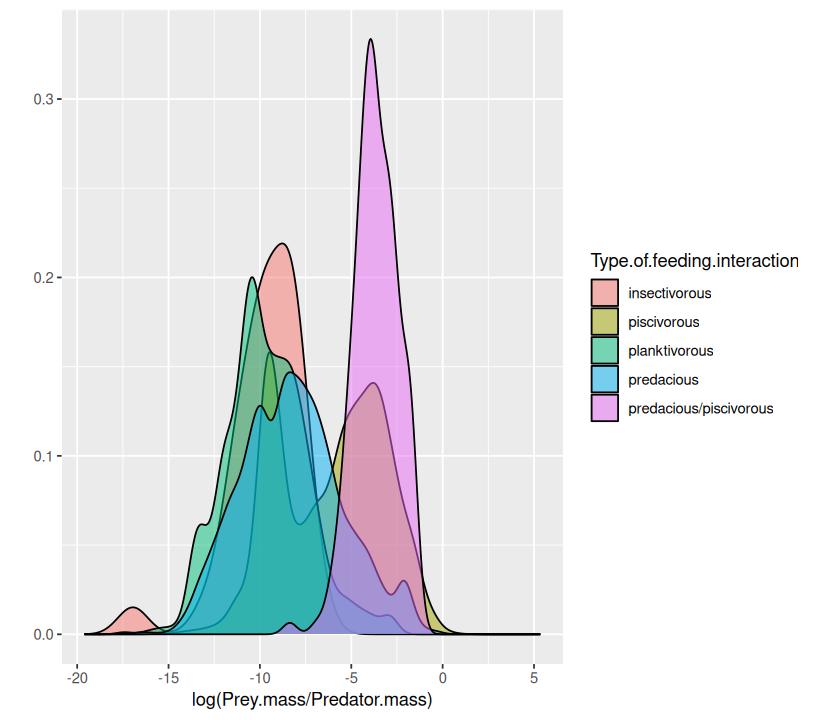

In [95]:
qplot(log(Prey.mass/Predator.mass), data = MyDF, geom =  "density", 
      fill = Type.of.feeding.interaction, 
      alpha = I(0.5))

or using `colour` instead of `fill` draws only the edge of the curve:

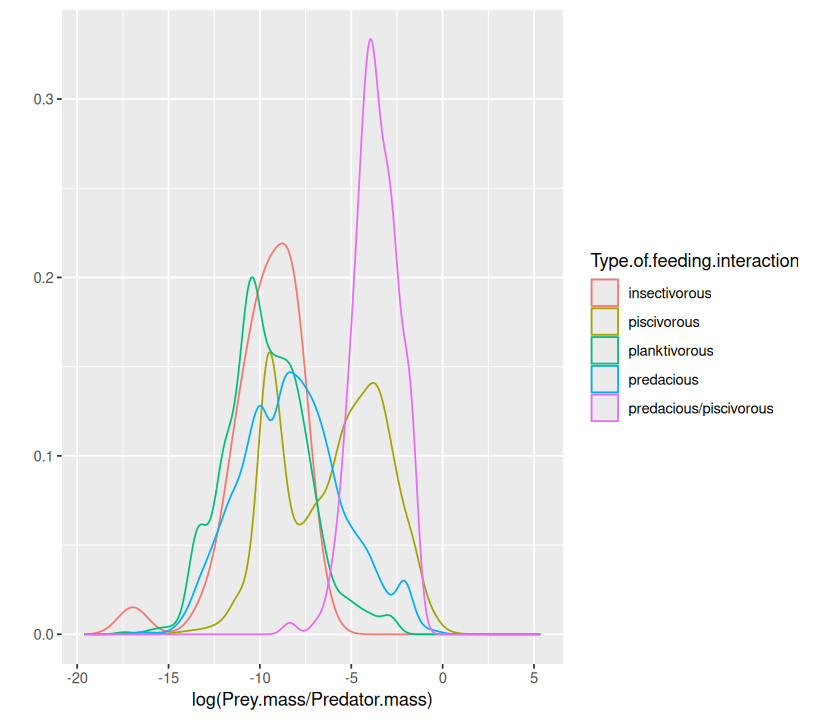

In [96]:
qplot(log(Prey.mass/Predator.mass), data = MyDF, geom =  "density", 
      colour = Type.of.feeding.interaction)

Similarly, `geom = "bar"` produces a barplot, `geom = "line"` a series of points joined by a line, etc.

#### Multi-faceted plots

An alternative way of displaying data belonging to different classes is using "faceting":

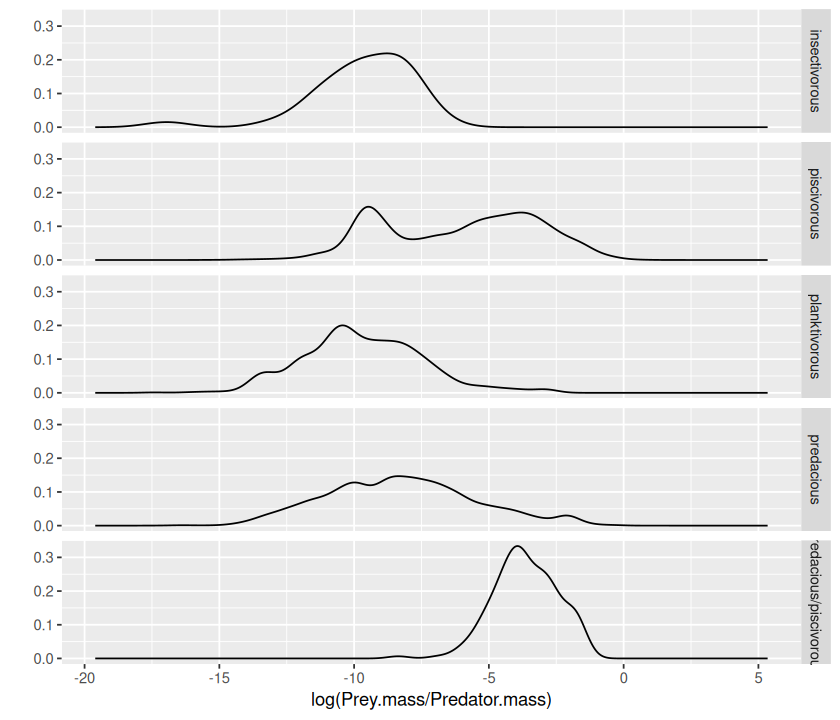

In [97]:
qplot(log(Prey.mass/Predator.mass), facets = Type.of.feeding.interaction ~., data = MyDF, geom =  "density")

The `~.` (the space is not important) notation tells ggplot whether to do the faceting by row or by column. So if you want a by-column configuration, switch `~` and `.`, and also swap the position of the `.~`:

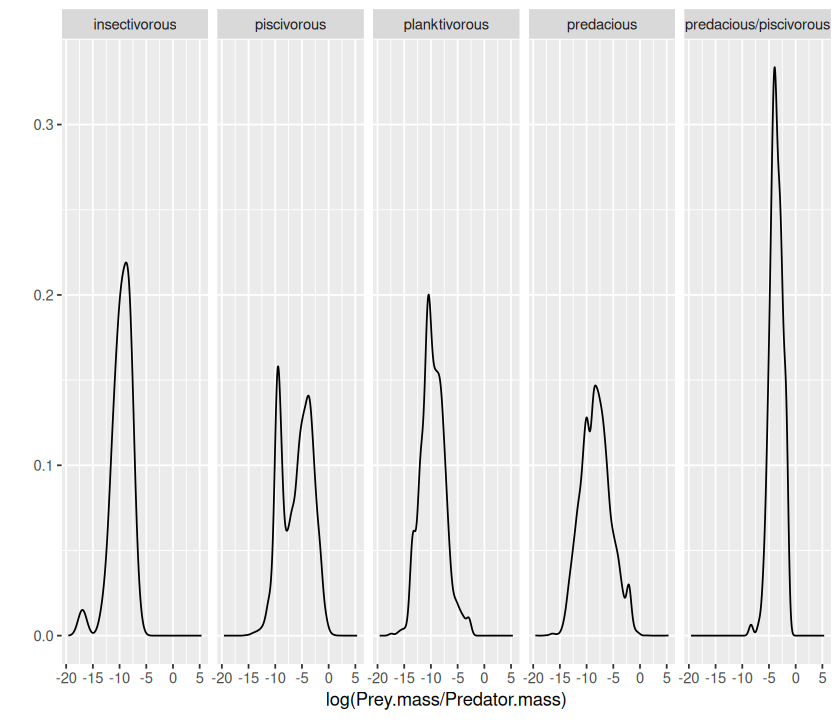

In [98]:
qplot(log(Prey.mass/Predator.mass), facets =  .~ Type.of.feeding.interaction, data = MyDF, geom =  "density")

#### Logarithmic axes

A better way to plot data in the log scale is to also set the axes to be logarithmic:

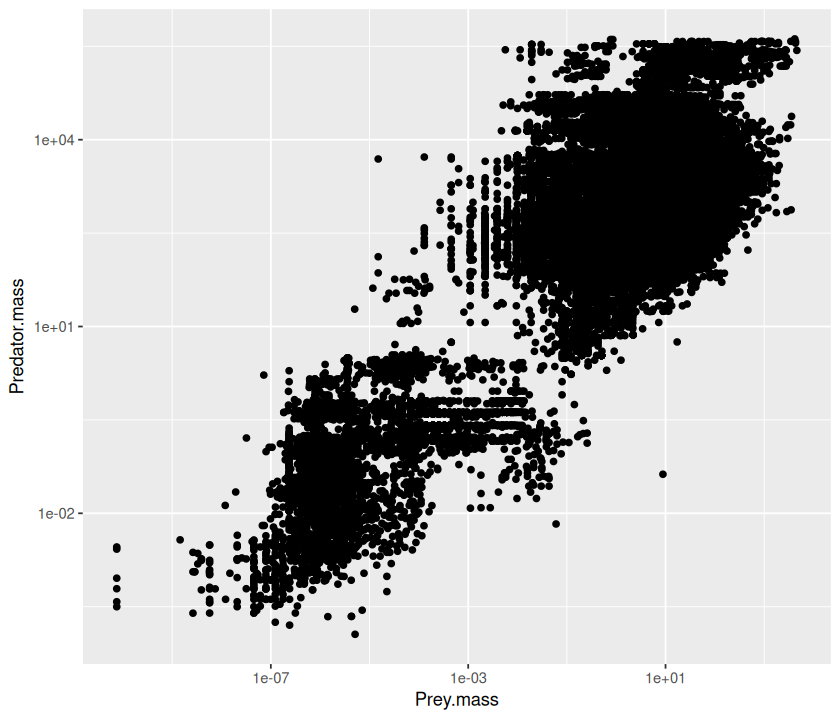

In [99]:
qplot(Prey.mass, Predator.mass, data = MyDF, log="xy")

#### Plot annotations

Let's add a title and labels:

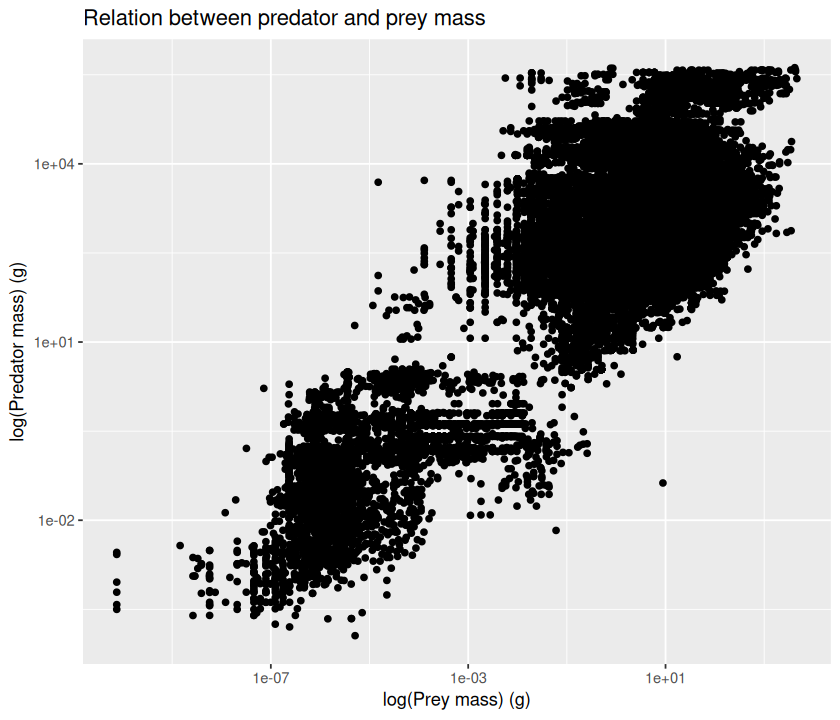

In [100]:
qplot(Prey.mass, Predator.mass, data = MyDF, log="xy",
    main = "Relation between predator and prey mass", 
    xlab = "log(Prey mass) (g)", 
    ylab = "log(Predator mass) (g)")

Adding `+ theme_bw()` makes it suitable for black and white printing.

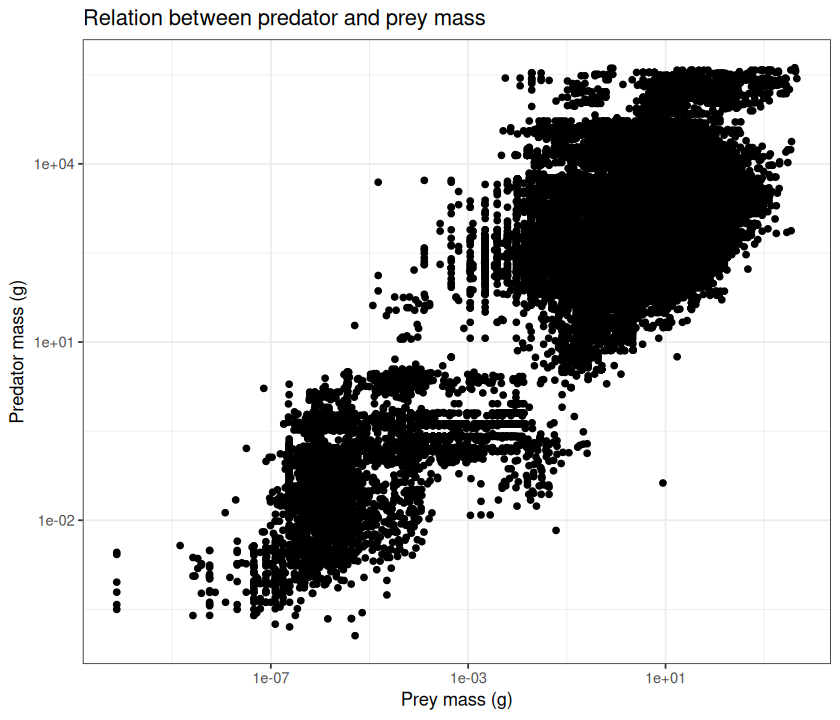

In [101]:
qplot(Prey.mass, Predator.mass, data = MyDF, log="xy",
    main = "Relation between predator and prey mass", 
    xlab = "Prey mass (g)", 
    ylab = "Predator mass (g)") + theme_bw()

#### Saving your plots

Finally, let's save a pdf file of the figure (same approach as we [used before](#Saving-your-graphics)):

In [102]:
pdf("../results/MyFirst-ggplot2-Figure.pdf")
print(qplot(Prey.mass, Predator.mass, data = MyDF,log="xy",
    main = "Relation between predator and prey mass", 
    xlab = "log(Prey mass) (g)", 
    ylab = "log(Predator mass) (g)") + theme_bw())
dev.off()

agg_record_77301410 
                  2

Using `print` ensures that the whole command is kept together and that you can use the command in a script.

### Some more important ggplot options

Other important options to keep in mind:

|   Option            |                |
|--- |--- |
|`xlim`      | limits for x axis: `xlim = c(0,12)`|
|`ylim`      | limits for y axis|
|`log`       |log transform variable `log = "x"`, `log = "y"`, `log = "xy"`|
|`main`      |title of the plot `main = "My Graph"`|
|`xlab`      |x-axis label|
|`ylab`      |y-axis label|
|`asp`       | aspect ratio `asp = 2`, `asp = 0.5`|
|`margins`   |whether or not margins will be displayed|


### The `geom` argument

`geom` Specifies the geometric objects that define the graph type. The geom option is expressed as a R character vector with one or more entries. geom values include "point", "smooth", "boxplot", "line", "histogram", "density", "bar", and "jitter".

Try the following:

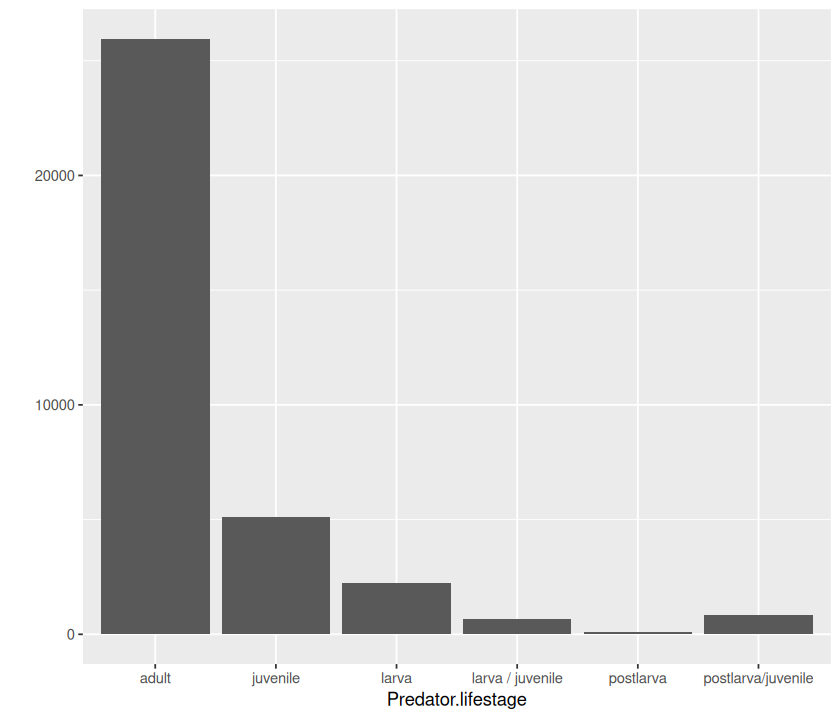

In [103]:
# load the data
MyDF <- as.data.frame(read.csv("../data/EcolArchives-E089-51-D1.csv"))

# barplot
qplot(Predator.lifestage, data = MyDF, geom = "bar")

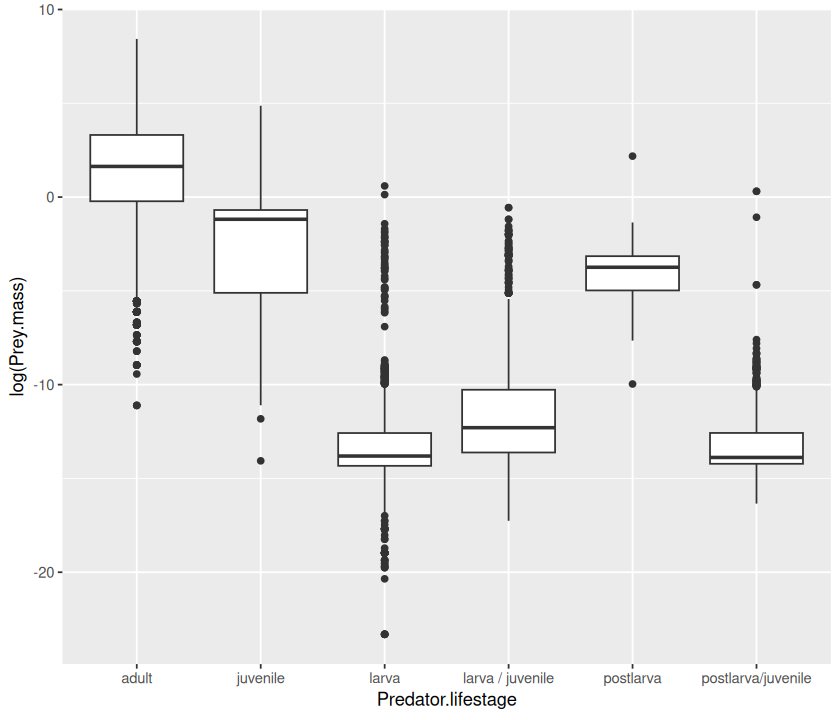

In [104]:
# boxplot
qplot(Predator.lifestage, log(Prey.mass), data = MyDF, geom = "boxplot")

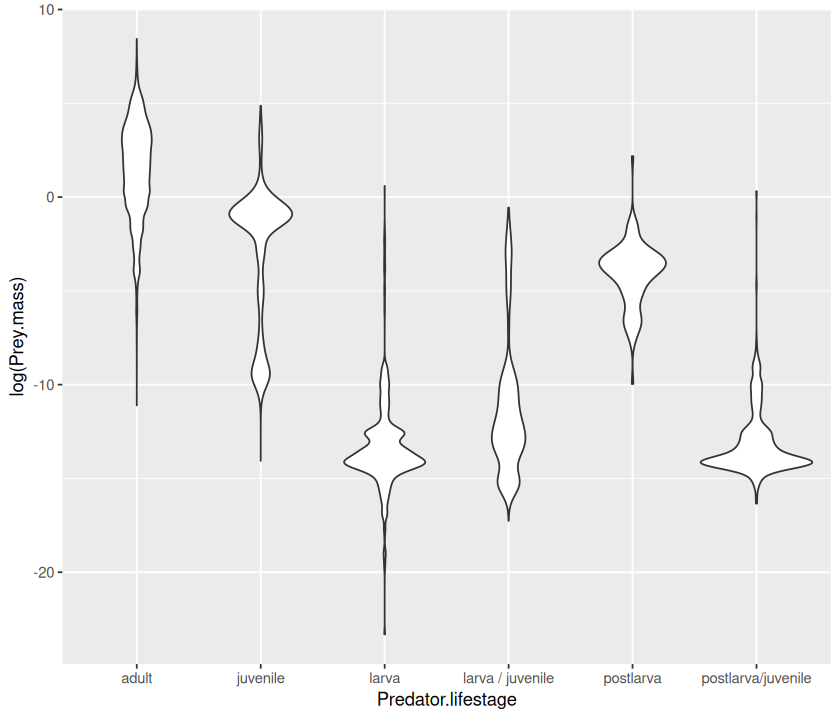

In [105]:
# violin plot
qplot(Predator.lifestage, log(Prey.mass), data = MyDF, geom = "violin")

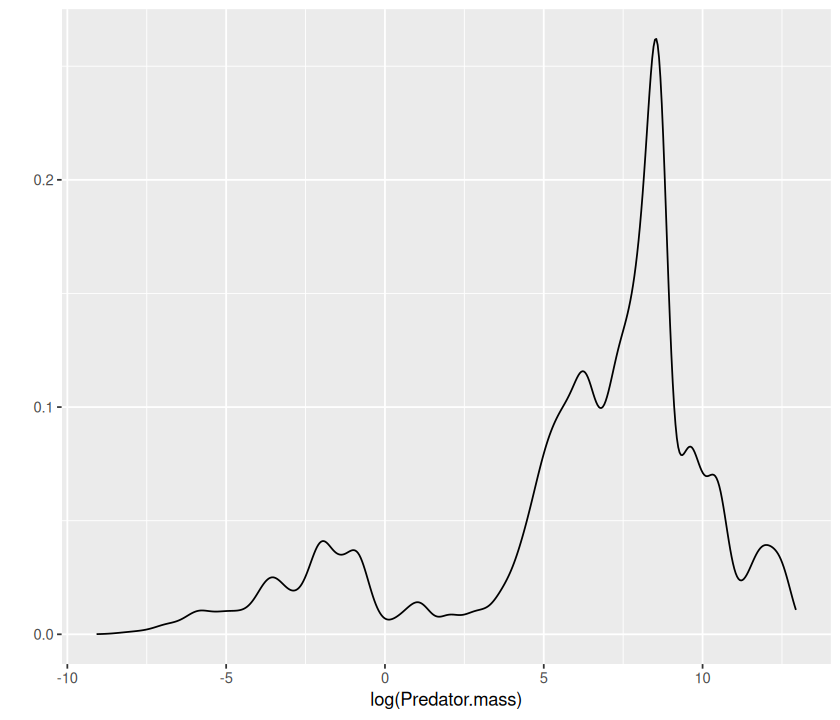

In [106]:
# density
qplot(log(Predator.mass), data = MyDF, geom = "density")

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


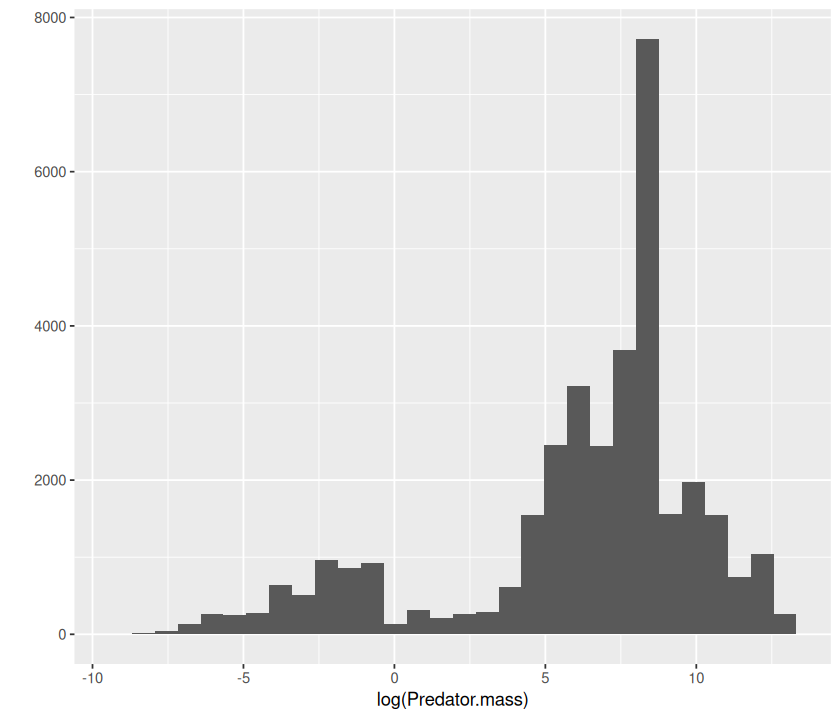

In [107]:
# histogram
qplot(log(Predator.mass), data = MyDF, geom = "histogram")

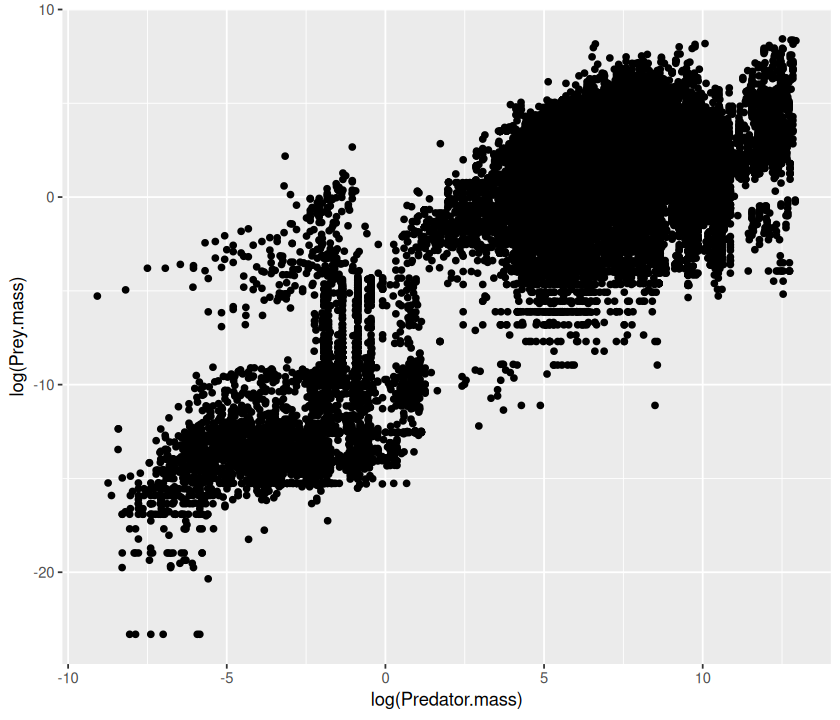

In [108]:
# scatterplot
qplot(log(Predator.mass), log(Prey.mass), data = MyDF, geom = "point")

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


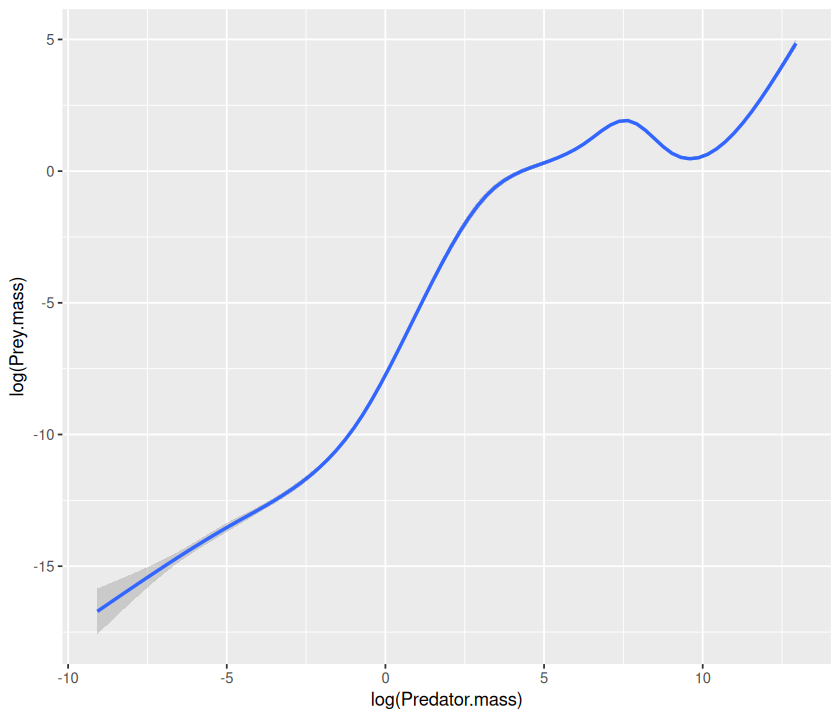

In [109]:
# smooth
qplot(log(Predator.mass), log(Prey.mass), data = MyDF, geom = "smooth")

`geom_smooth()` using formula = 'y ~ x'


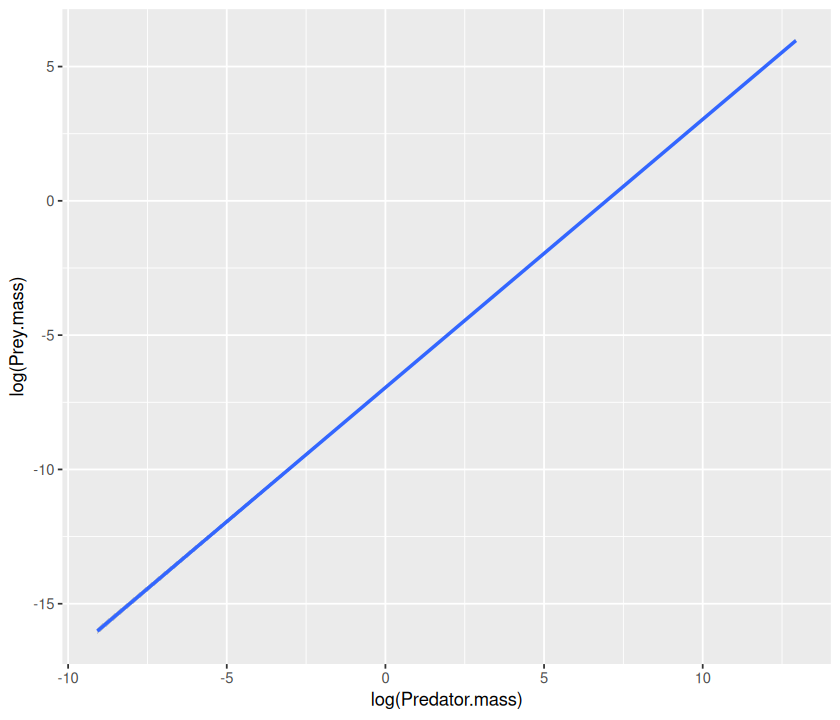

In [110]:
qplot(log(Predator.mass), log(Prey.mass), data = MyDF, geom = "smooth", method = "lm")

### Advanced plotting: `ggplot`

The command `qplot` allows you to use only a single dataset and a single set of "aesthetics" (x, y, etc.). To make full use of `ggplot2`, we need to use the command `ggplot`, which allows you to use "layering". Layering is the mechanism by which additional data elements are added to a plot. Each layer can come from a different dataset and have a different aesthetic mapping, allowing us to create plots that could not be generated using `qplot()`, which permits only a single dataset and a single set of aesthetic mappings.

For a `ggplot` plotting command, we need at least:

-   The data to be plotted, in a data frame;

-   Aesthetics mappings, specifying which variables we want to plot, and how;

-   The `geom`, defining the geometry for representing the data;

-   (Optionally) some `stat` that transforms the data or performs statistics using the data.

To start a graph, we must specify the data and the aesthetics:

In [111]:
p <- ggplot(MyDF, aes(x = log(Predator.mass),
                y = log(Prey.mass),
                colour = Type.of.feeding.interaction))

Here we have created a graphics object `p` to which we can add layers and other plot elements.

Now try to plot the graph:

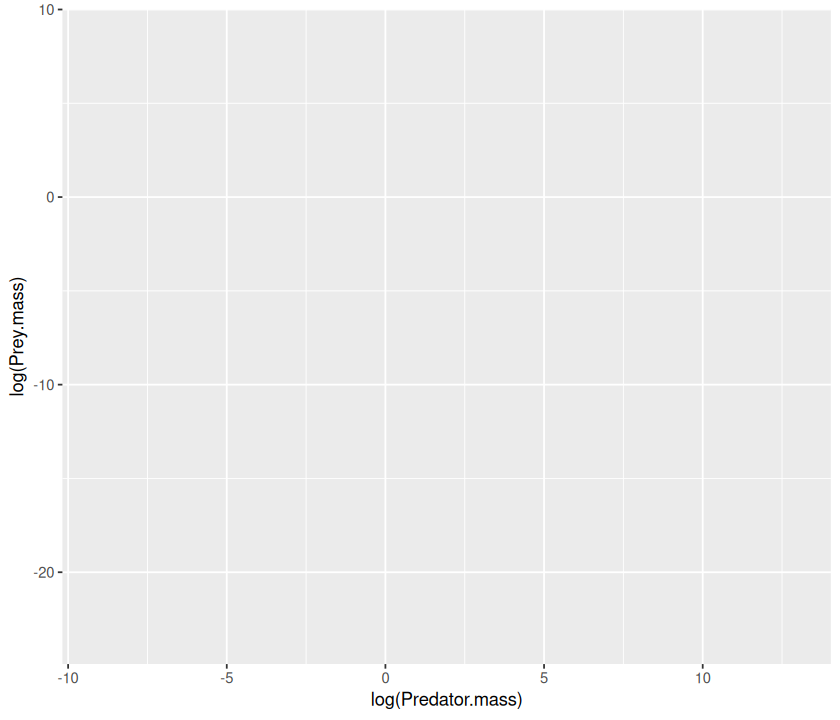

In [112]:
p

Plot is blank because we are yet to specify a geometry — only then can we see the graph:

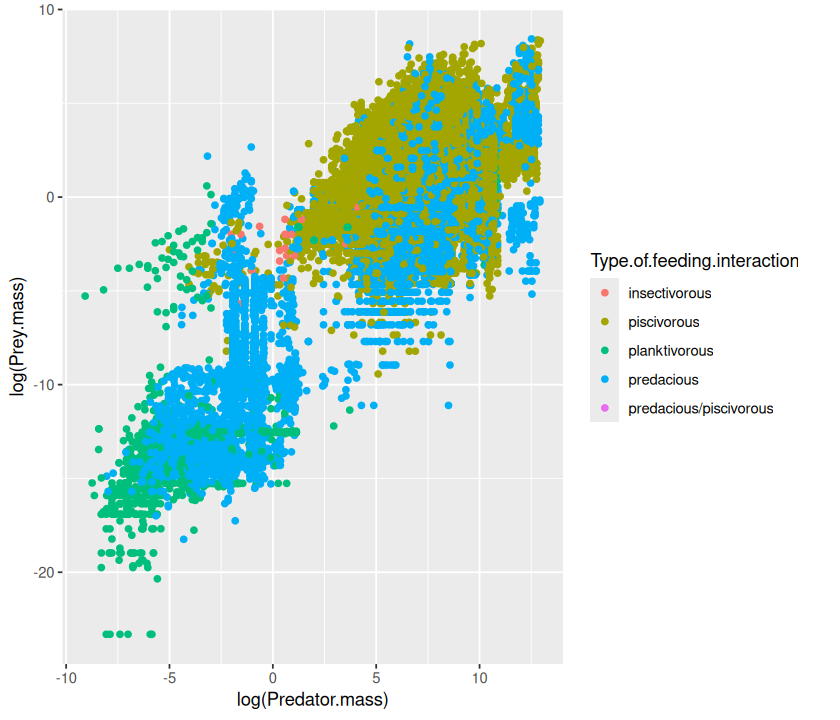

In [113]:
p + geom_point()

We can use the "+" sign to concatenate different commands:

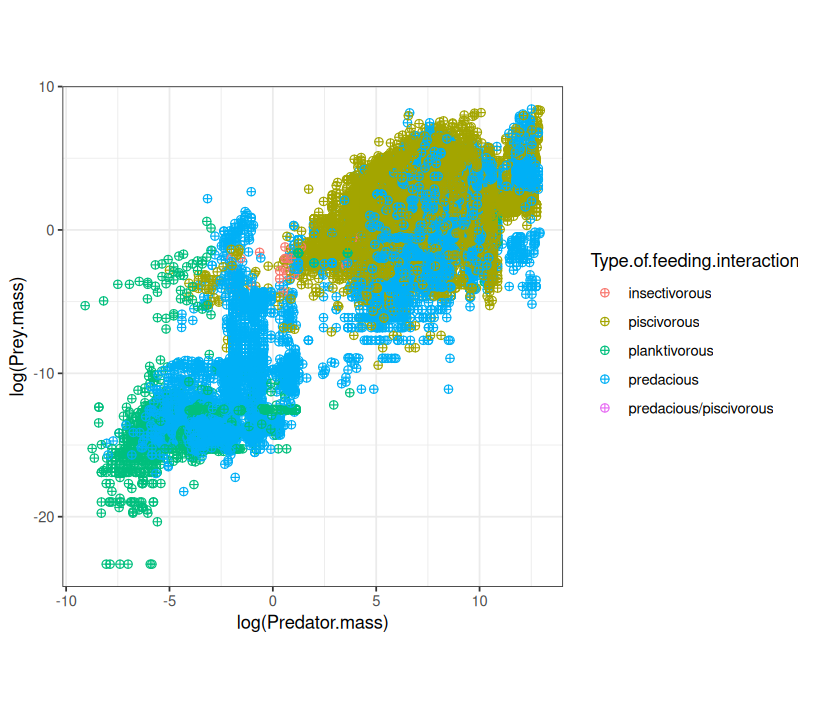

In [114]:
p <- ggplot(MyDF, aes(x = log(Predator.mass), y = log(Prey.mass), colour = Type.of.feeding.interaction ))
q <- p + 
geom_point(size=I(2), shape=I(10)) +
theme_bw() + # make the background white
theme(aspect.ratio=1) # make the plot square
q

Let's remove the legend:

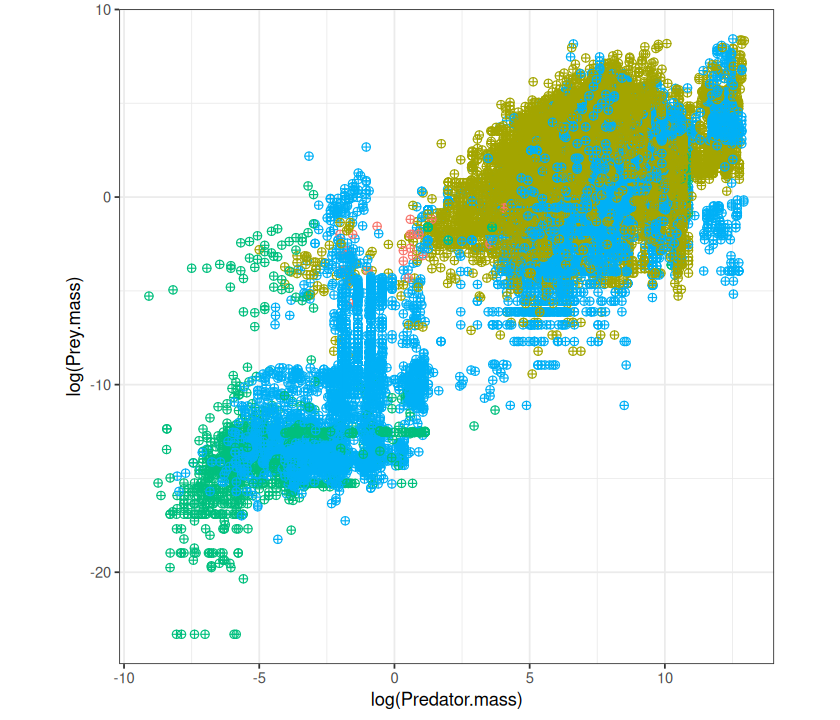

In [115]:
q + theme(legend.position = "none") + theme(aspect.ratio=1)

Now, same as before, but using ggplot instead of qplot:

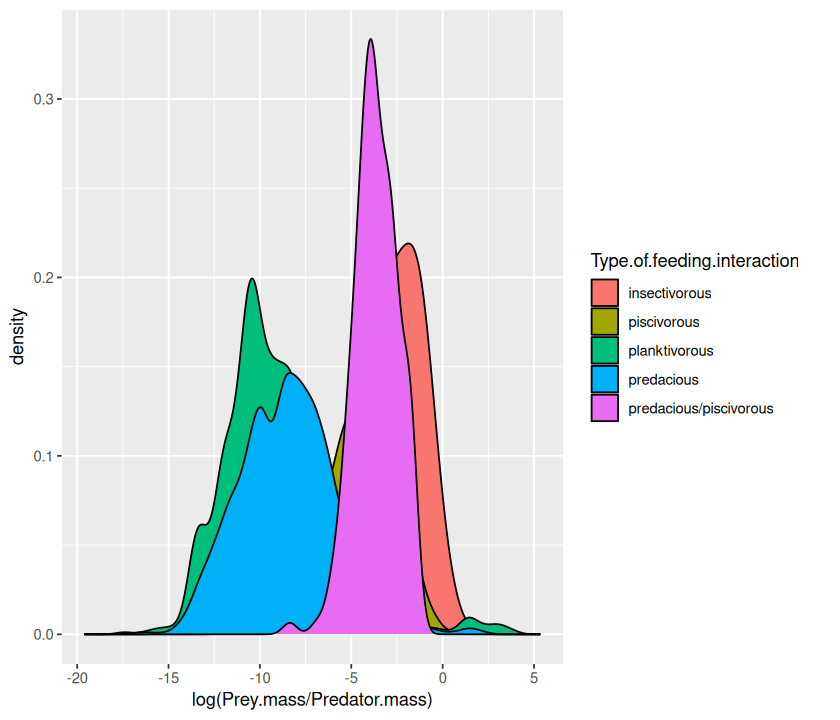

In [116]:
p <- ggplot(MyDF, aes(x = log(Prey.mass/Predator.mass), fill = Type.of.feeding.interaction )) + geom_density()
p

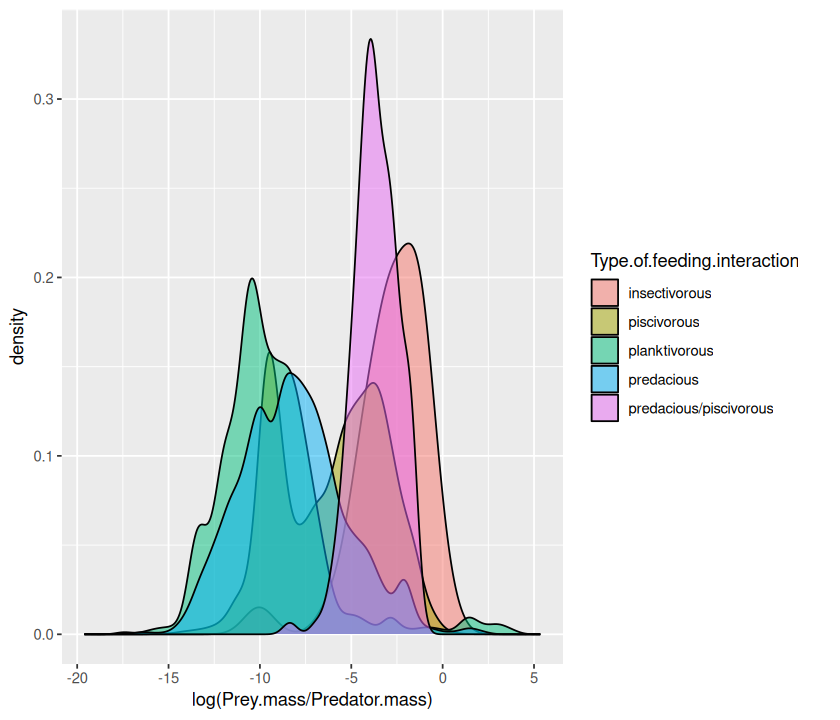

In [117]:
p <- ggplot(MyDF, aes(x = log(Prey.mass/Predator.mass), fill = Type.of.feeding.interaction)) + geom_density(alpha=0.5)
p

In [118]:
options(repr.plot.width=12, repr.plot.height= 8) # Change plot size (in cm)

You can also create a multifaceted plot:

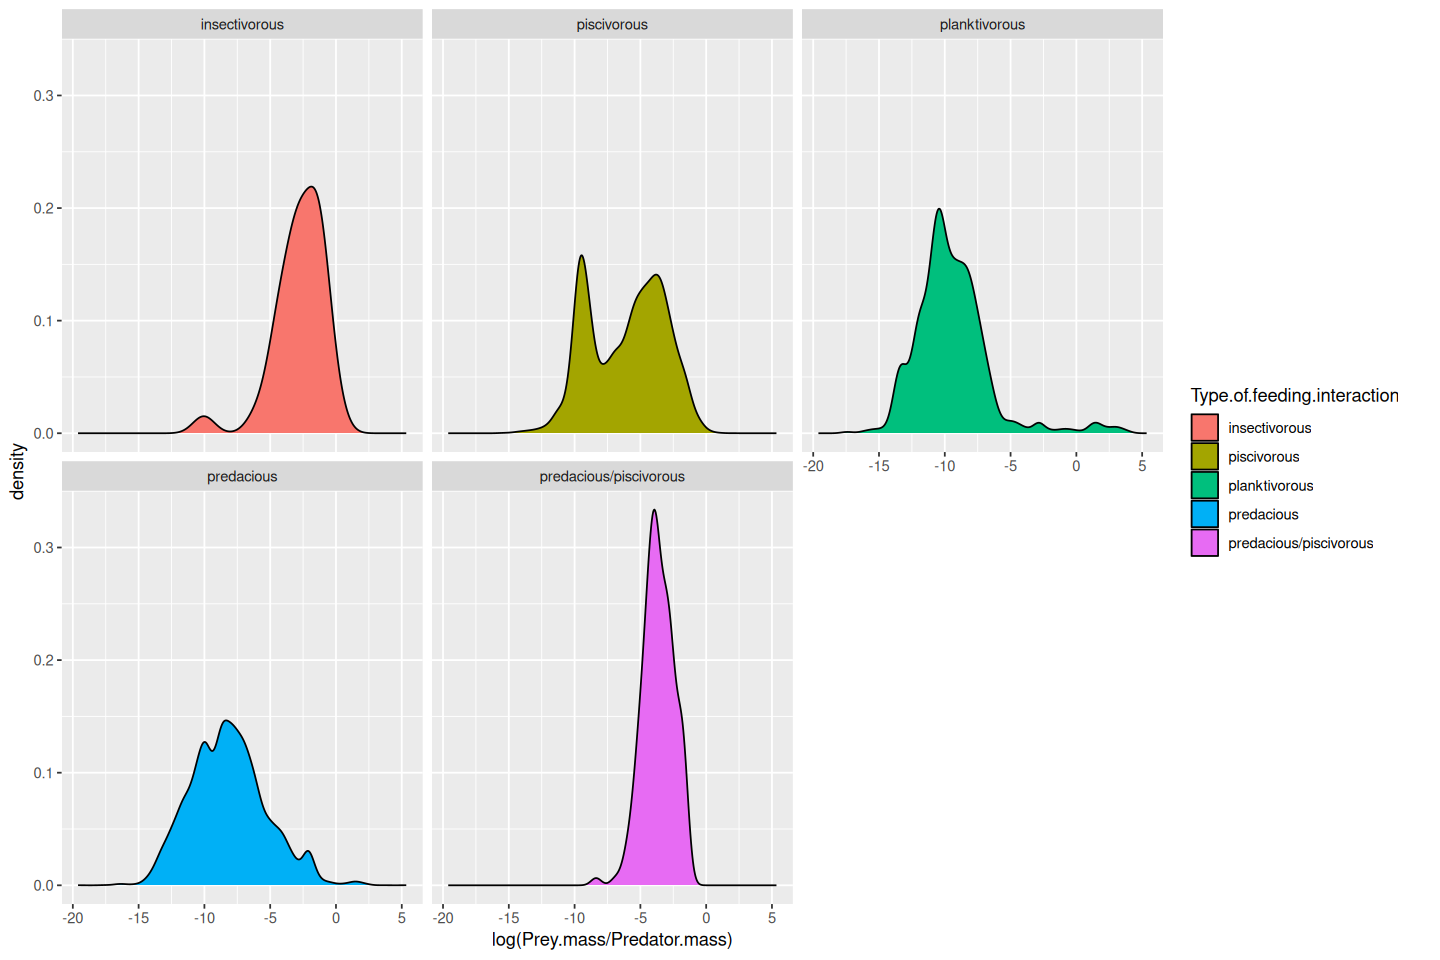

In [119]:
p <- ggplot(MyDF, aes(x = log(Prey.mass/Predator.mass), fill = Type.of.feeding.interaction )) +  geom_density() + facet_wrap( .~ Type.of.feeding.interaction)
p

The axis limits in the plots are fixed irrespective of the data ranges, making it harder to visualize the shapes of the distributions. You can free up the axes to allow data-specific axis limits by using the `scales = "free"` argument:   

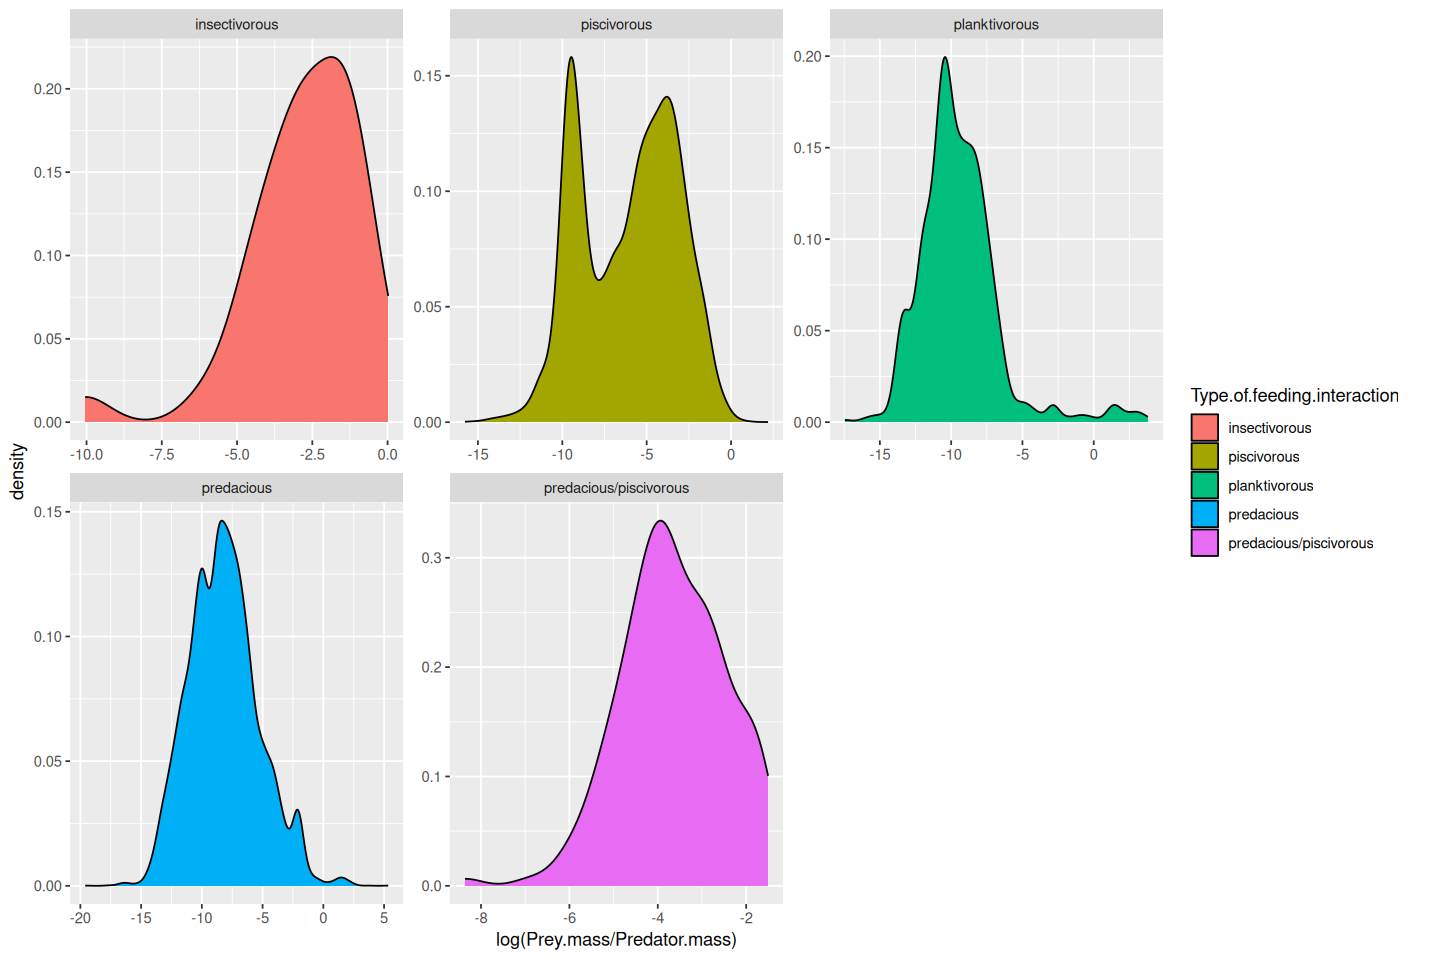

In [120]:
p <- ggplot(MyDF, aes(x = log(Prey.mass/Predator.mass), fill = Type.of.feeding.interaction )) +  geom_density() + facet_wrap( .~ Type.of.feeding.interaction, scales = "free")
p

```{tip}
In `facet_wrap`, You can also free up just the x or y scales; look up the documentation for this function.
```

In [121]:
options(repr.plot.width=10, repr.plot.height= 12) # Change plot size (in cm)

Now let's plot the size-ratio distributions by location (and again, with scales free):  

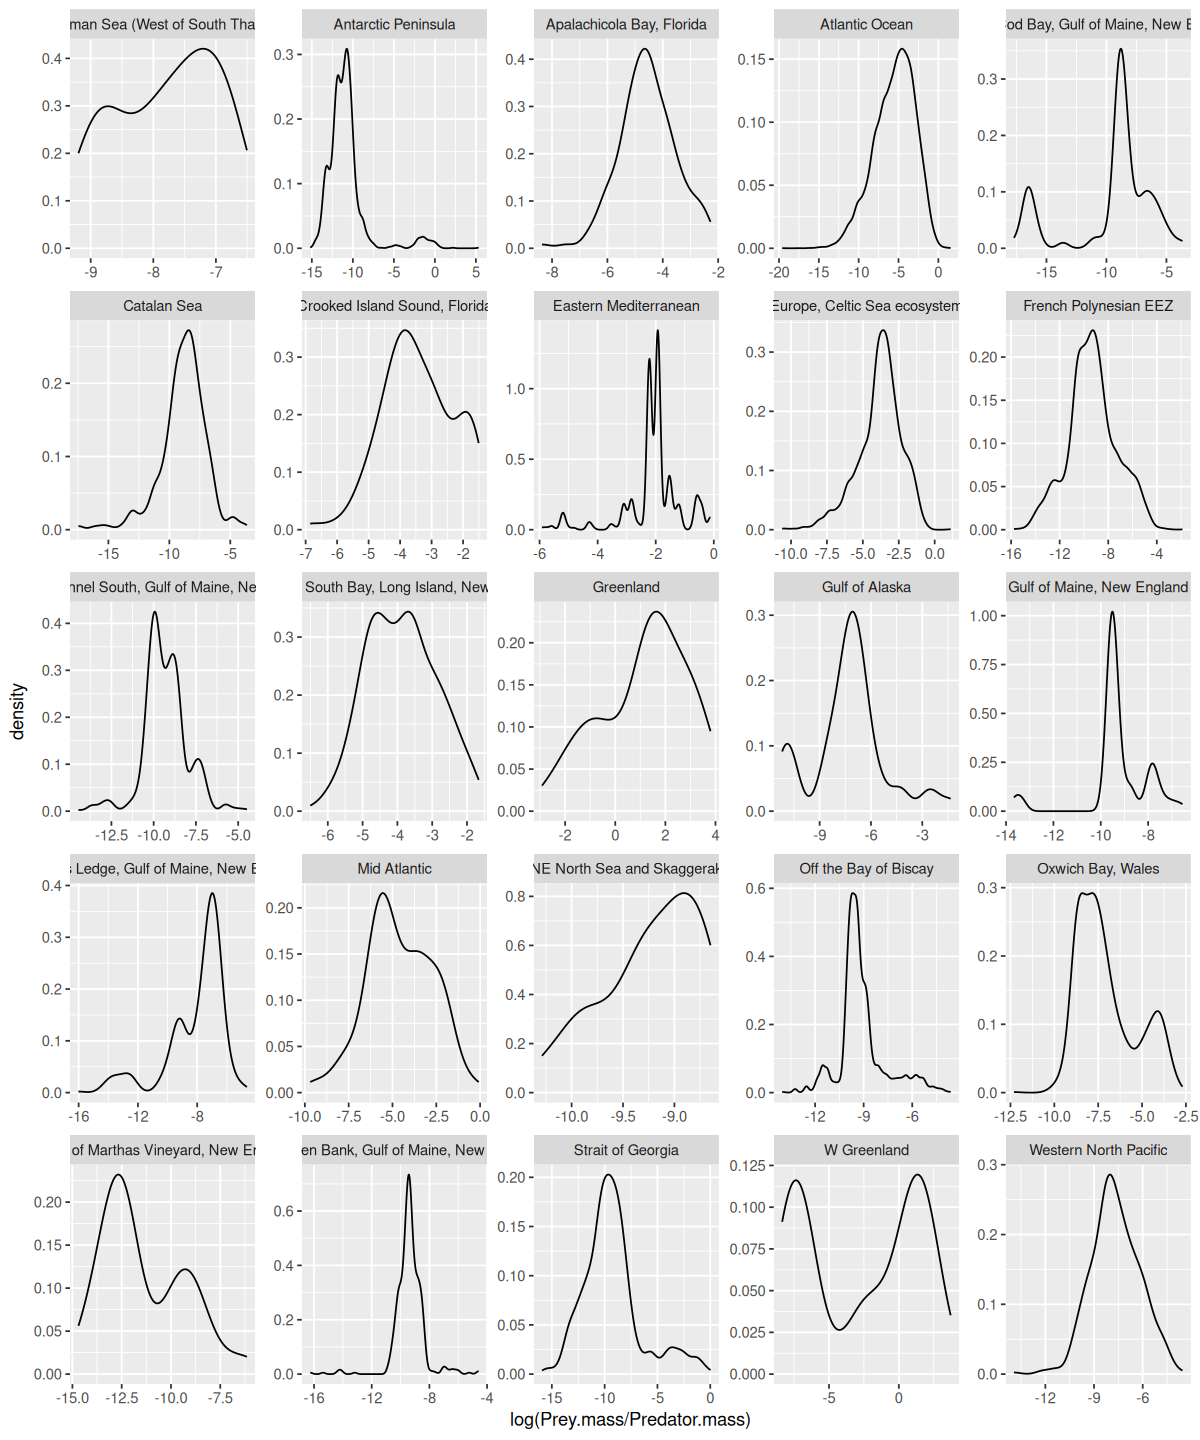

In [122]:
p <- ggplot(MyDF, aes(x = log(Prey.mass/Predator.mass))) +  geom_density() + facet_wrap( .~ Location, scales = "free")
p

A different example:

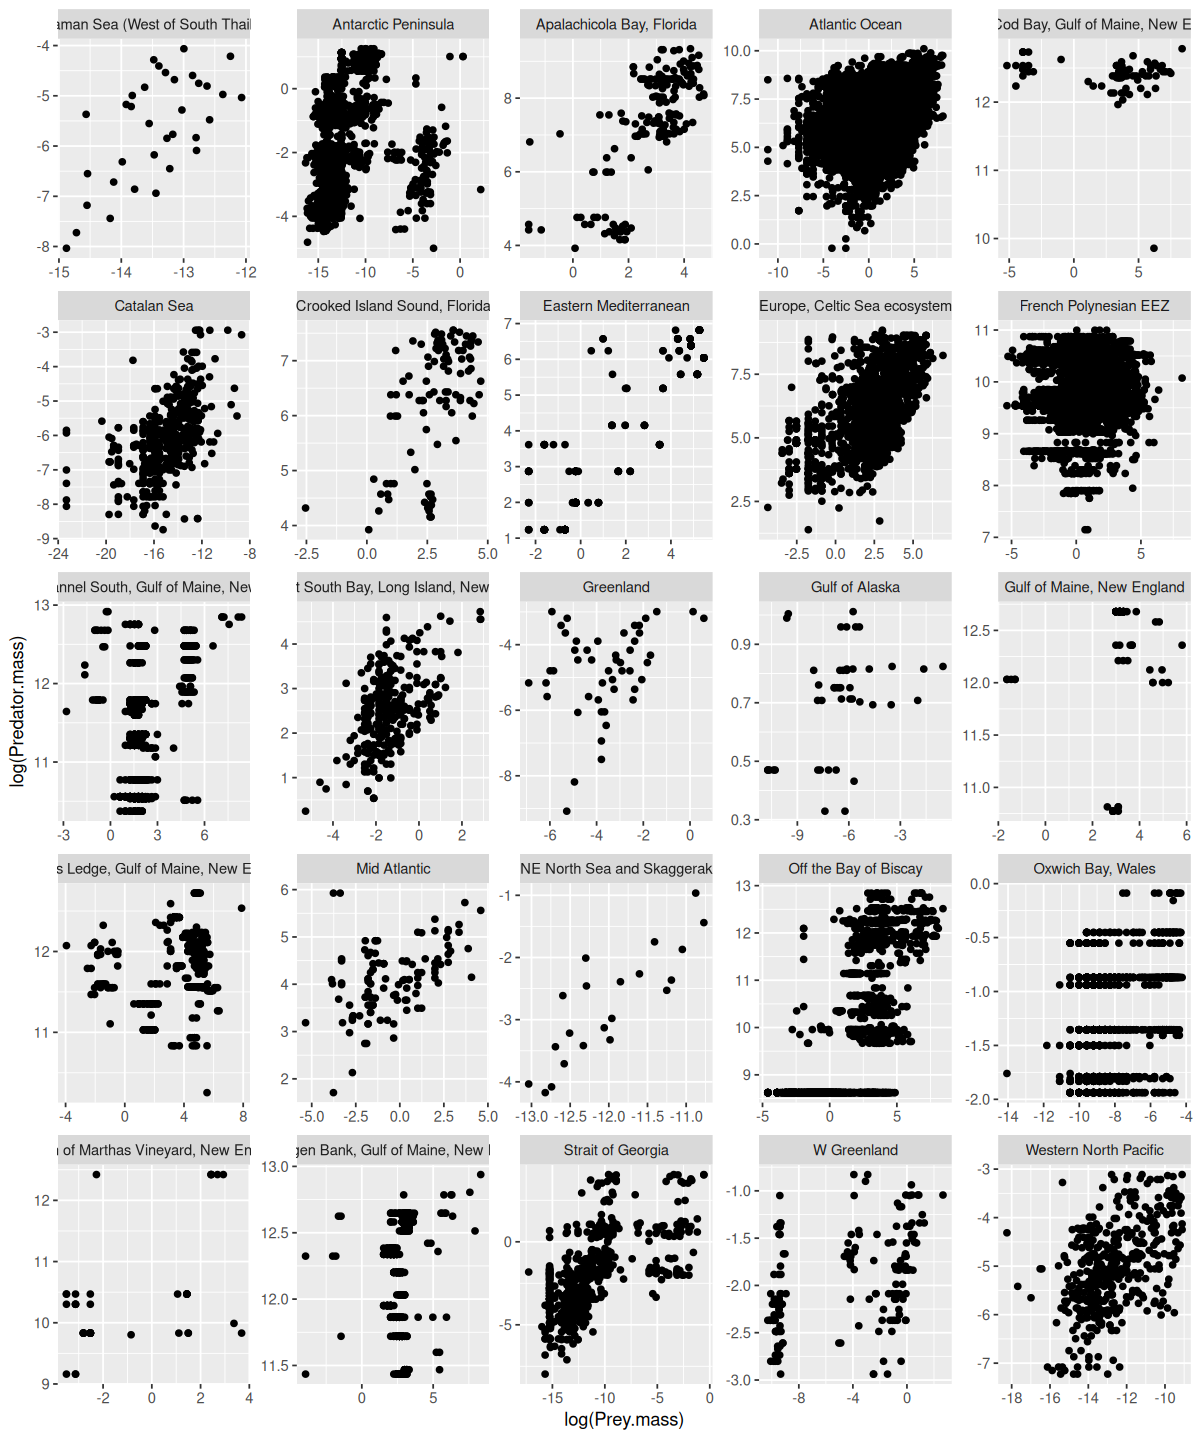

In [123]:
p <- ggplot(MyDF, aes(x = log(Prey.mass), y = log(Predator.mass))) +  geom_point() + facet_wrap( .~ Location, scales = "free")
p

You can also combine categories like this (this will be BIG plot!):

In [124]:
options(repr.plot.width=12, repr.plot.height= 14) # Change plot size (in cm)

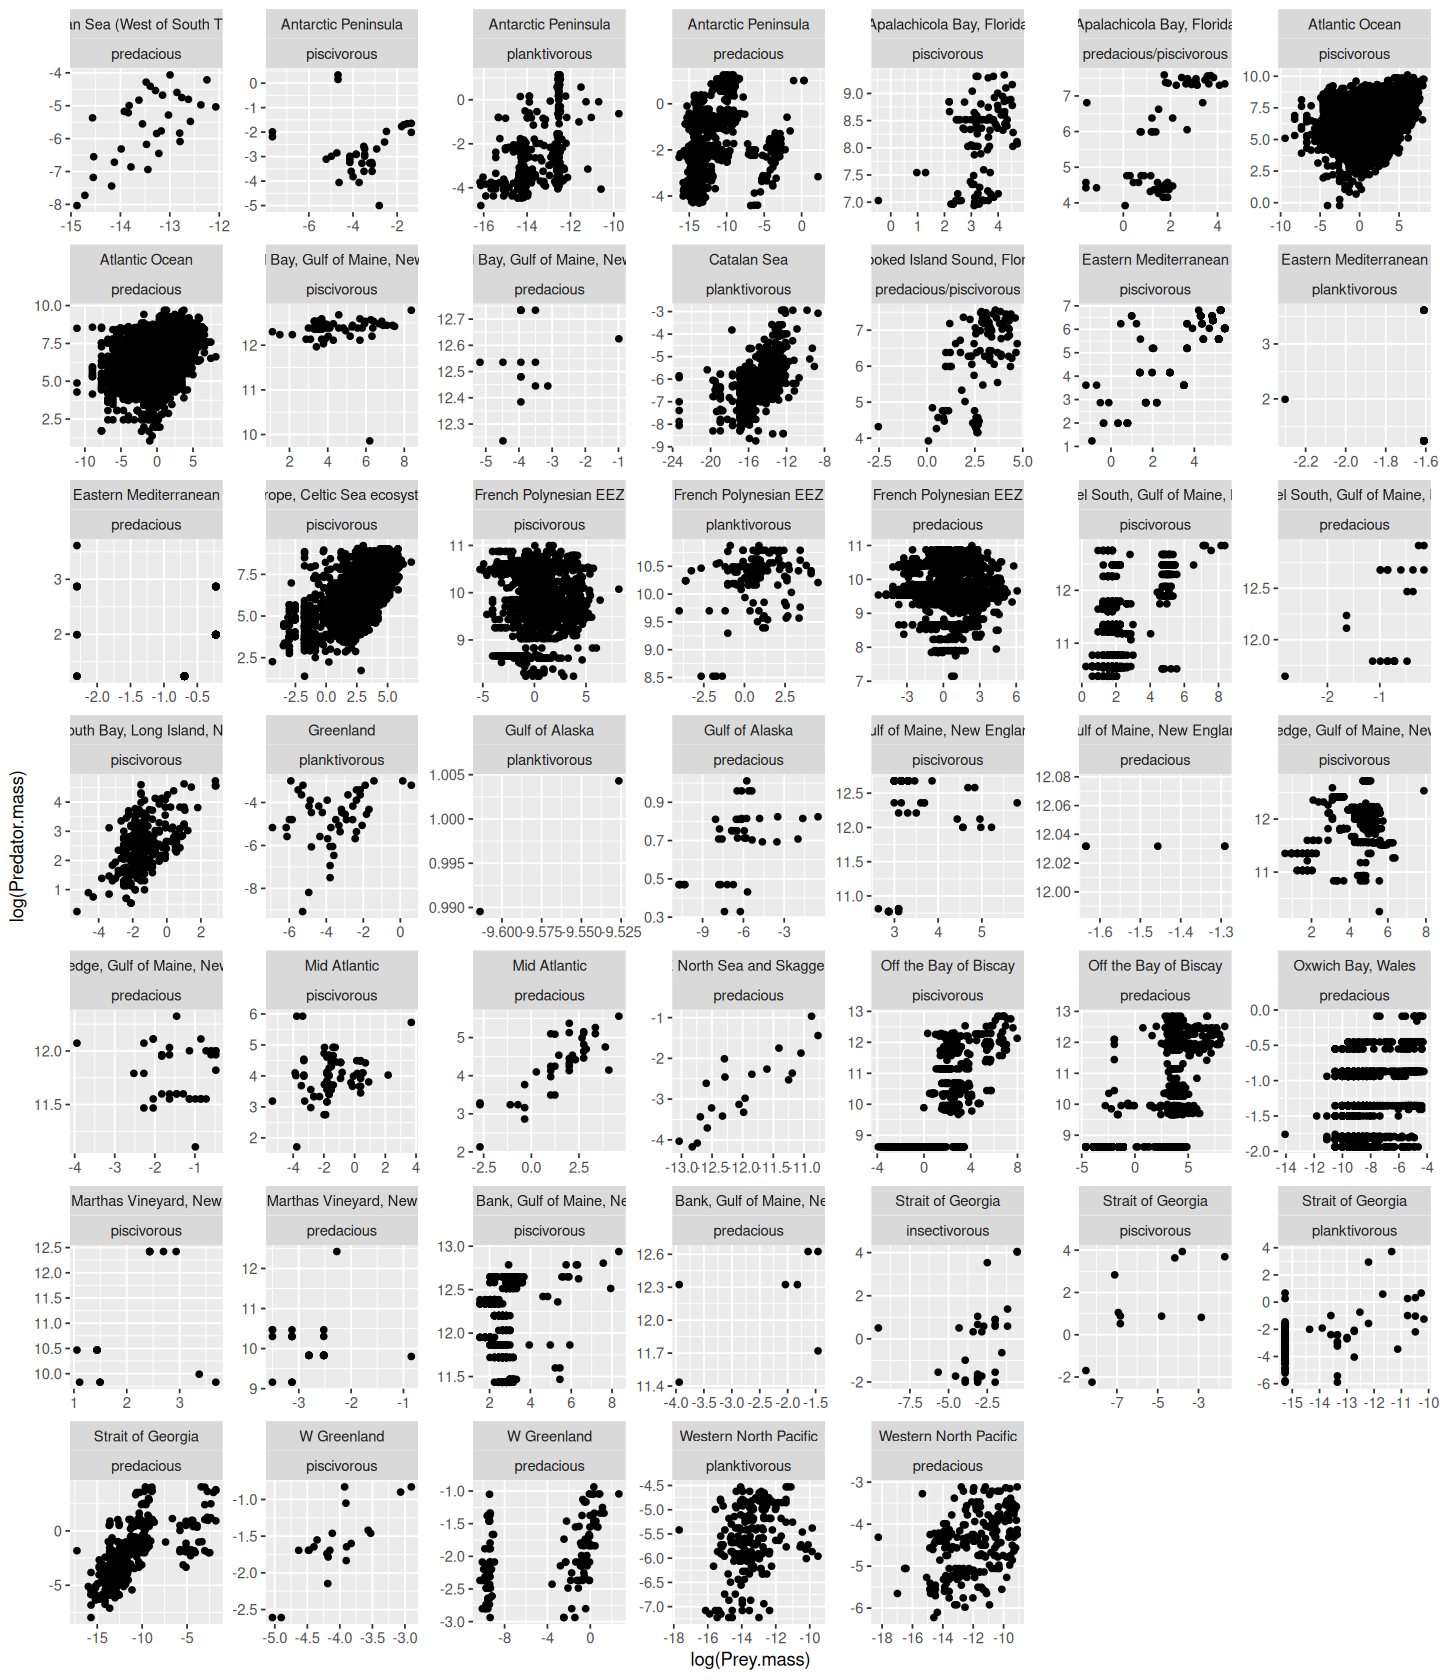

In [125]:
p <- ggplot(MyDF, aes(x = log(Prey.mass), y = log(Predator.mass))) +  geom_point() + facet_wrap( .~ Location + Type.of.feeding.interaction, scales = "free")
p

And you can also change the order of the combination:

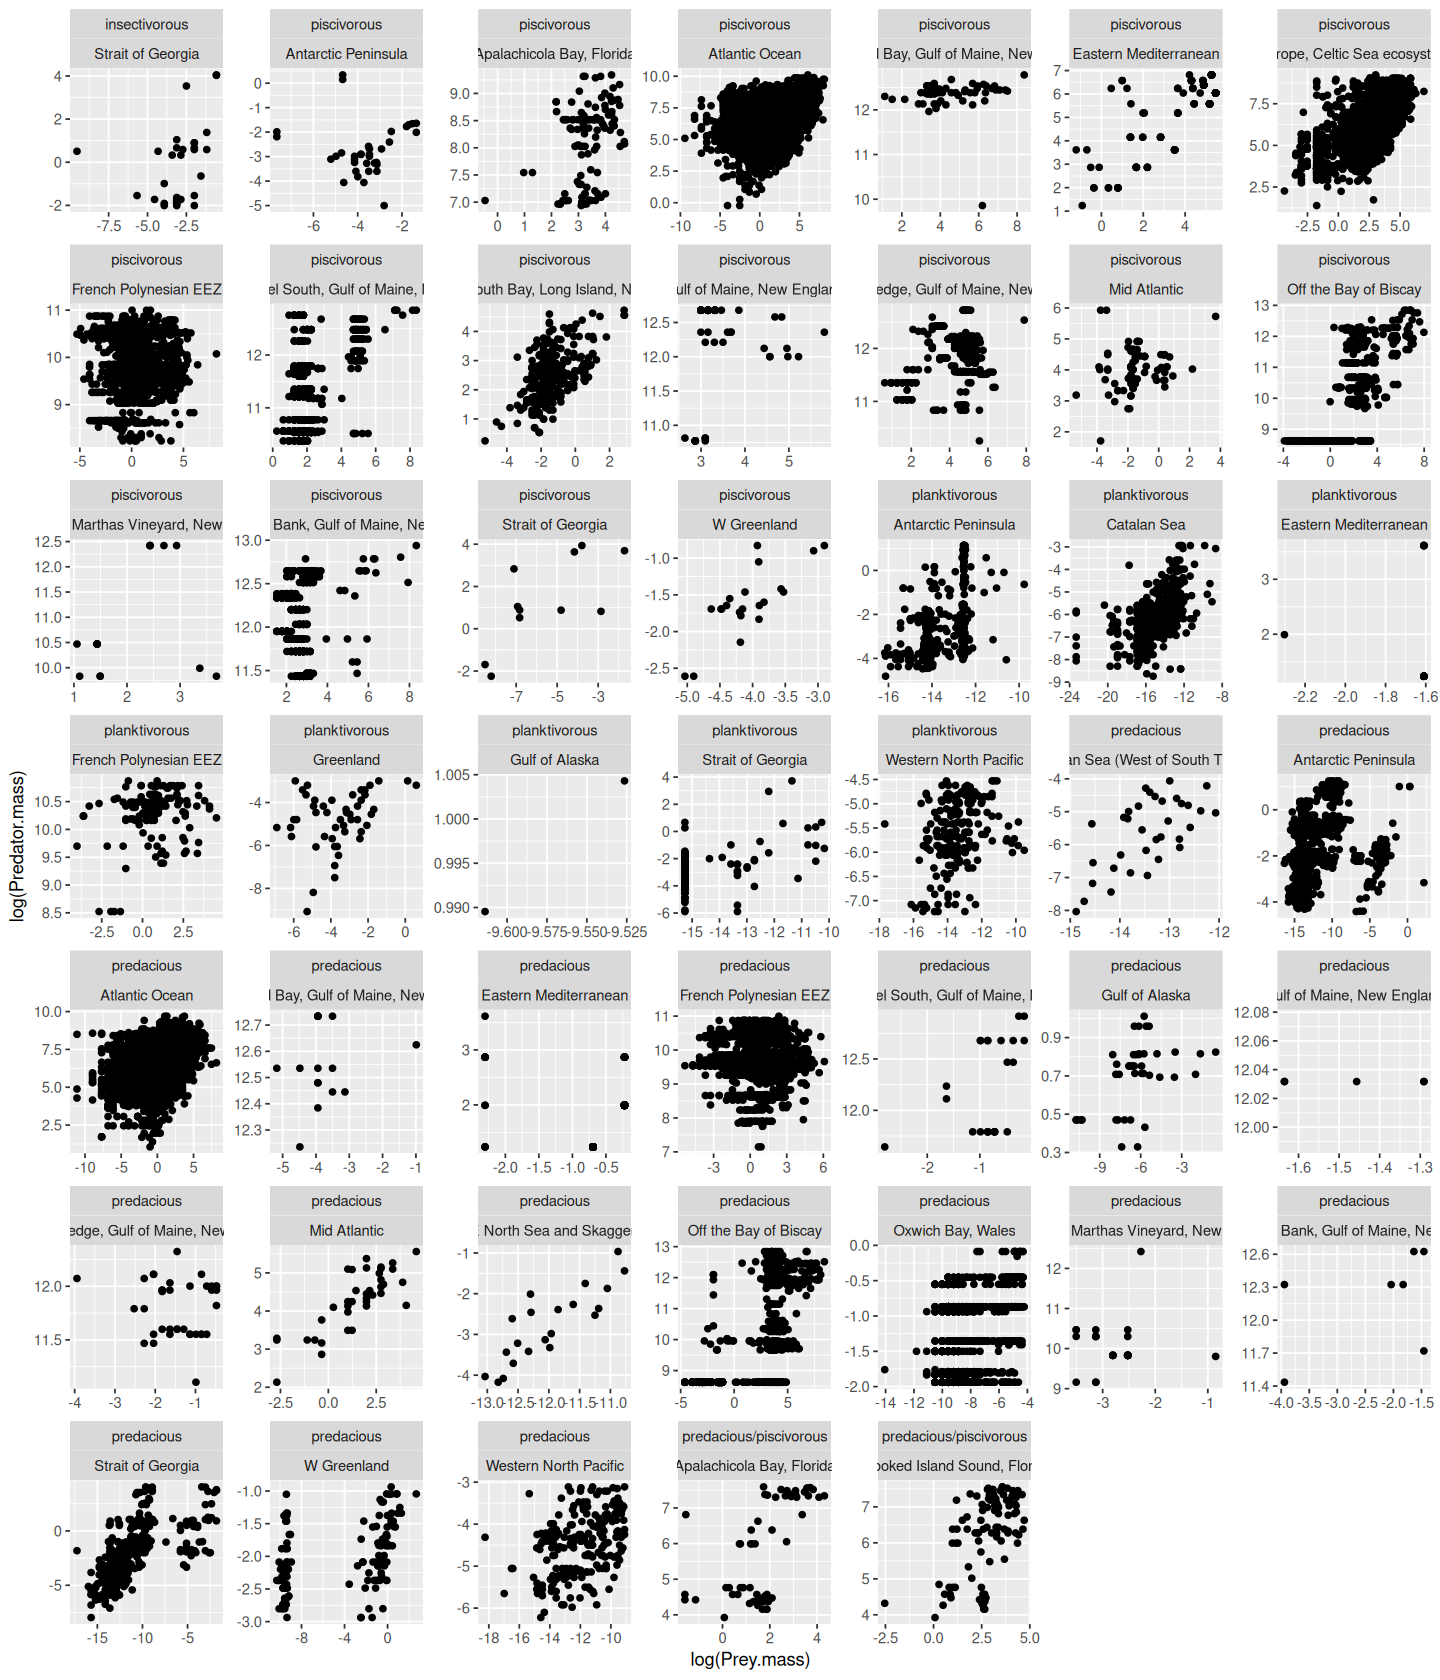

In [126]:
p <- ggplot(MyDF, aes(x = log(Prey.mass), y = log(Predator.mass))) +  geom_point() + facet_wrap( .~ Type.of.feeding.interaction + Location, scales = "free")
p

For more fine-tuned faceting, look up the `facet_grid()` and `facet_wrap()` functions within `ggplot2`. Look up this variant of the [R Cookbook](http://www.cookbook-r.com/Graphs) for more examples.

In [127]:
options(repr.plot.width=7, repr.plot.height= 6) # Change plot size (in cm)

### Some useful ggplot examples 


### Plotting a matrix

Let's plot the values of a matrix. This is basically the same as rendering a 2D image. We will visualize random values taken from a unform distribution $\mathcal U [0,1]$. Because we want to plot a matrix, and ggplot2 accepts only dataframes, we use the package reshape2, which can "melt" a matrix into a dataframe:

In [128]:
require(reshape2)

In [129]:
GenerateMatrix <- function(N){
    M <- matrix(runif(N * N), N, N)
    return(M)
}

In [130]:
M <- GenerateMatrix(10)
Melt <- melt(M)

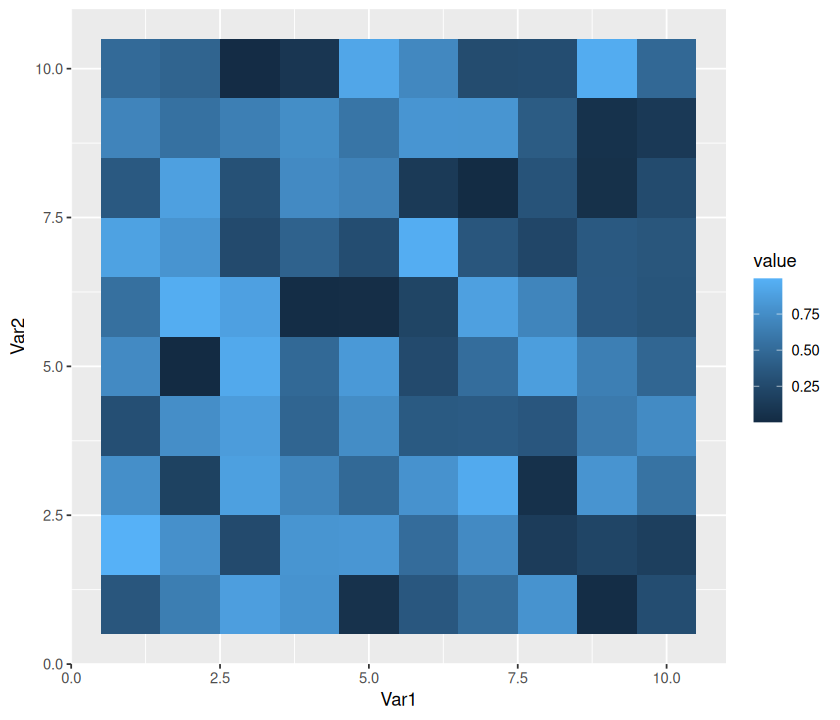

In [131]:
p <- ggplot(Melt, aes(Var1, Var2, fill = value)) + geom_tile() + theme(aspect.ratio = 1)
p

Add a black line dividing cells:

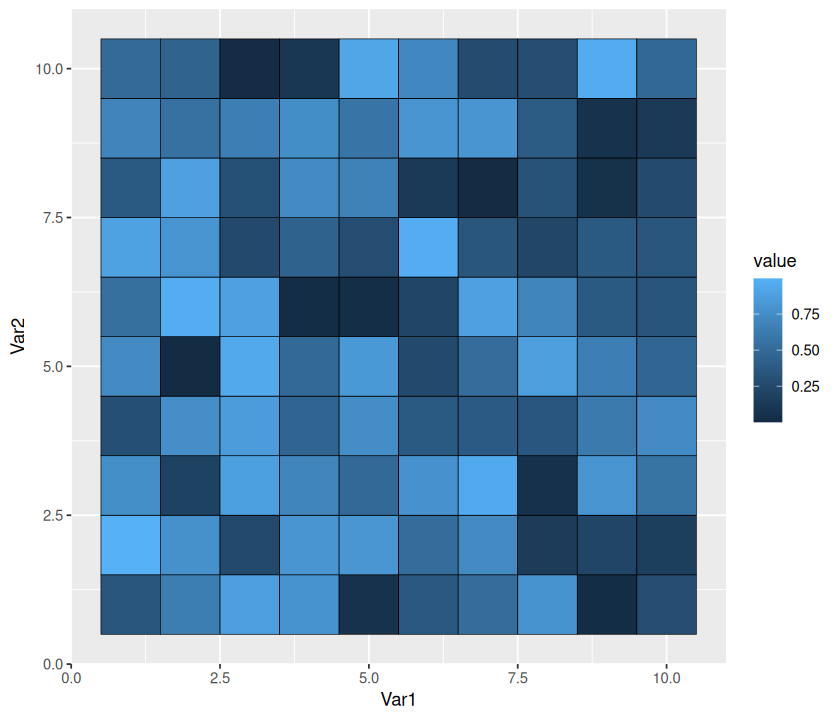

In [132]:
p + geom_tile(colour = "black") + theme(aspect.ratio = 1)

Remove the legend:

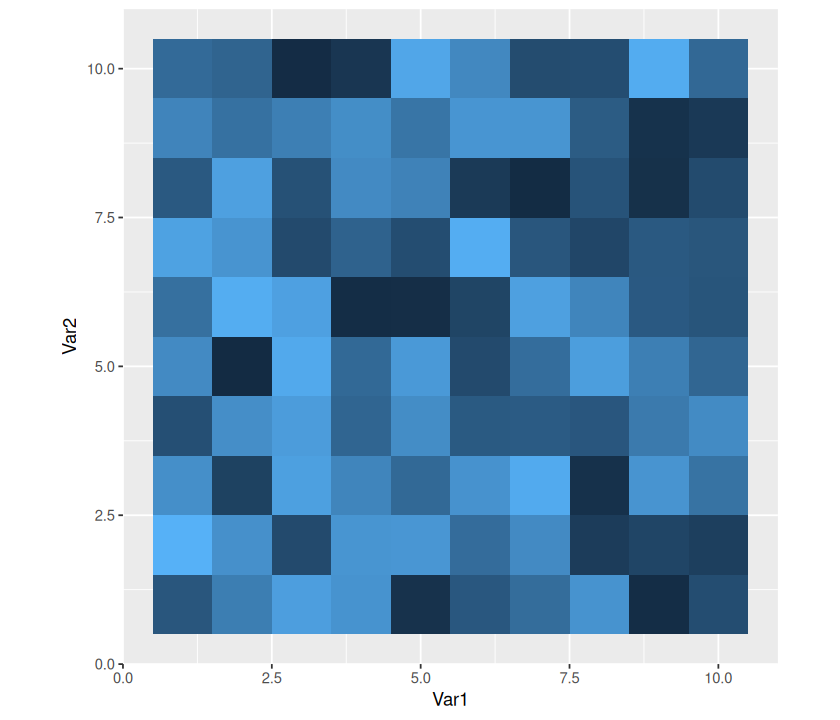

In [133]:
p + theme(legend.position = "none") + theme(aspect.ratio = 1)

Remove all the rest:

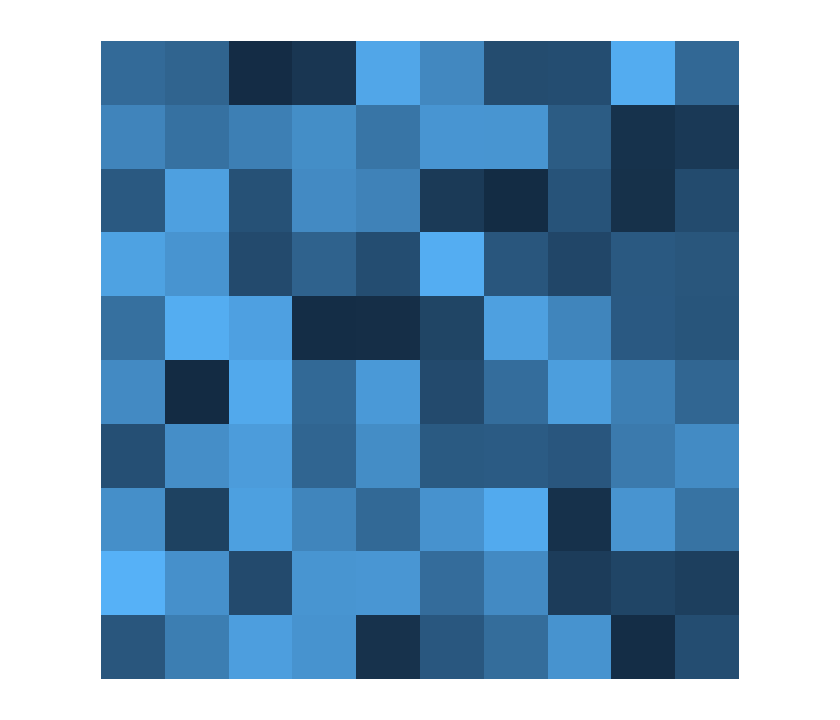

In [134]:
p + theme(legend.position = "none", 
     panel.background = element_blank(),
     axis.ticks = element_blank(), 
     panel.grid.major = element_blank(),
     panel.grid.minor = element_blank(),
     axis.text.x = element_blank(),
     axis.title.x = element_blank(),
     axis.text.y = element_blank(),
     axis.title.y = element_blank())

Explore some colors:

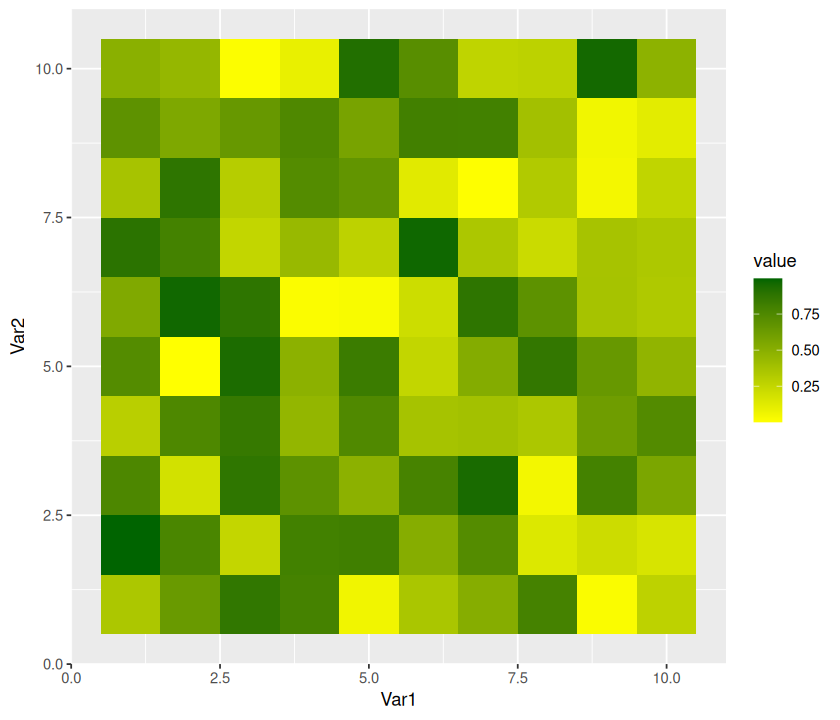

In [135]:
p + scale_fill_continuous(low = "yellow", high = "darkgreen")

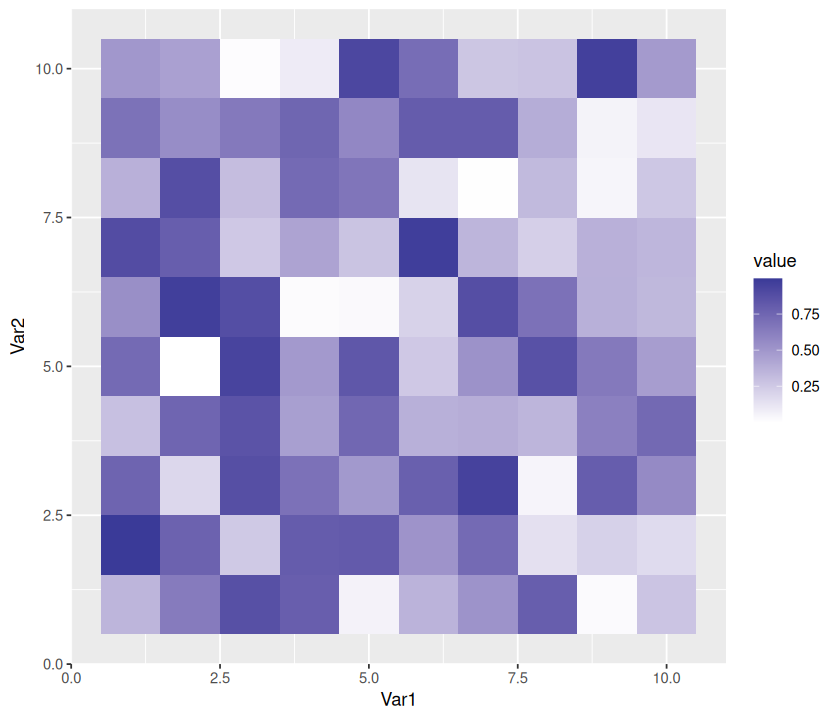

In [136]:
p + scale_fill_gradient2()

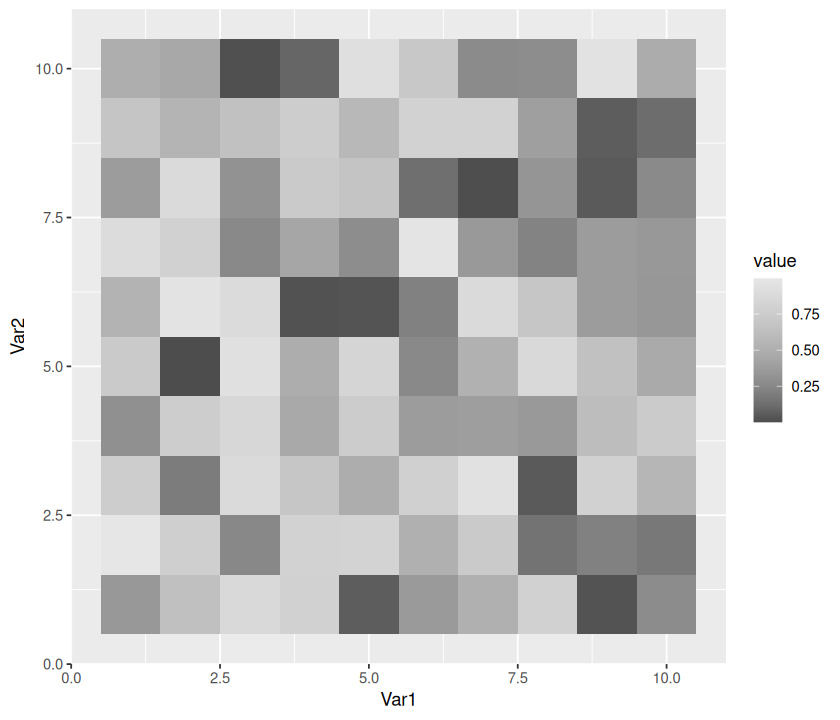

In [137]:
p + scale_fill_gradientn(colours = grey.colors(10))

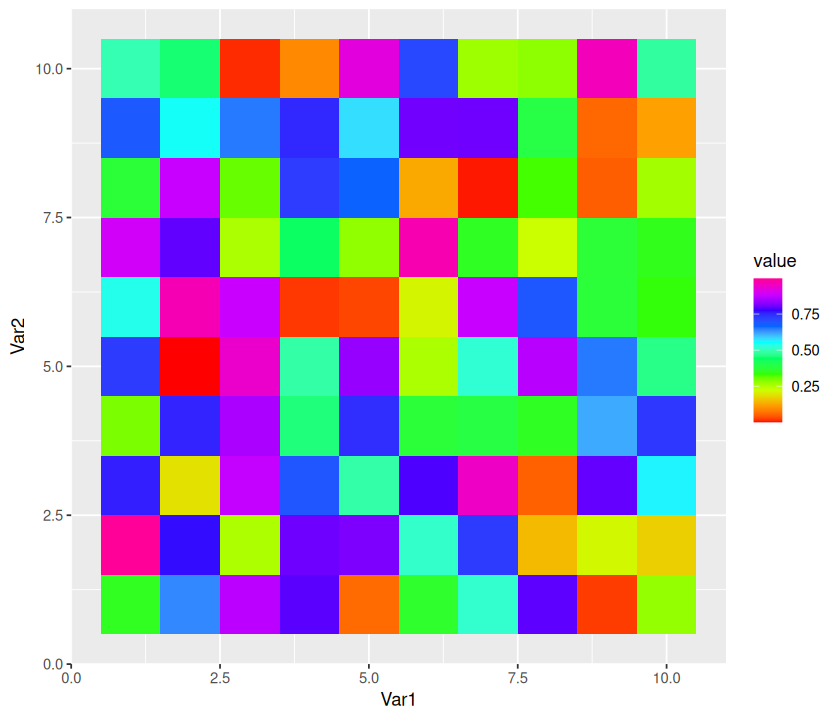

In [138]:
p + scale_fill_gradientn(colours = rainbow(10))

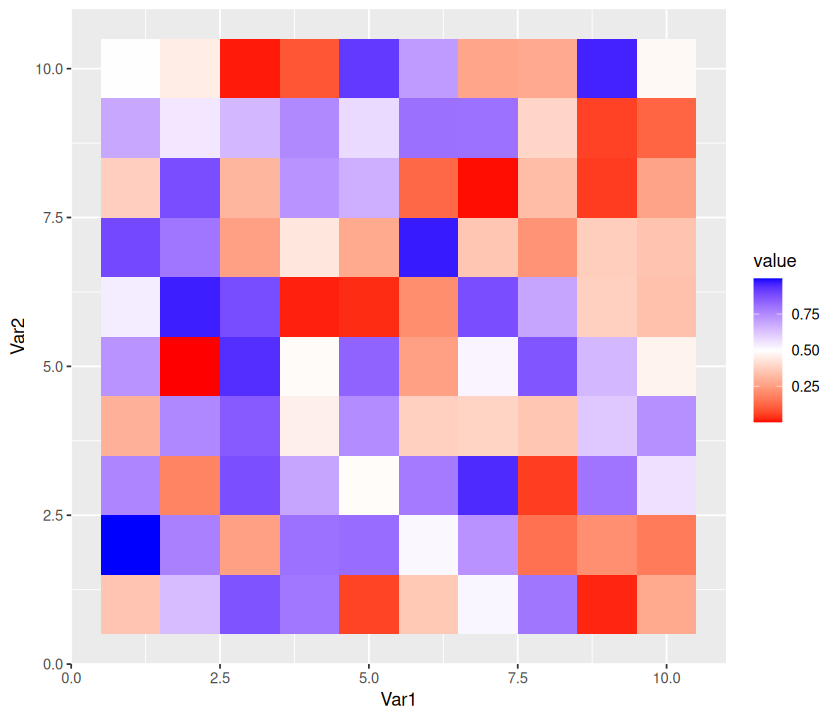

In [139]:
p + scale_fill_gradientn(colours = c("red", "white", "blue"))

```{tip}
Look up the `plotly` package, which allows you to create interactive graphs from ggplot2 plots
``` 

### Plotting two dataframes together

According to Girko's circular law, the eigenvalues of a matrix $M$ of size $N \times N$ are approximately contained in a circle in the complex plane with radius $\sqrt{N}$. Let's draw the results of a simulation displaying this result.

First, we need to build a function object that will calculate the ellipse (the perdicted bounds of the eigenvalues): 

In [140]:
build_ellipse <- function(hradius, vradius){ # function that returns an ellipse
  npoints = 250
  a <- seq(0, 2 * pi, length = npoints + 1)
  x <- hradius * cos(a)
  y <- vradius * sin(a)  
  return(data.frame(x = x, y = y))
}

In [141]:
N <- 250 # Assign size of the matrix

M <- matrix(rnorm(N * N), N, N) # Build the matrix

eigvals <- eigen(M)$values # Find the eigenvalues

eigDF <- data.frame("Real" = Re(eigvals), "Imaginary" = Im(eigvals)) # Build a dataframe

my_radius <- sqrt(N) # The radius of the circle is sqrt(N)

ellDF <- build_ellipse(my_radius, my_radius) # Dataframe to plot the ellipse

names(ellDF) <- c("Real", "Imaginary") # rename the columns

Now the plotting:

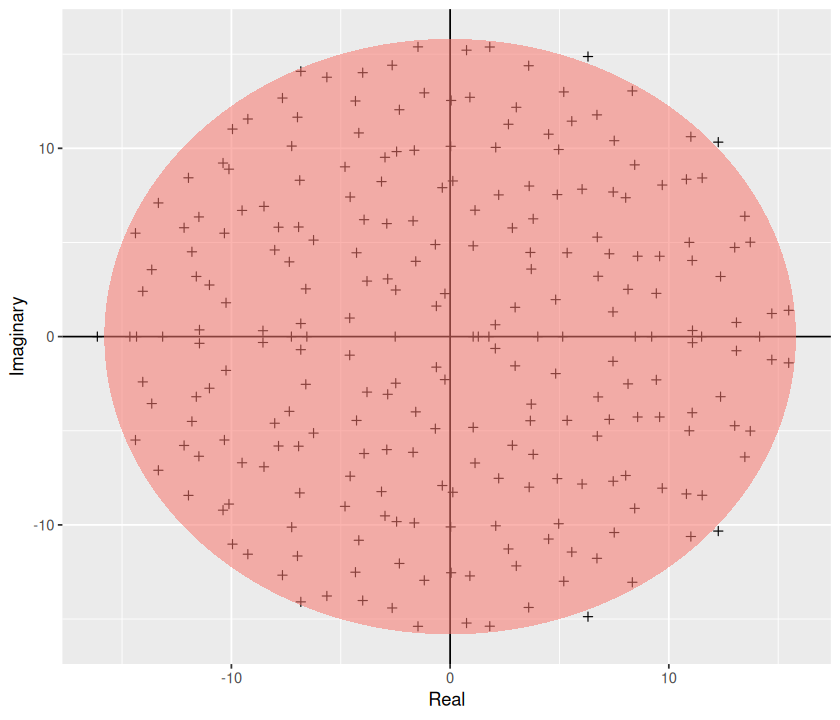

In [142]:
# plot the eigenvalues
p <- ggplot(eigDF, aes(x = Real, y = Imaginary))
p <- p +
  geom_point(shape = I(3)) +
  theme(legend.position = "none")

# now add the vertical and horizontal line
p <- p + geom_hline(aes(yintercept = 0))
p <- p + geom_vline(aes(xintercept = 0))

# finally, add the ellipse
p <- p + geom_polygon(data = ellDF, aes(x = Real, y = Imaginary, alpha = 1/20, fill = "red"))
p

$\star$ Create a self-sufficient R Script called `Girko.R` that combines all the above commands for plotting the Girko's law simulation, including saving the result figure as a file called `Girko.pdf` in the results directory.

### Annotating plots

In this example, we will use the ggplot `geom` `text` to annotate a plot.

In [143]:
a <- read.table("../data/Results.txt", header = TRUE)

Check what the data look like:

In [144]:
head(a)

x        y1   y2   y3 Label
1 3.515424 4320 4320 0  NA   
2 3.533984 2160 2160 0  NA   
3 3.557647 4320 4320 0  NA   
4 3.569953 4320 4320 0  NA   
5 3.578984 8640 8640 0  NA   
6 3.585665 2160 2160 0  NA

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 91 rows containing missing values or values outside the scale range
(`geom_text()`).”


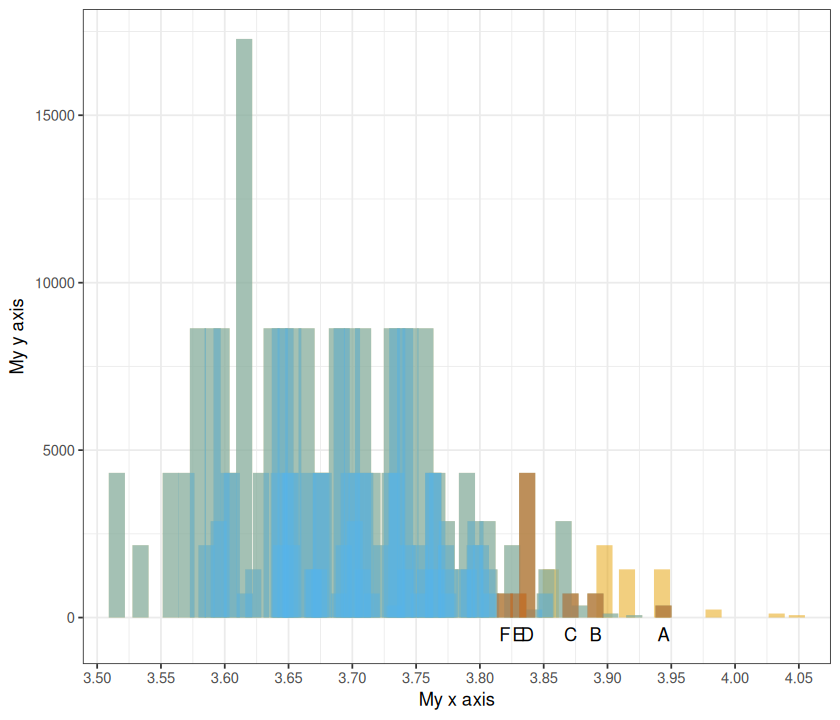

In [145]:
a$ymin <- rep(0, dim(a)[1]) # append a column of zeros

# Print the first linerange
p <- ggplot(a)
p <- p + geom_linerange(data = a, aes(
                          x = x,
                          ymin = ymin,
                          ymax = y1,
                          size = (0.5)
                          ),
                        colour = "#E69F00",
                        alpha = 1/2, show.legend = FALSE)

# Print the second linerange
p <- p + geom_linerange(data = a, aes(
                          x = x,
                          ymin = ymin,
                          ymax = y2,
                          size = (0.5)
                          ),
                        colour = "#56B4E9",
                        alpha = 1/2, show.legend = FALSE)

# Print the third linerange:
p <- p + geom_linerange(data = a, aes(
                          x = x,
                          ymin = ymin,
                          ymax = y3,
                          size = (0.5)
                          ),
                        colour = "#D55E00",
                        alpha = 1/2, show.legend = FALSE)

# Annotate the plot with labels:
p <- p + geom_text(data = a, aes(x = x, y = -500, label = Label))

# now set the axis labels, remove the legend, and prepare for bw printing
p <- p + scale_x_continuous("My x axis",
                            breaks = seq(3, 5, by = 0.05)) + 
                            scale_y_continuous("My y axis") + 
                            theme_bw() + 
                            theme(legend.position = "none") 
p

$\star$ Create a self-sufficient R Script called `MyBars.R` that combines all the above commands for annotating a plot, including saving the result figure as a file called `MyBars.pdf`.

### Mathematical display

Let's try mathematical annotation of an axis as well as within the plot area.

First create some linear regression "data":

Warning message in geom_text(aes(x = 60, y = 0, label = "sqrt(alpha) * 2* pi"), :
“All aesthetics have length 1, but the data has 1001 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing a single
  row.”


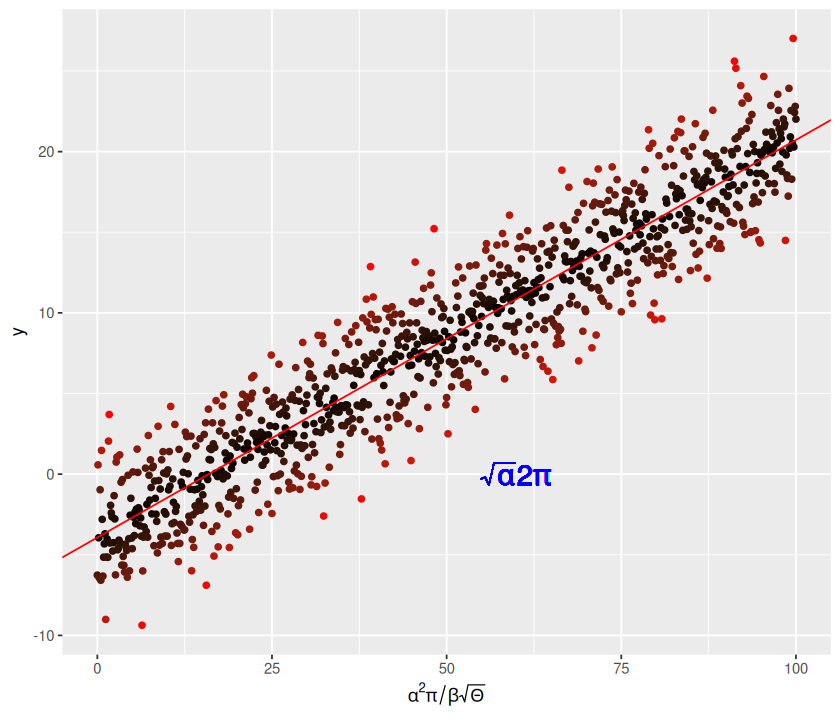

In [146]:
x <- seq(0, 100, by = 0.1)
y <- -4. + 0.25 * x +
  rnorm(length(x), mean = 0., sd = 2.5)

# and put them in a dataframe
my_data <- data.frame(x = x, y = y)

# perform a linear regression
my_lm <- summary(lm(y ~ x, data = my_data))

# plot the data
p <-  ggplot(my_data, aes(x = x, y = y,
                          colour = abs(my_lm$residual))
             ) +
  geom_point() +
  scale_colour_gradient(low = "black", high = "red") +
  theme(legend.position = "none") +
  scale_x_continuous(
    expression(alpha^2 * pi / beta * sqrt(Theta)))

# add the regression line
p <- p + geom_abline(
  intercept = my_lm$coefficients[1][1],
  slope = my_lm$coefficients[2][1],
  colour = "red")
# throw some math on the plot
p <- p + geom_text(aes(x = 60, y = 0,
                       label = "sqrt(alpha) * 2* pi"), 
                       parse = TRUE, size = 6, 
                       colour = "blue")

p

$\star$ Create a self-sufficient R Script called `plotLin.R` that combines all the above commands for annotating a linear regression plot, including saving the resulting figure as a file called `MyLinReg.pdf`.

### ggthemes

The package `ggthemes` provides you some additional `geom`s, ` scale`s, and `theme`s for `ggplot`. These include a theme based on Tufte's *The Visual Display of Quantitative Information* (see [suggested readings](#Readings-&-Resources)). 

Let's try this package. First install it:

```R
install.packages("ggthemes")
```

Then try:

In [147]:
library(ggthemes)

p <- ggplot(MyDF, aes(x = log(Predator.mass), y = log(Prey.mass),
                colour = Type.of.feeding.interaction )) +
                geom_point(size=I(2), shape=I(10)) + theme_bw()

p + geom_rangeframe() + # now fine tune the geom to Tufte's range frame
        theme_tufte() # and theme to Tufte's minimal ink theme    

ERROR: Error in library(ggthemes): there is no package called ‘ggthemes’


Go to https://github.com/jrnold/ggthemes for more information and a list of `geom`s, `theme`s, and `scale`s.

## Practicals

### Visualizing Regression analyses 

In this practical, you will write script that draws and saves a pdf file of the following figure, and writes the accompanying regression results to a formatted table in csv. Note that as the plot suggests, that the analysis must be subsetted by the `Predator.lifestage` field of the dataset. 

---

![image](./graphics/Figure1.png)
<small><center>
               Write a script that generates this figure
    </center></small>


*Guidelines*:

* Write a `R` script file called `PP_Regress.R` and save it in the `Code` directory. Sourcing or running this
script should result in one pdf file containing the following figure being saved in the `results` directory: (Hint: Use the `print()` command to write to the pdf)

* In addition, the script should calculate the regression results corresponding to the lines fitted in the figure and save it to a csv delimited table called (`PP_Regress_Results.csv`), in the `results` directory. (Hint: you will have to initialize a new dataframe in the script to first store the calculations and then `write.csv()` or `write.table()` it.)

* All that you are being asked for here is results of an analysis of Linear regression on subsets of the data corresponding to available Feeding Type $\times$ Predator life Stage combination — not a multivariate linear model with these two as separate covariates!

* The regression results should include the following with appropriate headers (e.g., slope, intercept, etc, in each Feeding type $\times$ life stage category): regression slope, regression intercept, R$^2$, F-statistic value, and p-value of the overall regression (Hint: Review the Stats week!).

* The script should be self-sufficient and not need any external inputs — it should import the above predator-prey dataset from the appropriate directory, and save the graphic plots to the appropriate directory (Hint: use relative paths). Anybody should be able to `source` it without errors.

* You can also use the `dplyr` function instead of looping (see R Chapter, and the `ggplot` command instead of `qplot`.


### Mapping 

You can do mapping in R using the `maps` package. In this practical, you will map the Global Population Dynamics Database (GPDD). This is a freely available database that was developed at Silwood. The [Living Planet Index](http://livingplanetindex.org/home/index) is based upon these data.
 *  Use `load()` from `GPDDFiltered.RData` that is available on the TheMulQuaBio git repository &mdash; have a look at the data contents. 
 *  What you need is latitude and longitude information for a bunch of species for which population time series are available in the GPDD.
 *  Now use `install.packages()` to install the package `maps`, as you did with `ggplot2`
 *  Now create a script called `GPDD_Data.R` that:
    * Loads the maps package
    * Loads the GPDD data
    * Creates a world map (use the map function, read its help, also google examples using `maps`
    * Superimposes on the map all the locations from which we have data in the GPDD dataframe
 * Looking at the map, what biases might you expect in any analysis based on the data represented? *include your answer as a comment at the end of your R script*.


### Groupwork practical: Regression analysis 

Do the same as (1) above, but the analysis this time should be separate by the dataset's `Location` field. Call it `PP_Regress_loc.R`. No need to generate plots for this (just the analysis results to a `.csv` file), as a combination of `Type.of.feeding.interaction`, `Predator.lifestage`, and ` Location` will be far too busy (faceting by three variables is too much to be meaningful)!

## Readings & Resources

Check out *DataDataData!*, *Visualization* and *R*, under [*readings* on the MQB repository](https://github.com/MulQuaBio/MQB/tree/main/content/readings).

### Data management, reformatting and cleaning

* Brian McGill's [Ten commandments for data management](
    https://dynamicecology.wordpress.com/2016/08/22/ten-commandments-for-good-data-management)

* This paper covers similar ground (available in the readings directory): [Borer et al (2009). Some Simple Guidelines for Effective Data Management. Bulletin of the Ecological Society of America, 90(2), 205-214.](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1890/0012-9623-90.2.205)

* [Dasu, T. & Johnson, T. Exploratory Data Mining and Data Cleaning. (John Wiley & Sons, Inc., 2003). doi:10.1002/0471448354](https://onlinelibrary.wiley.com/doi/book/10.1002/0471448354)

* [Wide vs. long data](http://www.theanalysisfactor.com/wide-and-long-data/)

* [Hadley Wickham's excellent article about "tidy" data](http://vita.had.co.nz/papers/tidy-data.pdf).

* [Wrangler](http://vis.stanford.edu/papers/wrangler)

* [An interactive framework for data cleaning](https://www2.eecs.berkeley.edu/Pubs/TechRpts/2000/CSD-00-1110.pdf)

### Data analysis

* [R for Data Science](https://r4ds.had.co.nz/index.html)

### Data visualization

* [Ten Simple Rules for Better Figures](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003833)

* https://clauswilke.com/dataviz/

* [Rolandi et al. "A Brief Guide to Designing Effective Figures for the Scientific Paper", doi:10.1002/adma.201102518](https://onlinelibrary.wiley.com/doi/pdf/10.1002/adma.201102518?casa_token=48b0PGtaUiYAAAAA:DQ9bHugikOkHDkf4uLTYIq74negyWefZjAbexYcgYObHn0sks2Q8ulvHcTUWxteqwTb5qAa0IV71Mg)

* The classic [Tufte](https://www.edwardtufte.com/tufte/books_vdqi); Available in the Imperial College Central Library. I have also added extracts and a related book in pdf on the git repository. BTW, check out what Tufte thinks of [PowerPoint](https://www.edwardtufte.com/tufte/powerpoint).

* [Tufte in R](http://motioninsocial.com/tufte)